In [1]:
# Enable autoreload
%load_ext autoreload
%autoreload 2

In [2]:
!pip install xgboost tqdm shap

In [3]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedShuffleSplit, TimeSeriesSplit, cross_validate
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy.special import logit, expit
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_squared_error
import itertools
import shap
shap.initjs()
from datetime import datetime


pd.set_option('max_columns',None)
pd.set_option('display.max_rows', 200)
tqdm.pandas()

# Import pickle file with features

In [4]:
df = pd.read_pickle('./data/export_features_2016_2020.pkl.bz2')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3151842 entries, 9938765 to 13791338
Columns: 147 entries, amount to band_ev
dtypes: category(2), datetime64[ns](1), float64(74), int64(64), object(6)
memory usage: 3.4+ GB


In [9]:
df_orig = df.copy() # save all data for later

In [ ]:
df=df_orig # get all data back

In [7]:
all_features = ['location_count', 'location_mean', 'location_std',
 'location_min', 'location_5%', 'location_10%', 'location_15%',
 'location_20%', 'location_25%', 'location_30%', 'location_35%',
 'location_40%', 'location_45%', 'location_50%', 'location_55%',
 'location_60%', 'location_65%', 'location_70%', 'location_75%',
 'location_80%', 'location_85%', 'location_90%', 'location_95%',
 'location_max', 
                
 'band_count', 'band_mean', 'band_std',
 'band_min', 'band_5%', 'band_10%', 'band_15%', 'band_20%',
 'band_25%', 'band_30%', 'band_35%', 'band_40%', 'band_45%',
 'band_50%', 'band_55%', 'band_60%', 'band_65%', 'band_70%',
 'band_75%', 'band_80%', 'band_85%', 'band_90%', 'band_95%',
 'band_max', 
                
 'promoter_count', 'promoter_mean', 'promoter_std',
 'promoter_min', 'promoter_5%', 'promoter_10%', 'promoter_15%',
 'promoter_20%', 'promoter_25%', 'promoter_30%', 'promoter_35%',
 'promoter_40%', 'promoter_45%', 'promoter_50%', 'promoter_55%',
 'promoter_60%', 'promoter_65%', 'promoter_70%', 'promoter_75%',
 'promoter_80%', 'promoter_85%', 'promoter_90%', 'promoter_95%',
 'promoter_max', 
 
 'vg_datum_year', 'vg_datum_month', 'vg_datum_day_of_week',
                
 'location_kirche',  'location_hotel', 'location_theater', 'location_cafe',
 'location_stadthalle', 'location_buergerhaus', 'location_club', 'location_gaststaette',
 'location_halle', 'location_festhalle', 'location_kurhaus', 'location_schloss',
 'location_restaurant', 'location_kulturzentrum', 'location_festzelt', 'location_musikschule',
 'location_mehrzweckhalle', 'location_pub', 'location_bar', 'location_gasthaus', 'location_turnhalle',
 'location_kulturhaus', 'location_gymnasium', 'location_rathaus', 'location_gasthof',
 'location_park', 'location_kabarett', 'location_schuetzenhalle', 'location_gemeindehalle',
 'location_gemeindehaus', 
                
 'band_musikverein', 'band_band', 'band_mv', 'band_duo', 'band_trio', 'band_musikkapelle',
 'band_chor', 'band_blaskapelle', 'band_orchester', 'band_stadtkapelle', 'band_gbr',
 'band_jazz', 'band_kurorchester', 'band_amp', 'band_ensemble', 'band_blasorchester',
 'band_partyband', 'band_friends', 'band_blues', 'band_original', 'band_live',
 'band_swing', 'band_musikzug', 'band_solo', 'band_mgv', 'band_jugendkapelle',
 'band_sound', 'band_harmonie', 'band_black', 'band_ev']

# Explore Data

In [8]:
df[df.amount_segment==3].amount.describe()

count    583137.000000
mean         72.347846
std          13.507422
min          15.300000
25%          61.270000
50%          69.900000
75%          82.800000
max         117.750000
Name: amount, dtype: float64

In [9]:
df.groupby(['amount_segment']).min()

Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.


,amount,vg_datum_von,tariff_id,vg_datum_year,vg_datum_month,vg_datum_day_of_week,band_10%,band_15%,band_20%,band_25%,band_30%,band_35%,band_40%,band_45%,band_5%,band_50%,band_55%,band_60%,band_65%,band_70%,band_75%,band_80%,band_85%,band_90%,band_95%,band_count,band_max,band_mean,band_min,band_std,location_10%,location_15%,location_20%,location_25%,location_30%,location_35%,location_40%,location_45%,location_5%,location_50%,location_55%,location_60%,location_65%,location_70%,location_75%,location_80%,location_85%,location_90%,location_95%,location_count,location_max,location_mean,location_min,location_std,promoter_10%,promoter_15%,promoter_20%,promoter_25%,promoter_30%,promoter_35%,promoter_40%,promoter_45%,promoter_5%,promoter_50%,promoter_55%,promoter_60%,promoter_65%,promoter_70%,promoter_75%,promoter_80%,promoter_85%,promoter_90%,promoter_95%,promoter_count,promoter_max,promoter_mean,promoter_min,promoter_std,location_kirche,location_hotel,location_theater,location_cafe,location_stadthalle,location_buergerhaus,location_club,location_gaststaette,location_halle,location_festhalle,location_kurhaus,location_schloss,location_restaurant,location_kulturzentrum,location_festzelt,location_musikschule,location_mehrzweckhalle,location_pub,location_bar,location_gasthaus,location_turnhalle,location_kulturhaus,location_gymnasium,location_rathaus,location_gasthof,location_park,location_kabarett,location_schuetzenhalle,location_gemeindehalle,location_gemeindehaus,band_musikverein,band_band,band_mv,band_duo,band_trio,band_musikkapelle,band_chor,band_blaskapelle,band_orchester,band_stadtkapelle,band_gbr,band_jazz,band_kurorchester,band_amp,band_ensemble,band_blasorchester,band_partyband,band_friends,band_blues,band_original,band_live,band_swing,band_musikzug,band_solo,band_mgv,band_jugendkapelle,band_sound,band_harmonie,band_black,band_ev
amount_segment,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2.0,0.04,2014-01-02,500,2014,1,0,0.360,0.360,0.36,0.36,0.360,0.36,0.360,0.36,0.360,0.36,2.00,2.00,2.00,2.000,2.000,2.00,2.00,2.00,2.00,1.0,2.00,2.000,0.04,0.0,0.312,0.318,0.330,0.33,0.33,0.33,0.330,0.33,0.306,0.33,0.33,0.330,0.330,0.33,0.33,0.33,0.33,0.33,0.33,1.0,0.33,0.330000,0.04,0.0,0.308,0.312,0.316,0.32,0.32,0.32,0.32,0.32,0.304,0.32,0.32,0.32,0.32,0.32,0.32,0.32,0.32,0.320,0.320,1.0,0.32,0.320000,0.04,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3.0,15.30,2014-01-02,500,2014,1,0,2.000,2.000,2.00,2.00,3.604,5.21,5.210,5.21,2.000,5.21,5.21,5.21,5.21,5.210,5.210,5.21,5.21,5.21,5.21,1.0,5.21,5.210,0.04,0.0,0.990,0.990,2.290,3.04,3.69,3.69,3.690,3.69,0.990,3.69,3.69,3.690,3.690,3.69,3.69,3.69,3.69,3.69,3.69,1.0,3.69,3.690000,0.04,0.0,2.290,2.290,2.290,2.29,2.29,2.29,2.29,2.90,1.200,2.90,2.90,2.90,2.90,2.90,2.90,2.90,2.90,2.900,2.900,1.0,2.90,2.900000,0.04,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4.0,23.55,2014-01-02,500,2014,1,0,4.690,9.320,9.64,9.64,9.640,9.64,11.020,11.02,4.690,11.02,11.02,11.02,11.02,11.020,11.020,11.02,11.02,11.02,11.02,1.0,11.02,11.020,0.04,0.0,3.200,3.200,6.288,10.92,11.02,11.02,11.020,11.02,3.200,11.02,11.02,11.020,11.020,11.02,11.02,11.02,11.02,11.02,11.02,1.0,11.02,11.020000,0.04,0.0,0.990,0.990,0.990,4.63,4.63,4.63,4.63,6.76,0.990,6.76,6.76,6.76,6.76,6.76,6.76,6.76,6.76,6.760,6.760,1.0,6.76,6.760000,0.04,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5.0,29.94,2014-01-03,500,2014,1,0,4.690,7.269,8.62,8.62,11.020,11.02,11.020,11.02,2.583,11.02,11.02,11.02,11.02,11.020,11.020,11.02,11.02,11.02,11.02,1.0,11.02,11.020,0.08,0.0,0.360,0.360,4.056,11.02,11.02,11.02,11.020,11.02,0.306,11.02,11.02,11.020,11.020,11.02,11.02,11.02,11.02,11.02,11.02,1.0,11.02,11.020000,0.04,0.0,0.360,0.360,4.056,7.70,7.70

In [14]:
df.groupby(['amount_segment']).max()

,amount,vg_datum_von,kapelle_name,veranst_name,veranst_plz,tariff_id,location,band,promoter,vg_datum_year,vg_datum_month,vg_datum_day_of_week,band_10%,band_15%,band_20%,band_25%,band_30%,band_35%,band_40%,band_45%,band_5%,band_50%,band_55%,band_60%,band_65%,band_70%,band_75%,band_80%,band_85%,band_90%,band_95%,band_count,band_max,band_mean,band_min,band_std,location_10%,location_15%,location_20%,location_25%,location_30%,location_35%,location_40%,location_45%,location_5%,location_50%,location_55%,location_60%,location_65%,location_70%,location_75%,location_80%,location_85%,location_90%,location_95%,location_count,location_max,location_mean,location_min,location_std,promoter_10%,promoter_15%,promoter_20%,promoter_25%,promoter_30%,promoter_35%,promoter_40%,promoter_45%,promoter_5%,promoter_50%,promoter_55%,promoter_60%,promoter_65%,promoter_70%,promoter_75%,promoter_80%,promoter_85%,promoter_90%,promoter_95%,promoter_count,promoter_max,promoter_mean,promoter_min,promoter_std,location_kirche,location_hotel,location_theater,location_cafe,location_stadthalle,location_buergerhaus,location_club,location_gaststaette,location_halle,location_festhalle,location_kurhaus,location_schloss,location_restaurant,location_kulturzentrum,location_festzelt,location_musikschule,location_mehrzweckhalle,location_pub,location_bar,location_gasthaus,location_turnhalle,location_kulturhaus,location_gymnasium,location_rathaus,location_gasthof,location_park,location_kabarett,location_schuetzenhalle,location_gemeindehalle,location_gemeindehaus,band_musikverein,band_band,band_mv,band_duo,band_trio,band_musikkapelle,band_chor,band_blaskapelle,band_orchester,band_stadtkapelle,band_gbr,band_jazz,band_kurorchester,band_amp,band_ensemble,band_blasorchester,band_partyband,band_friends,band_blues,band_original,band_live,band_swing,band_musikzug,band_solo,band_mgv,band_jugendkapelle,band_sound,band_harmonie,band_black,band_ev
amount_segment,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2.0,409.70,2020-12-31,NaN,NaN,NaN,1510,NaN,NaN,NaN,2020,12,6,792365.300,7.923653e+05,792365.300,792365.30,792365.300,792365.300,792365.300,792365.300,7.923653e+05,792365.30,792365.300,792365.300,7.923653e+05,792365.300,7.923653e+05,792365.300,792365.300,792365.300,9.815488e+05,1970.0,1029574.59,7.923653e+05,792365.30,548118.170143,439276.340,439276.34,503280.26,503280.26,742567.930,775194.71,943699.51,994165.18,106585.190,994165.18,994165.18,994165.18,994165.18,994165.18,994165.18,994165.18,994165.18,1029574.59,1029574.59,6257.0,1029574.59,647900.649646,17662.19,458437.160762,29138.520,29138.52,29138.52,32139.7600,76223.860,76223.860,103618.90,106484.78,14912.000,186245.10,246329.99,246329.99,775194.71,775194.71,775194.71,775194.71,792365.30,792365.30,792365.30,7600.0,818332.70,334990.586676,8045.00,360825.277554,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3.0,117.75,2020-12-20,NaN,NaN,NaN,1510,NaN,NaN,NaN,2020,12,6,542072.200,5.420722e+05,542072.200,542072.20,596535.588,695942.986,795350.384,894757.782,5.420722e+05,994165.18,994165.180,994165.180,9.941652e+05,994165.180,9.941652e+05,994165.180,994165.180,994165.180,9.941652e+05,1970.0,1029574.59,6.628072e+05,542072.20,573928.879947,439276.340,439276.34,503280.26,503280.26,513443.537,521887.28,943699.51,994165.18,240794.100,994165.18,994165.18,994165.18,994165.18,994165.18,994165.18,994165.18,994165.18,1029574.59,1029574.59,6257.0,1029574.59,647900.522508,117524.51,458437.424425,228136.300,228136.30,228136.30,228136.3000,228136.300,228136.300,228136.30,228136.30,228136.300,238590.89,246329.99,246329.99,775194.71,775194.71,775194.71,775194.71,792365.30,792365.30,792365.30,7600.0,818332.70,334990.554563,52201.67,360825.308532,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4.0,442.07,2020-11-01,Na

In [15]:
df.groupby(['amount_segment']).count()

,amount,vg_ort,vg_raum,vg_datum_von,kapelle_name,veranst_name,veranst_plz,tariff_id,location,band,promoter,vg_datum_year,vg_datum_month,vg_datum_day_of_week,band_10%,band_15%,band_20%,band_25%,band_30%,band_35%,band_40%,band_45%,band_5%,band_50%,band_55%,band_60%,band_65%,band_70%,band_75%,band_80%,band_85%,band_90%,band_95%,band_count,band_max,band_mean,band_min,band_std,location_10%,location_15%,location_20%,location_25%,location_30%,location_35%,location_40%,location_45%,location_5%,location_50%,location_55%,location_60%,location_65%,location_70%,location_75%,location_80%,location_85%,location_90%,location_95%,location_count,location_max,location_mean,location_min,location_std,promoter_10%,promoter_15%,promoter_20%,promoter_25%,promoter_30%,promoter_35%,promoter_40%,promoter_45%,promoter_5%,promoter_50%,promoter_55%,promoter_60%,promoter_65%,promoter_70%,promoter_75%,promoter_80%,promoter_85%,promoter_90%,promoter_95%,promoter_count,promoter_max,promoter_mean,promoter_min,promoter_std,location_kirche,location_hotel,location_theater,location_cafe,location_stadthalle,location_buergerhaus,location_club,location_gaststaette,location_halle,location_festhalle,location_kurhaus,location_schloss,location_restaurant,location_kulturzentrum,location_festzelt,location_musikschule,location_mehrzweckhalle,location_pub,location_bar,location_gasthaus,location_turnhalle,location_kulturhaus,location_gymnasium,location_rathaus,location_gasthof,location_park,location_kabarett,location_schuetzenhalle,location_gemeindehalle,location_gemeindehaus,band_musikverein,band_band,band_mv,band_duo,band_trio,band_musikkapelle,band_chor,band_blaskapelle,band_orchester,band_stadtkapelle,band_gbr,band_jazz,band_kurorchester,band_amp,band_ensemble,band_blasorchester,band_partyband,band_friends,band_blues,band_original,band_live,band_swing,band_musikzug,band_solo,band_mgv,band_jugendkapelle,band_sound,band_harmonie,band_black,band_ev
amount_segment,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2.0,1374206,1374112,1374133,1374206,771780,1374026,1373823,1374206,1374133,784987,1374148,1374206,1374206,1374206,710995,710995,710995,710995,710995,710995,710995,710995,710995,710995,710995,710995,710995,710995,710995,710995,710995,710995,710995,710995,710995,710995,710995,644333,1353382,1353382,1353382,1353382,1353382,1353382,1353382,1353382,1353382,1353382,1353382,1353382,1353382,1353382,1353382,1353382,1353382,1353382,1353382,1353382,1353382,1353382,1353382,1325640,1345589,1345589,1345589,1345589,1345589,1345589,1345589,1345589,1345589,1345589,1345589,1345589,1345589,1345589,1345589,1345589,1345589,1345589,1345589,1345589,1345589,1345589,1345589,1308354,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206,1374206
3.0,583137,583098,583120,583137,336737,583054,582895,583137,583120,341300,583095,583137,583137,583137,315702,315702,315702,315702,315702,315702,315702,315702,315702,315702,315702,315702,315702,315702,315702,315702,315702,315702,315702,315702,315702,315702,315702,288238,578057,578057,578057,578057,578057,578057,578057,578057,578057,578057,578057,578057,578057,578057,578057,578057,578057,578057,578057,578057,578057,578057,578057,570218,569287,569287,569287,569287,569287,569287,569287,569287,569287,569287,569287,569287,569287,569287,569287,569287,569287,569287,569287,569287,569287,569287,569287,549327,583137,583137,583137,583137,583137,583137,583137,583137,583137,583137,583137,583137,583137,583137,583137,583137,583137,583137,583137,583137,583137,583137,

In [16]:
df[(df.amount>150) &(df.amount_segment==4)].shape

(1, 147)

# Get sample of the data

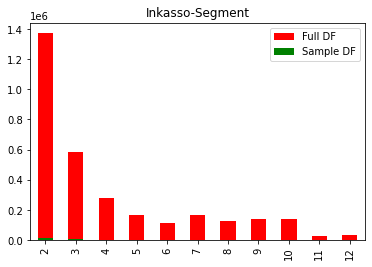

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31519 entries, 11102856 to 10293421
Columns: 147 entries, amount to band_ev
dtypes: category(2), datetime64[ns](1), float64(74), int64(64), object(6)
memory usage: 40.6+ MB


In [8]:
#Get a sample of the DataFrame 
splitSample = StratifiedShuffleSplit(n_splits=1, test_size=0.01, random_state=42)

for train_idx, test_idx in splitSample.split(df[all_features], df.amount_segment):
    df_sample=df.iloc[test_idx]
    
    plt.figure()
    df.amount_segment.astype(int).value_counts().sort_index().plot.bar(color='r')
    df_sample.amount_segment.astype(int).value_counts().sort_index().plot.bar(color='g')

    plt.title('Inkasso-Segment')
    plt.legend(['Full DF', 'Sample DF'])
    plt.show()

df=df_sample.copy()
df.info()

# Define Features

In [10]:
feature_groups = ['location', 'band', 'promoter']

feature_group_combinations = []
for i in range(1, len(feature_groups) + 1):
    comb = itertools.combinations(feature_groups, i)
    feature_group_combinations += list(comb)


In [11]:
features={}

features['location'] = ['location_count', 'location_mean', 'location_std',
 'location_min', 'location_5%', 'location_10%', 'location_15%',
 'location_20%', 'location_25%', 'location_30%', 'location_35%',
 'location_40%', 'location_45%', 'location_50%', 'location_55%',
 'location_60%', 'location_65%', 'location_70%', 'location_75%',
 'location_80%', 'location_85%', 'location_90%', 'location_95%',
 'location_max', 'location_kirche',  'location_hotel', 'location_theater', 'location_cafe',
 'location_stadthalle', 'location_buergerhaus', 'location_club', 'location_gaststaette',
 'location_halle', 'location_festhalle', 'location_kurhaus', 'location_schloss',
 'location_restaurant', 'location_kulturzentrum', 'location_festzelt', 'location_musikschule',
 'location_mehrzweckhalle', 'location_pub', 'location_bar', 'location_gasthaus', 'location_turnhalle',
 'location_kulturhaus', 'location_gymnasium', 'location_rathaus', 'location_gasthof',
 'location_park', 'location_kabarett', 'location_schuetzenhalle', 'location_gemeindehalle',
 'location_gemeindehaus']

features['band'] = ['band_count', 'band_mean', 'band_std',
 'band_min', 'band_5%', 'band_10%', 'band_15%', 'band_20%',
 'band_25%', 'band_30%', 'band_35%', 'band_40%', 'band_45%',
 'band_50%', 'band_55%', 'band_60%', 'band_65%', 'band_70%',
 'band_75%', 'band_80%', 'band_85%', 'band_90%', 'band_95%',
 'band_max','band_musikverein', 'band_band', 'band_mv', 'band_duo', 'band_trio', 'band_musikkapelle',
 'band_chor', 'band_blaskapelle', 'band_orchester', 'band_stadtkapelle', 'band_gbr',
 'band_jazz', 'band_kurorchester', 'band_amp', 'band_ensemble', 'band_blasorchester',
 'band_partyband', 'band_friends', 'band_blues', 'band_original', 'band_live',
 'band_swing', 'band_musikzug', 'band_solo', 'band_mgv', 'band_jugendkapelle',
 'band_sound', 'band_harmonie', 'band_black', 'band_ev']

features['promoter']=['promoter_count', 'promoter_mean', 'promoter_std',
 'promoter_min', 'promoter_5%', 'promoter_10%', 'promoter_15%',
 'promoter_20%', 'promoter_25%', 'promoter_30%', 'promoter_35%',
 'promoter_40%', 'promoter_45%', 'promoter_50%', 'promoter_55%',
 'promoter_60%', 'promoter_65%', 'promoter_70%', 'promoter_75%',
 'promoter_80%', 'promoter_85%', 'promoter_90%', 'promoter_95%',
 'promoter_max']
    
features['date']=['vg_datum_year', 'vg_datum_month', 'vg_datum_day_of_week']

In [12]:
model_features={}
for feature_group_combination in feature_group_combinations:
    model_name="_".join(feature_group_combination)
    model_features[model_name] = features['date']
    for feature_group in feature_groups:
        if feature_group in feature_group_combination:
            model_features[model_name]=model_features[model_name]+features[feature_group]

# Define Models

In [13]:
clf1_models = {}
clf2_models = {}
reg2_models = {}
reg3_models = {}
reg2_logit_models = {}
reg3_logit_models = {}

for feature_group_combination in feature_group_combinations:

    model_name="_".join(feature_group_combination)
    
    clf1_models[model_name]=xgb.XGBClassifier(n_estimators=1100, max_depth=9, use_label_encoder=False, objective='binary:logistic',eval_metric = 'error')
    clf1_models[model_name].set_params(tree_method = 'gpu_hist')
    clf2_models[model_name]=xgb.XGBClassifier(n_estimators=1100, max_depth=9, use_label_encoder=False, objective='binary:logistic',eval_metric = 'error')
    clf2_models[model_name].set_params(tree_method = 'gpu_hist')
    reg2_models[model_name]=xgb.XGBRegressor(n_estimators=700, max_depth=7, min_child_weight=5, objective='reg:squarederror')
    reg2_models[model_name].set_params(tree_method = 'gpu_hist')
    reg2_logit_models[model_name]=xgb.XGBRegressor(n_estimators=700, max_depth=7, min_child_weight=5, objective='reg:squarederror')
    reg2_logit_models[model_name].set_params(tree_method = 'gpu_hist')
    reg3_models[model_name]=xgb.XGBRegressor(n_estimators=700, max_depth=7, min_child_weight=5, objective='reg:squarederror')
    reg3_models[model_name].set_params(tree_method = 'gpu_hist')
    reg3_logit_models[model_name]=xgb.XGBRegressor(n_estimators=700, max_depth=7, min_child_weight=5, objective='reg:squarederror')
    reg3_logit_models[model_name].set_params(tree_method = 'gpu_hist')

# Prepare DataFrame for Classification Model

We keep only features + 'amount' and 'amount_segment' columns.

Encode segments for Classifier 1:
* Variable y_clf1 
* Positive class (seg 4+) y_clf1=1
* Negative class (seg 2 or 3) y_clf1=0

Encode segments for Classifier 2: 
* Variable y_clf2
* Positive class (seg 3) y_clf2=1
* Negative class (seg 2) y_clf2=0
* Segments >3 are "encoded" as np.NaN. These NaN values will be dropped before training

In [14]:
df.loc[:,'y_clf1']=(df.amount_segment.astype(int) > 3).values.astype(int)
df.loc[:,'y_clf2']=df.amount_segment.apply(lambda x: 1 if x==3 else (0 if x==2 else np.nan))

# Train and Test Classification Models

In oder to have larger train and test sets, we use crossvalidation-like approach to verify the model performance.
1. We split the dataset into 5 folds with StratifiedKFold. The criteria for split is to have the same proportion of data based on the segment in each fold.
2. In each fold we train and test both classifiers independently from each other
3. We save the predict_proba results from both classifiers
4. Train and test iteration numbers are also saved (in case we want to evaluate the results based on the train/test iteration

In [12]:
cv_model_eval = TimeSeriesSplit(n_splits=5)

df_dict = {}

for feature_group_combination in feature_group_combinations:
    model_name="_".join(feature_group_combination)
    print('Crossvalidate models for {}'.format(model_name))
    
    df_dict[model_name]=df[model_features[model_name]+['amount','amount_segment','y_clf1','y_clf2']].dropna(subset=model_features[model_name]).copy()
    
    df_dict[model_name]['y_pred_proba_clf1']=np.NaN
    df_dict[model_name]['y_pred_proba_clf2']=np.NaN
    df_dict[model_name]["y_pred_reg2"]=np.NaN
    df_dict[model_name]["y_pred_reg2_logit"]=np.NaN
    df_dict[model_name]["y_pred_reg3"]=np.NaN
    df_dict[model_name]["y_pred_reg3_logit"]=np.NaN

    df_dict[model_name]['train_iter']=np.NaN
    df_dict[model_name]['test_iter']=np.NaN

    iter_nr=0

    for train_idx, test_idx in tqdm(cv_model_eval.split(df_dict[model_name][model_features[model_name]], df_dict[model_name].amount_segment), total=cv_model_eval.n_splits):
        print('Test iteration {}'.format(iter_nr))
        
        df_train=df_dict[model_name].iloc[train_idx]
        df_test=df_dict[model_name].iloc[test_idx]

        #Test dataset is the same for all models
        X_test = df_test[model_features[model_name]]

        X_train_clf1 = df_train[model_features[model_name]]
        y_train_clf1 = df_train.y_clf1
        y_test_clf1 = df_test.y_clf1

        # For Classifier2 (clf2) we use data from segments 2 and 3 (so we drop records where y_clf2 is NaN)
        df_train_clf2 = df_train.dropna(subset=['y_clf2'])

        X_train_clf2 = df_train_clf2[model_features[model_name]]
        y_train_clf2 = df_train_clf2.y_clf2


        # For Regression seg2 use only Segment 2 and amount 0.00001>=amount>=49.9999 (because of logit)
        df_train_reg2 = df_train[(df_train['amount_segment']==2) & 
                                 (df_train['amount']>=0.00001) & 
                                 (df_train['amount']<=49.9999)]

        X_train_reg2 = df_train_reg2[model_features[model_name]]
        y_train_reg2 = df_train_reg2.amount
        y_train_reg2_logit = (y_train_reg2/50).apply(logit)

        
        df_test_reg2 = df_test[(df_test['amount_segment']==2) & 
                                 (df_test['amount']>=0.00001) & 
                                 (df_test['amount']<=49.9999)]

        X_test_reg2 = df_test_reg2[model_features[model_name]]
        y_test_reg2 = df_test_reg2.amount
        y_test_reg2_logit = (y_test_reg2/50).apply(logit)


        # For Regression seg3 use only Segment 3 and amount 50>amount>=99.9999 (because of logit)
        df_train_reg3 = df_train[(df_train['amount_segment']==3) & 
                                 (df_train['amount']>50) & 
                                 (df_train['amount']<=99.9999)]

        X_train_reg3 = df_train_reg3[model_features[model_name]]
        y_train_reg3 = df_train_reg3.amount
        y_train_reg3_logit = ((y_train_reg3-50)/50).apply(logit)

        
        df_test_reg3 = df_test[(df_test['amount_segment']==3) & 
                                 (df_test['amount']>50) & 
                                 (df_test['amount']<=99.9999)]

        X_test_reg3 = df_test_reg3[model_features[model_name]]
        y_test_reg3 = df_test_reg3.amount
        y_test_reg3_logit = ((y_test_reg3-50)/50).apply(logit)



        #Fit and test the models

        #Classifier 1
        clf1_models[model_name].fit(X_train_clf1, y_train_clf1)
        y_pred_proba_clf1 = clf1_models[model_name].predict_proba(X_test)[:, 1]
        print("CLF1 Train Score: {}".format(clf1_models[model_name].score(X_train_clf1, y_train_clf1)))
        print("CLF1 Test Score: {}".format(clf1_models[model_name].score(X_test, y_test_clf1)))

        #Classifier 2        
        clf2_models[model_name].fit(X_train_clf2, y_train_clf2)
        y_pred_proba_clf2 = clf2_models[model_name].predict_proba(X_test)[:, 1]
        print("CLF2 Train Score: {}".format(clf2_models[model_name].score(X_train_clf2, y_train_clf2)))
        print("CLF2 Test Score: {}".format(clf2_models[model_name].score(df_test.dropna(subset=['y_clf2'])[model_features[model_name]], 
                                                      df_test.dropna(subset=['y_clf2']).y_clf2)))
 

        #Regression Segment 2
        reg2_models[model_name].fit(X_train_reg2, y_train_reg2)
        y_pred_reg2=reg2_models[model_name].predict(X_test)
        print("REG2 Train Score: {}".format(reg2_models[model_name].score(X_train_reg2, y_train_reg2)))
        print("REG2 Test Score: {}".format(reg2_models[model_name].score(X_test_reg2, y_test_reg2)))


        #Regression Segment 2 with logit transformation
        reg2_logit_models[model_name].fit(X_train_reg2, y_train_reg2_logit)
        y_pred_reg2_logit = reg2_logit_models[model_name].predict(X_test)
        
        y_pred_reg2_logit_transf = pd.Series(y_pred_reg2_logit).apply(expit)*50
        
        print("REG2_Logit Train Score: {}".format(reg2_logit_models[model_name].score(X_train_reg2, y_train_reg2_logit)))
        print("REG2_Logit Test Score: {}".format(reg2_logit_models[model_name].score(X_test_reg2, y_test_reg2_logit)))

        #Regression Segment 3
        reg3_models[model_name].fit(X_train_reg3, y_train_reg3)
        y_pred_reg3=reg3_models[model_name].predict(X_test)
        print("REG3 Train Score: {}".format(reg3_models[model_name].score(X_train_reg3, y_train_reg3)))
        print("REG3 Test Score: {}".format(reg3_models[model_name].score(X_test_reg3, y_test_reg3)))

        #Regression Segment 3 with logit transformation
        reg3_logit_models[model_name].fit(X_train_reg3, y_train_reg3_logit)
        y_pred_reg3_logit = reg3_logit_models[model_name].predict(X_test)
        y_pred_reg3_logit_transf = pd.Series(y_pred_reg3_logit).apply(expit)*50+50
        print("REG3_Logit Train Score: {}".format(reg3_logit_models[model_name].score(X_train_reg3, y_train_reg3_logit)))
        print("REG3_Logit Test Score: {}".format(reg3_logit_models[model_name].score(X_test_reg3, y_test_reg3_logit)))

        #Save the prediction results in separate columns
        df_dict[model_name].iloc[test_idx,df_dict[model_name].columns.get_loc("y_pred_proba_clf1")]=y_pred_proba_clf1
        df_dict[model_name].iloc[test_idx,df_dict[model_name].columns.get_loc("y_pred_proba_clf2")]=y_pred_proba_clf2
        df_dict[model_name]['y_pred_proba_clf1']=df_dict[model_name]['y_pred_proba_clf1'].apply(lambda x: format(float(x),".8f")).astype(float)
        df_dict[model_name]['y_pred_proba_clf2']=df_dict[model_name]['y_pred_proba_clf2'].apply(lambda x: format(float(x),".8f")).astype(float)
        df_dict[model_name].iloc[test_idx,df_dict[model_name].columns.get_loc("y_pred_reg2")]=y_pred_reg2
        df_dict[model_name].iloc[test_idx,df_dict[model_name].columns.get_loc("y_pred_reg2_logit")]=y_pred_reg2_logit_transf.values
        df_dict[model_name].iloc[test_idx,df_dict[model_name].columns.get_loc("y_pred_reg3")]=y_pred_reg3
        df_dict[model_name].iloc[test_idx,df_dict[model_name].columns.get_loc("y_pred_reg3_logit")]=y_pred_reg3_logit_transf.values

        #Save train and test iteration number, in case we need it later 
        #(not sure if one record can be multiple times in train/test, anyway we save only the last iteration number for now...)
        df_dict[model_name].iloc[train_idx,df_dict[model_name].columns.get_loc("train_iter")]=iter_nr
        df_dict[model_name].iloc[test_idx,df_dict[model_name].columns.get_loc("test_iter")]=iter_nr

        iter_nr=iter_nr+1

Crossvalidate models for location


  0%|          | 0/5 [00:00<?, ?it/s]

Test iteration 0
CLF1 Train Score: 0.9920896313561635
CLF1 Test Score: 0.9402186623012161
CLF2 Train Score: 0.9935580161631887
CLF2 Test Score: 0.9157175330769208
REG2 Train Score: 0.8624345945579042
REG2 Test Score: 0.625261093456744
REG2_Logit Train Score: 0.8500688190561274
REG2_Logit Test Score: 0.5701961053300287
REG3 Train Score: 0.880393440801649
REG3 Test Score: 0.49806135435454735
REG3_Logit Train Score: 0.8752386543677522
REG3_Logit Test Score: 0.4638548630764966
Test iteration 1
CLF1 Train Score: 0.9887862925386165
CLF1 Test Score: 0.9607148425319614
CLF2 Train Score: 0.9892832432465096
CLF2 Test Score: 0.9451738798504712
REG2 Train Score: 0.8304247258492607
REG2 Test Score: 0.7227837492774933
REG2_Logit Train Score: 0.8123257536709835
REG2_Logit Test Score: 0.6869360215743617
REG3 Train Score: 0.8252962111284966
REG3 Test Score: 0.6298493338461506
REG3_Logit Train Score: 0.8135576127007683
REG3_Logit Test Score: 0.5964001053176292
Test iteration 2
CLF1 Train Score: 0.987353

  0%|          | 0/5 [00:00<?, ?it/s]

Test iteration 0
CLF1 Train Score: 0.9979208726308494
CLF1 Test Score: 0.9131571315035161
CLF2 Train Score: 0.9975796048177998
CLF2 Test Score: 0.8903520176318364
REG2 Train Score: 0.8987039794482367
REG2 Test Score: 0.5315464722108185
REG2_Logit Train Score: 0.8939482267237052
REG2_Logit Test Score: 0.4984741010820314
REG3 Train Score: 0.9413318087977918
REG3 Test Score: 0.40081526703149195
REG3_Logit Train Score: 0.9380475371806926
REG3_Logit Test Score: 0.36945971310843817
Test iteration 1
CLF1 Train Score: 0.9948812306139322
CLF1 Test Score: 0.9357266348011797
CLF2 Train Score: 0.9956430439593602
CLF2 Test Score: 0.9159750069943113
REG2 Train Score: 0.8499790665485972
REG2 Test Score: 0.6330923121486149
REG2_Logit Train Score: 0.8413657234833705
REG2_Logit Test Score: 0.5902288398903288
REG3 Train Score: 0.8908437011127992
REG3 Test Score: 0.4912557778943437
REG3_Logit Train Score: 0.8806430673977058
REG3_Logit Test Score: 0.4640387742661839
Test iteration 2
CLF1 Train Score: 0.992

  0%|          | 0/5 [00:00<?, ?it/s]

Test iteration 0
CLF1 Train Score: 0.9951344797881505
CLF1 Test Score: 0.9348933667008983
CLF2 Train Score: 0.9943870236232278
CLF2 Test Score: 0.9165815022994379
REG2 Train Score: 0.9001352890538095
REG2 Test Score: 0.6624791054428057
REG2_Logit Train Score: 0.8871199630863967
REG2_Logit Test Score: 0.6138721726305526
REG3 Train Score: 0.9190349102991036
REG3 Test Score: 0.5434195998013351
REG3_Logit Train Score: 0.9092343491255079
REG3_Logit Test Score: 0.5014684426732956
Test iteration 1
CLF1 Train Score: 0.9918163300507591
CLF1 Test Score: 0.9276907584474112
CLF2 Train Score: 0.9914828632496413
CLF2 Test Score: 0.9131806941103242
REG2 Train Score: 0.8688431737120949
REG2 Test Score: 0.6537805863216668
REG2_Logit Train Score: 0.85324834250513
REG2_Logit Test Score: 0.5978107589236448
REG3 Train Score: 0.8733943085408381
REG3 Test Score: 0.5848864627202425
REG3_Logit Train Score: 0.8609893578843424
REG3_Logit Test Score: 0.5574153692554745
Test iteration 2
CLF1 Train Score: 0.9888790

  0%|          | 0/5 [00:00<?, ?it/s]

Test iteration 0
CLF1 Train Score: 0.9999846250235429
CLF1 Test Score: 0.9324846346329032
CLF2 Train Score: 0.9997240527453467
CLF2 Test Score: 0.9108360472216568
REG2 Train Score: 0.9670653388616803
REG2 Test Score: 0.6562060727821166
REG2_Logit Train Score: 0.9667985150756179
REG2_Logit Test Score: 0.6195679580141253
REG3 Train Score: 0.9869559373434551
REG3 Test Score: 0.5251958692448093
REG3_Logit Train Score: 0.9855411647416806
REG3_Logit Test Score: 0.49871020160571267
Test iteration 1
CLF1 Train Score: 0.999942343838286
CLF1 Test Score: 0.9506655442933853
CLF2 Train Score: 0.9996671180502813
CLF2 Test Score: 0.9286742528105292
REG2 Train Score: 0.9325915537813588
REG2 Test Score: 0.7334112869959843
REG2_Logit Train Score: 0.930136987887031
REG2_Logit Test Score: 0.6919031856976812
REG3 Train Score: 0.9560820908863099
REG3 Test Score: 0.6051626335367531
REG3_Logit Train Score: 0.9535588863843324
REG3_Logit Test Score: 0.5656311651440527
Test iteration 2
CLF1 Train Score: 0.999916

  0%|          | 0/5 [00:00<?, ?it/s]

Test iteration 0
CLF1 Train Score: 0.9986893284272345
CLF1 Test Score: 0.9491419997051476
CLF2 Train Score: 0.9984171381348929
CLF2 Test Score: 0.9313328486798348
REG2 Train Score: 0.9322143840307086
REG2 Test Score: 0.7092200553377884
REG2_Logit Train Score: 0.9228217623147269
REG2_Logit Test Score: 0.6598361410631569
REG3 Train Score: 0.9496654497225266
REG3 Test Score: 0.5928536652621047
REG3_Logit Train Score: 0.9409872042688453
REG3_Logit Test Score: 0.5503504178161425
Test iteration 1
CLF1 Train Score: 0.9984267854420097
CLF1 Test Score: 0.9609946623637065
CLF2 Train Score: 0.9980043111894964
CLF2 Test Score: 0.9423069020778829
REG2 Train Score: 0.905220098270194
REG2 Test Score: 0.749450144326009
REG2_Logit Train Score: 0.8888433051118545
REG2_Logit Test Score: 0.6701026840817712
REG3 Train Score: 0.9121984578448639
REG3 Test Score: 0.6783673537182371
REG3_Logit Train Score: 0.9023535387613087
REG3_Logit Test Score: 0.6510172496876965
Test iteration 2
CLF1 Train Score: 0.9980336

  0%|          | 0/5 [00:00<?, ?it/s]

Test iteration 0
CLF1 Train Score: 0.9999921438616063
CLF1 Test Score: 0.9374914071798659
CLF2 Train Score: 0.9992842713614898
CLF2 Test Score: 0.9153211408241305
REG2 Train Score: 0.9717868804526003
REG2 Test Score: 0.6673647383739507
REG2_Logit Train Score: 0.9707058204211266
REG2_Logit Test Score: 0.628939332037395
REG3 Train Score: 0.9894839302146091
REG3 Test Score: 0.5701371533473164
REG3_Logit Train Score: 0.9893327755354295
REG3_Logit Test Score: 0.5326967137346601
Test iteration 1
CLF1 Train Score: 0.9999155456829114
CLF1 Test Score: 0.9513577637848476
CLF2 Train Score: 0.999390499033035
CLF2 Test Score: 0.9257301477426076
REG2 Train Score: 0.9425005582927705
REG2 Test Score: 0.7343441680819671
REG2_Logit Train Score: 0.9376474320798599
REG2_Logit Test Score: 0.6944959363999712
REG3 Train Score: 0.9669359994035438
REG3 Test Score: 0.6225884297317683
REG3_Logit Train Score: 0.9634577464031207
REG3_Logit Test Score: 0.5832825082660453
Test iteration 2
CLF1 Train Score: 0.9999410

  0%|          | 0/5 [00:00<?, ?it/s]

Test iteration 0
CLF1 Train Score: 0.9999841346649638
CLF1 Test Score: 0.9473857479434233
CLF2 Train Score: 0.9995728089506696
CLF2 Test Score: 0.9250577162138164
REG2 Train Score: 0.979053221119014
REG2 Test Score: 0.7031935661615482
REG2_Logit Train Score: 0.9791829368099043
REG2_Logit Test Score: 0.662630618575615
REG3 Train Score: 0.9933470780272297
REG3 Test Score: 0.5934239952670306
REG3_Logit Train Score: 0.9929436342487676
REG3_Logit Test Score: 0.5586956561480865
Test iteration 1
CLF1 Train Score: 0.9999861177217199
CLF1 Test Score: 0.9612522707621035
CLF2 Train Score: 0.999686156147333
CLF2 Test Score: 0.9399113632334692
REG2 Train Score: 0.9557265703100225
REG2 Test Score: 0.771201418675215
REG2_Logit Train Score: 0.9524057388128412
REG2_Logit Test Score: 0.7320096641200615
REG3 Train Score: 0.9746317447943137
REG3 Test Score: 0.6614952884555434
REG3_Logit Train Score: 0.9722413306516078
REG3_Logit Test Score: 0.6158680212443539
Test iteration 2
CLF1 Train Score: 0.999974879

In [13]:
#Export dataframes with predictions for later
for feature_group_combination in feature_group_combinations:
    model_name="_".join(feature_group_combination)
    
    df_dict[model_name].to_pickle('./predictions_df/export_predictions_'+model_name, protocol=4)

In [9]:
df_dict = {}

#Read dataframes with predictions
for feature_group_combination in feature_group_combinations:
    model_name="_".join(feature_group_combination)
    
    df_dict[model_name]=pd.read_pickle('./predictions_df/export_predictions_'+model_name)

In [10]:
df_dict['location']

,vg_datum_year,vg_datum_month,vg_datum_day_of_week,location_count,location_mean,location_std,location_min,location_5%,location_10%,location_15%,location_20%,location_25%,location_30%,location_35%,location_40%,location_45%,location_50%,location_55%,location_60%,location_65%,location_70%,location_75%,location_80%,location_85%,location_90%,location_95%,location_max,location_kirche,location_hotel,location_theater,location_cafe,location_stadthalle,location_buergerhaus,location_club,location_gaststaette,location_halle,location_festhalle,location_kurhaus,location_schloss,location_restaurant,location_kulturzentrum,location_festzelt,location_musikschule,location_mehrzweckhalle,location_pub,location_bar,location_gasthaus,location_turnhalle,location_kulturhaus,location_gymnasium,location_rathaus,location_gasthof,location_park,location_kabarett,location_schuetzenhalle,location_gemeindehalle,location_gemeindehaus,amount,amount_segment,y_clf1,y_clf2,y_pred_proba_clf1,y_pred_proba_clf2,y_pred_reg2,y_pred_reg2_logit,y_pred_reg3,y_pred_reg3_logit,train_iter,test_iter
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9938765,2014,2,6,28.0,82.041786,63.602384,23.52,23.520,30.002,32.780,32.780,32.78,32.780,32.780,37.404,39.901,47.50,47.500,70.550,107.521,137.770,139.37,139.370,139.9685,161.000,210.000,210.00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,140.00,4.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
9938766,2014,2,5,28.0,79.541786,59.638714,23.52,23.520,30.002,32.780,32.780,32.78,32.780,32.780,37.404,39.901,47.50,47.500,70.550,107.521,137.770,139.37,139.370,139.9685,140.000,185.500,210.00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,210.00,6.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
9938851,2014,3,5,57.0,310.871053,190.826651,36.88,52.624,59.616,72.524,75.874,87.54,99.574,254.156,272.560,335.620,396.10,396.100,398.458,401.640,406.286,410.87,454.280,499.9660,603.800,607.560,607.56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,72.50,3.0,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
9938852,2014,3,4,13.0,35.952308,13.458005,16.38,20.232,22.800,22.800,22.800,22.80,30.000,35.296,36.784,37.280,37.28,37.280,37.360,37.600,37.680,37.68,42.732,46.1000,46.100,55.020,68.40,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34.80,2.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
9938853,2014,2,6,183.0,274.295027,197.330367,11.02,29.063,45.220,54.720,73.760,92.20,106.040,154.720,194.706,200.860,206.11,286.005,317.602,358.090,421.870,480.39,489.122,502.6380,516.060,597.611,757.62,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34.80,2.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13791333,2020,1,6,82.0,60.138171,48.366259,18.44,18.450,19.056,34.800,36.880,36.88,36.880,37.280,37.280,37.280,37.28,38.560,38.560,38.560,65.232,73.76,74.560,74.5600,169.560,169.560,188.40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24.70,2.0,0,0.0,0.024017,0.045240,32.423225,38.264206,68.582306,65.317947,NaN,4.0
13791334,2019,4,4,68.0,19.059706,1.047101,18.24,18.310,18.440,18.440,18.440,18.44,18.640,18.640,18.640,18.640,18.74,18.840,18.840,19.280,19.280,19.28,19.280,19.2800,19.280,21.736,23.05,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19.28,2.0,0,0.0,0.000463,0.000448,19.724895,19.789787,60.941586,61.387428,NaN,4.0
13791336,2020,3,2,14.0,21.777143,3.214322,19.28,19.280,19.280,19.280,19.568,19.76,19.760,19.760,19.760,19.760,19.76,19.859,20.288,22.076,24.100,24.10,24.100,24.1990,25.486,27.256,29.44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,19.76,2.0,0,0.0,0.000110,0.009831,23.324999,25.772930,67.660011,63.775024,NaN,4.0


# Threshold optimization

In [15]:
cv_treasholds = TimeSeriesSplit(n_splits=5)

## Threshold optimization (clf1)

We optimize only t_neg threshold since for clf1 only positive class is of importance. We want to prevent classification of segments 4+ as segments 2 or 3 since this will mean "lost money".

In [ ]:
max_for_clf1_list = [0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.09]
opt_t_neg_list_clf1 = {}
classifier_thresholds_clf1 = {}

df_dict={}

for feature_group_combination in feature_group_combinations:
    model_name="_".join(feature_group_combination)
    print('Optimize threshold for CLF1 for {}'.format(model_name))

    opt_t_neg_list_clf1[model_name] = pd.DataFrame()
    
    df_dict[model_name]=df[model_features[model_name]+['amount','amount_segment','y_clf1','y_clf2']].dropna(subset=model_features[model_name]).copy()


    #Use all features, encode segment 4+ as positive class, otherwise negative
    X_train_clf1 = df_dict[model_name][model_features[model_name]].dropna()
    y_train_clf1= df_dict[model_name].dropna(subset=model_features[model_name]).y_clf1

    for i in tqdm(range(5)):
        # we use all data for threshold optimization
        for train_idx, test_idx in tqdm(cv_treasholds.split(X_train_clf1, y_train_clf1), total=cv_treasholds.n_splits) : 

            clf1_models[model_name].fit(X_train_clf1.iloc[train_idx], y_train_clf1.iloc[train_idx])

            y_test_pred_proba_clf1 = clf1_models[model_name].predict_proba(X_train_clf1.iloc[test_idx])[:, 1]
            y_test_clf1 = y_train_clf1.iloc[test_idx]

            opt_t_neg_clf1 = 0
            opt_fnr_clf1 = 0

            for max_for_clf1 in max_for_clf1_list :
                for t_neg_clf1 in np.linspace(0, 1, 1001):
                    for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
                    if for_clf1 > max_for_clf1:
                        break
                    opt_t_neg_clf1 = t_neg_clf1
                    opt_for_clf1 = for_clf1

                print(opt_t_neg_clf1, opt_for_clf1, max_for_clf1)
                opt_t_neg_list_clf1[model_name] = opt_t_neg_list_clf1[model_name].append({"max_for_clf1": max_for_clf1, "opt_t_neg_clf1": opt_t_neg_clf1}, ignore_index=True)

    for max_for_clf1 in max_for_clf1_list :
        print('max_for_clf1 = {}'.format(max_for_clf1))
        display(opt_t_neg_list_clf1[model_name][opt_t_neg_list_clf1[model_name].max_for_clf1==max_for_clf1].opt_t_neg_clf1.describe())

    classifier_thresholds_clf1[model_name] = pd.DataFrame()
    for max_for_clf1 in max_for_clf1_list :
        #t_neg = min(opt_t_neg_list)
        t_neg_clf1 = np.median(opt_t_neg_list_clf1[model_name][opt_t_neg_list_clf1[model_name].max_for_clf1==max_for_clf1].opt_t_neg_clf1)

        classifier_thresholds_clf1[model_name] = classifier_thresholds_clf1[model_name].append({"max_for_clf1": max_for_clf1,
            "t_neg_clf1": t_neg_clf1}, ignore_index=True)

    print("Classfifier Thresholds for {}".format(model_name))
    display(classifier_thresholds_clf1[model_name])
    
    #Save Thresholds
    classifier_thresholds_clf1[model_name].to_pickle(('./thresholds/export_thresholds_{}_clf1.pkl.bz2').format(model_name), protocol=4)



Optimize threshold for CLF1 for location


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

invalid value encountered in long_scalars


0.017 0.009932119912401066 0.01
0.106 0.019931224908102247 0.02
0.241 0.029953374464277305 0.03
0.381 0.039938937586701966 0.04
0.51 0.049934568699911086 0.05
0.6980000000000001 0.06992435841249424 0.07
0.804 0.08999911565077048 0.09
0.043000000000000003 0.009916987720225954 0.01
0.222 0.01993524067272376 0.02
0.372 0.029999435101465747 0.03
0.509 0.03990210303201452 0.04
0.609 0.04999840566308472 0.05
0.74 0.06992488894537631 0.07
0.8130000000000001 0.0899911779279007 0.09
0.17 0.009973213834464867 0.01
0.41600000000000004 0.019982942537673788 0.02
0.5680000000000001 0.029962386863162004 0.03
0.671 0.03990081694257445 0.04
0.74 0.049890363803550795 0.05
0.8270000000000001 0.06987367600531891 0.07
0.877 0.08987050424017609 0.09
0.01 0.009975874547647768 0.01
0.123 0.019986733506595186 0.02
0.263 0.02995818770792617 0.03
0.404 0.039973137117495915 0.04
0.516 0.04994421411636428 0.05
0.68 0.06985577688267486 0.07
0.779 0.08987531112743363 0.09
0.12 0.009962852396753846 0.01
0.334 0.01996

  0%|          | 0/5 [00:00<?, ?it/s]

0.017 0.009932119912401066 0.01
0.106 0.019931224908102247 0.02
0.241 0.029953374464277305 0.03
0.381 0.039938937586701966 0.04
0.51 0.049934568699911086 0.05
0.6980000000000001 0.06992435841249424 0.07
0.804 0.08999911565077048 0.09
0.043000000000000003 0.009916987720225954 0.01
0.222 0.01993524067272376 0.02
0.372 0.029999435101465747 0.03
0.509 0.03990210303201452 0.04
0.609 0.04999840566308472 0.05
0.74 0.06992488894537631 0.07
0.8130000000000001 0.0899911779279007 0.09
0.17 0.009973213834464867 0.01
0.41600000000000004 0.019982942537673788 0.02
0.5680000000000001 0.029962386863162004 0.03
0.671 0.03990081694257445 0.04
0.74 0.049890363803550795 0.05
0.8270000000000001 0.06987367600531891 0.07
0.877 0.08987050424017609 0.09
0.01 0.009975874547647768 0.01
0.123 0.019986733506595186 0.02
0.263 0.02995818770792617 0.03
0.404 0.039973137117495915 0.04
0.516 0.04994421411636428 0.05
0.68 0.06985577688267486 0.07
0.779 0.08987531112743363 0.09
0.12 0.009962852396753846 0.01
0.334 0.01996

  0%|          | 0/5 [00:00<?, ?it/s]

0.017 0.009932119912401066 0.01
0.106 0.019931224908102247 0.02
0.241 0.029953374464277305 0.03
0.381 0.039938937586701966 0.04
0.51 0.049934568699911086 0.05
0.6980000000000001 0.06992435841249424 0.07
0.804 0.08999911565077048 0.09
0.043000000000000003 0.009916987720225954 0.01
0.222 0.01993524067272376 0.02
0.372 0.029999435101465747 0.03
0.509 0.03990210303201452 0.04
0.609 0.04999840566308472 0.05
0.74 0.06992488894537631 0.07
0.8130000000000001 0.0899911779279007 0.09
0.17 0.009973213834464867 0.01
0.41600000000000004 0.019982942537673788 0.02
0.5680000000000001 0.029962386863162004 0.03
0.671 0.03990081694257445 0.04
0.74 0.049890363803550795 0.05
0.8270000000000001 0.06987367600531891 0.07
0.877 0.08987050424017609 0.09
0.01 0.009975874547647768 0.01
0.123 0.019986733506595186 0.02
0.263 0.02995818770792617 0.03
0.404 0.039973137117495915 0.04
0.516 0.04994421411636428 0.05
0.68 0.06985577688267486 0.07
0.779 0.08987531112743363 0.09
0.12 0.009962852396753846 0.01
0.334 0.01996

  0%|          | 0/5 [00:00<?, ?it/s]

0.017 0.009932119912401066 0.01
0.106 0.019931224908102247 0.02
0.241 0.029953374464277305 0.03
0.381 0.039938937586701966 0.04
0.51 0.049934568699911086 0.05
0.6980000000000001 0.06992435841249424 0.07
0.804 0.08999911565077048 0.09
0.043000000000000003 0.009916987720225954 0.01
0.222 0.01993524067272376 0.02
0.372 0.029999435101465747 0.03
0.509 0.03990210303201452 0.04
0.609 0.04999840566308472 0.05
0.74 0.06992488894537631 0.07
0.8130000000000001 0.0899911779279007 0.09
0.17 0.009973213834464867 0.01
0.41600000000000004 0.019982942537673788 0.02
0.5680000000000001 0.029962386863162004 0.03
0.671 0.03990081694257445 0.04
0.74 0.049890363803550795 0.05
0.8270000000000001 0.06987367600531891 0.07
0.877 0.08987050424017609 0.09
0.01 0.009975874547647768 0.01
0.123 0.019986733506595186 0.02
0.263 0.02995818770792617 0.03
0.404 0.039973137117495915 0.04
0.516 0.04994421411636428 0.05
0.68 0.06985577688267486 0.07
0.779 0.08987531112743363 0.09
0.12 0.009962852396753846 0.01
0.334 0.01996

  0%|          | 0/5 [00:00<?, ?it/s]

0.017 0.009932119912401066 0.01
0.106 0.019931224908102247 0.02
0.241 0.029953374464277305 0.03
0.381 0.039938937586701966 0.04
0.51 0.049934568699911086 0.05
0.6980000000000001 0.06992435841249424 0.07
0.804 0.08999911565077048 0.09
0.043000000000000003 0.009916987720225954 0.01
0.222 0.01993524067272376 0.02
0.372 0.029999435101465747 0.03
0.509 0.03990210303201452 0.04
0.609 0.04999840566308472 0.05
0.74 0.06992488894537631 0.07
0.8130000000000001 0.0899911779279007 0.09
0.17 0.009973213834464867 0.01
0.41600000000000004 0.019982942537673788 0.02
0.5680000000000001 0.029962386863162004 0.03
0.671 0.03990081694257445 0.04
0.74 0.049890363803550795 0.05
0.8270000000000001 0.06987367600531891 0.07
0.877 0.08987050424017609 0.09
0.01 0.009975874547647768 0.01
0.123 0.019986733506595186 0.02
0.263 0.02995818770792617 0.03
0.404 0.039973137117495915 0.04
0.516 0.04994421411636428 0.05
0.68 0.06985577688267486 0.07
0.779 0.08987531112743363 0.09
0.12 0.009962852396753846 0.01
0.334 0.01996

count    25.00000
mean      0.07200
std       0.06393
min       0.01000
25%       0.01700
50%       0.04300
75%       0.12000
max       0.17000
Name: opt_t_neg_clf1, dtype: float64

max_for_clf1 = 0.02


count    25.000000
mean      0.240200
std       0.122288
min       0.106000
25%       0.123000
50%       0.222000
75%       0.334000
max       0.416000
Name: opt_t_neg_clf1, dtype: float64

max_for_clf1 = 0.03


count    25.000000
mean      0.384200
std       0.127262
min       0.241000
25%       0.263000
50%       0.372000
75%       0.477000
max       0.568000
Name: opt_t_neg_clf1, dtype: float64

max_for_clf1 = 0.04


count    25.000000
mean      0.509200
std       0.110714
min       0.381000
25%       0.404000
50%       0.509000
75%       0.581000
max       0.671000
Name: opt_t_neg_clf1, dtype: float64

max_for_clf1 = 0.05


count    25.000000
mean      0.607200
std       0.089325
min       0.510000
25%       0.516000
50%       0.609000
75%       0.661000
max       0.740000
Name: opt_t_neg_clf1, dtype: float64

max_for_clf1 = 0.07


count    25.00000
mean      0.74080
std       0.05262
min       0.68000
25%       0.69800
50%       0.74000
75%       0.75900
max       0.82700
Name: opt_t_neg_clf1, dtype: float64

max_for_clf1 = 0.09


count    25.000000
mean      0.819400
std       0.033069
min       0.779000
25%       0.804000
50%       0.813000
75%       0.824000
max       0.877000
Name: opt_t_neg_clf1, dtype: float64

Classfifier Thresholds for location


,max_for_clf1,t_neg_clf1
0,0.01,0.043
1,0.02,0.222
2,0.03,0.372
3,0.04,0.509
4,0.05,0.609
5,0.07,0.740
6,0.09,0.813


Optimize threshold for CLF1 for band


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

invalid value encountered in long_scalars


0.001 0.008724734622655227 0.01
0.015 0.019980682624835627 0.02
0.062 0.029971482507932683 0.03
0.135 0.039991486644673835 0.04
0.223 0.04993847141595998 0.05
0.423 0.06991393289260321 0.07
0.617 0.08988997671213346 0.09
0.007 0.009942590144339606 0.01
0.05 0.019819933602771362 0.02
0.129 0.029986459192241646 0.03
0.231 0.039955377630919345 0.04
0.33 0.04990983020858144 0.05
0.529 0.06996361658876388 0.07
0.686 0.08992760858711932 0.09
0.048 0.009873580278102336 0.01
0.232 0.019995818070581674 0.02
0.435 0.029961168131883997 0.03
0.58 0.03999359991095528 0.04
0.674 0.049977307674070465 0.05
0.781 0.06978299981164306 0.07
0.84 0.0899830220713073 0.09
0.0 nan 0.01
0.034 0.01984463516401506 0.02
0.092 0.029922689018073476 0.03
0.166 0.039928668738232635 0.04
0.255 0.049945189972272576 0.05
0.427 0.06998341183289254 0.07
0.5760000000000001 0.08990171271631467 0.09
0.025 0.0098902278644086 0.01
0.12 0.01993626864223092 0.02
0.259 0.029962733983465883 0.03
0.391 0.039990510726268344 0.04
0.4

  0%|          | 0/5 [00:00<?, ?it/s]

0.001 0.008724734622655227 0.01
0.015 0.019980682624835627 0.02
0.062 0.029971482507932683 0.03
0.135 0.039991486644673835 0.04
0.223 0.04993847141595998 0.05
0.423 0.06991393289260321 0.07
0.617 0.08988997671213346 0.09
0.007 0.009942590144339606 0.01
0.05 0.019819933602771362 0.02
0.129 0.029986459192241646 0.03
0.231 0.039955377630919345 0.04
0.33 0.04990983020858144 0.05
0.529 0.06996361658876388 0.07
0.686 0.08992760858711932 0.09
0.048 0.009873580278102336 0.01
0.232 0.019995818070581674 0.02
0.435 0.029961168131883997 0.03
0.58 0.03999359991095528 0.04
0.674 0.049977307674070465 0.05
0.781 0.06978299981164306 0.07
0.84 0.0899830220713073 0.09
0.0 nan 0.01
0.034 0.01984463516401506 0.02
0.092 0.029922689018073476 0.03
0.166 0.039928668738232635 0.04
0.255 0.049945189972272576 0.05
0.427 0.06998341183289254 0.07
0.5760000000000001 0.08990171271631467 0.09
0.025 0.0098902278644086 0.01
0.12 0.01993626864223092 0.02
0.259 0.029962733983465883 0.03
0.391 0.039990510726268344 0.04
0.4

  0%|          | 0/5 [00:00<?, ?it/s]

0.001 0.008724734622655227 0.01
0.015 0.019980682624835627 0.02
0.062 0.029971482507932683 0.03
0.135 0.039991486644673835 0.04
0.223 0.04993847141595998 0.05
0.423 0.06991393289260321 0.07
0.617 0.08988997671213346 0.09
0.007 0.009942590144339606 0.01
0.05 0.019819933602771362 0.02
0.129 0.029986459192241646 0.03
0.231 0.039955377630919345 0.04
0.33 0.04990983020858144 0.05
0.529 0.06996361658876388 0.07
0.686 0.08992760858711932 0.09
0.048 0.009873580278102336 0.01
0.232 0.019995818070581674 0.02
0.435 0.029961168131883997 0.03
0.58 0.03999359991095528 0.04
0.674 0.049977307674070465 0.05
0.781 0.06978299981164306 0.07
0.84 0.0899830220713073 0.09


Plot thresholds for location


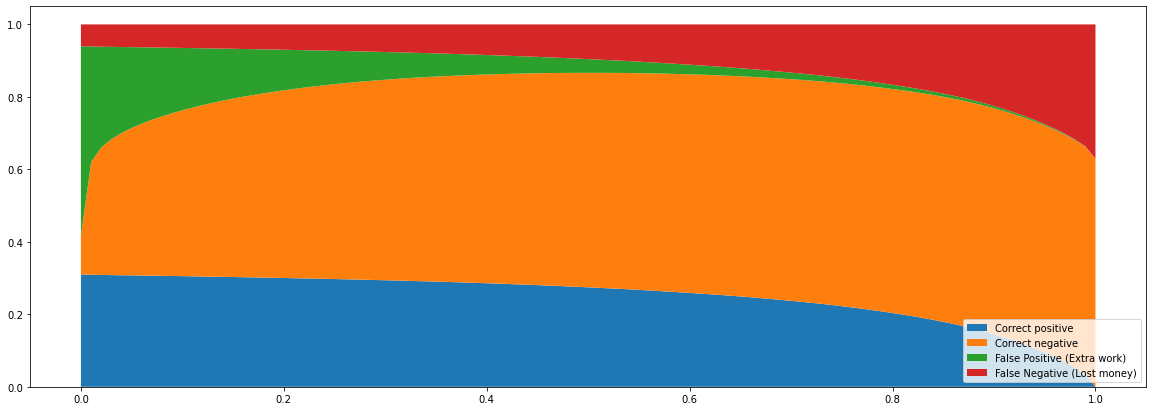

Plot thresholds for band


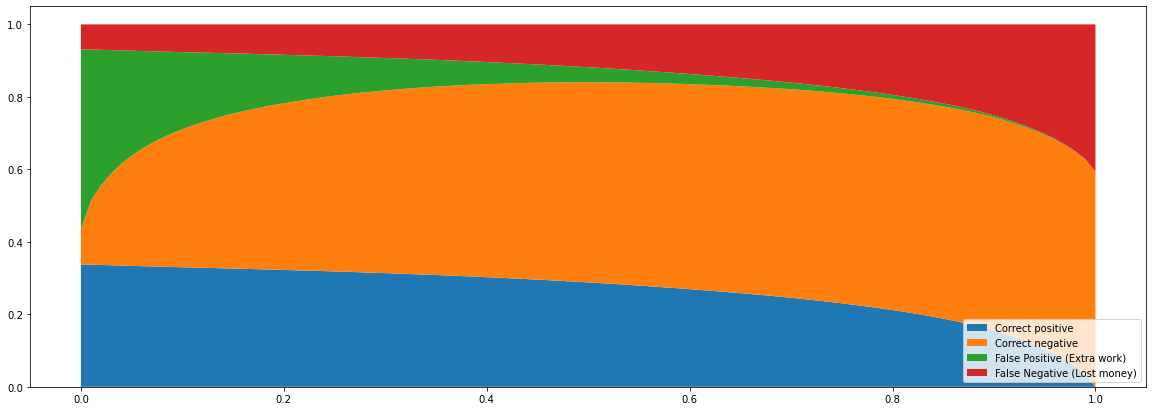

Plot thresholds for promoter


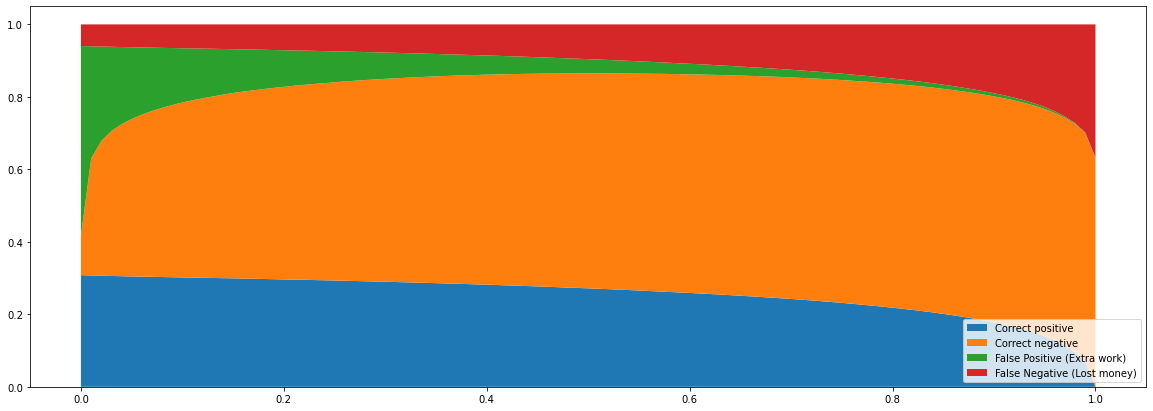

Plot thresholds for location_band


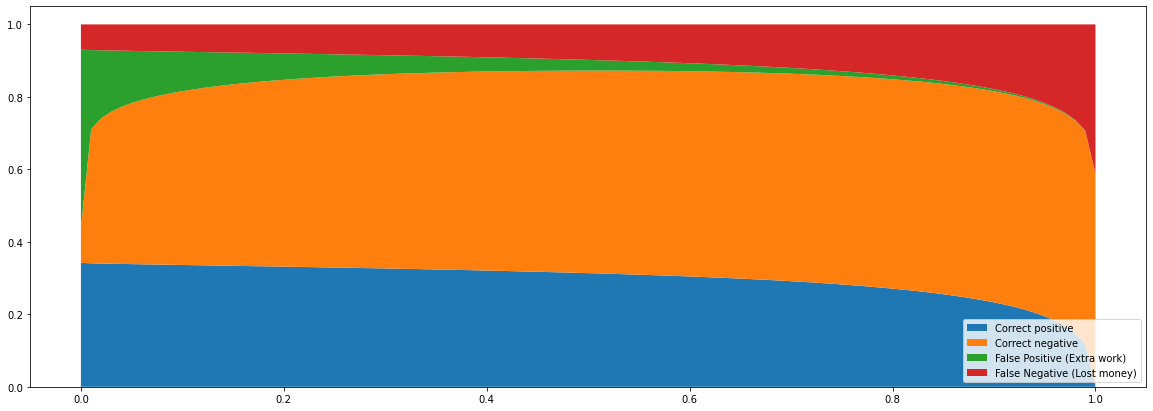

Plot thresholds for location_promoter


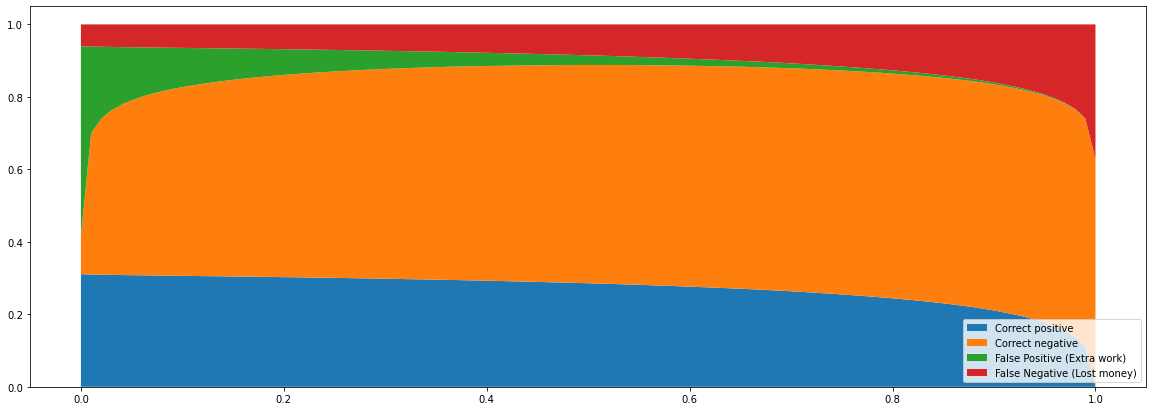

Plot thresholds for band_promoter


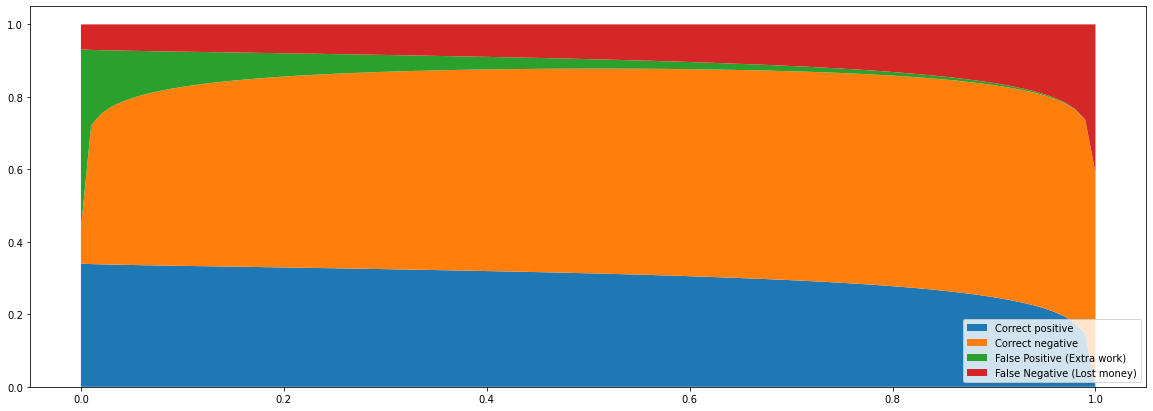

Plot thresholds for location_band_promoter


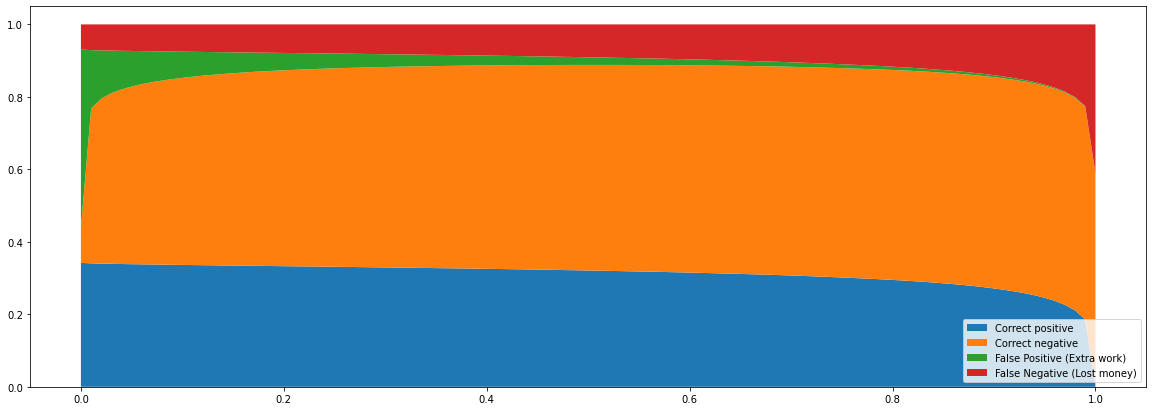

In [50]:
def create_conf_matrix_clf1(t_neg, model_name):
    df_dict[model_name]['y_pred_clf1']=df_dict[model_name]['y_pred_proba_clf1'].apply(lambda x: 1 if x >= t_neg else 0) 
    df_confusion_clf1 = pd.DataFrame(confusion_matrix(df_dict[model_name].y_clf1, df_dict[model_name].y_pred_clf1), index=['true neg (2,3)', 'true pos (4+)'], columns=['pred. neg (2,3)', 'pred. pos (4+)'])

    return df_confusion_clf1


for feature_group_combination in feature_group_combinations:
    model_name="_".join(feature_group_combination)
    print('Plot thresholds for {}'.format(model_name))
    
    correct_positive=[]
    correct_negative=[]
    false_positive=[]
    false_negative=[]

    for v in np.linspace(0, 1, 100):
        result = create_conf_matrix_clf1(v, model_name)

        correct_positive.append(result.iloc[1,1]/df_dict[model_name].shape[0])
        correct_negative.append(result.iloc[0,0]/df_dict[model_name].shape[0])
        false_positive.append(result.iloc[0,1]/df_dict[model_name].shape[0])    
        false_negative.append(result.iloc[1,0]/df_dict[model_name].shape[0])

        #print('Threshold = {}'.format(v))
        #print(result)

    x=np.linspace(0, 1, 100)
    plt.figure(figsize=(20,7))


    plt.stackplot(x,correct_positive, correct_negative, false_positive, false_negative, 
                  labels=['Correct positive', 
                          'Correct negative',
                          'False Positive (Extra work)', 
                          'False Negative (Lost money)'])
    plt.legend(loc='lower right')
    plt.show()

## Threshold optimization (clf2)

Both segment 2 (negative class) and segment 3 (positive class) are equally important --> we need both t_neg and t_pos

In [ ]:
#Define Thresholds (t_neg and t_pos) We want to minimize False Negative and False Positive

max_for_clf2_list = [0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.09]
max_fdr_clf2_list = [0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.09]

opt_t_neg_list_clf2 = {}
opt_t_pos_list_clf2 = {}

classifier_thresholds_clf2={}

for feature_group_combination in feature_group_combinations:
    model_name="_".join(feature_group_combination)
    print('Optimize threshold for CLF2 for {}'.format(model_name))

    opt_t_neg_list_clf2[model_name] = pd.DataFrame()
    opt_t_pos_list_clf2[model_name] = pd.DataFrame()

    #Use only data records from seg. 2 and 3. Use all features. 
    X_train_clf2 = df_dict[model_name][~df_dict[model_name].y_clf2.isnull()][model_features[model_name]].dropna()
    #Encode segment 3 as 1 (positive class), seg. 2 as 0 (negative class)
    y_train_clf2= df_dict[model_name][~df_dict[model_name].y_clf2.isnull()].dropna(subset=model_features[model_name]).y_clf2

    for i in tqdm(range(5)):
        for train_idx, test_idx in tqdm(cv_treasholds.split(X_train_clf2, y_train_clf2), total=cv_treasholds.n_splits) : 
            clf2_models[model_name].fit(X_train_clf2.iloc[train_idx], y_train_clf2.iloc[train_idx])

            y_test_pred_proba_clf2 = clf2_models[model_name].predict_proba(X_train_clf2.iloc[test_idx])[:, 1]
            y_test_clf2 = y_train_clf2.iloc[test_idx]

            for max_for_clf2 in max_for_clf2_list :
                opt_t_neg_clf2 = 0
                opt_for_clf2 = 0
                for t_neg_clf2 in np.linspace(0, 1, 1001):
                    for_clf2 = (y_test_pred_proba_clf2[y_test_clf2 == 1] <= t_neg_clf2).sum() / (y_test_pred_proba_clf2 <= t_neg_clf2).sum()
                    if for_clf2 > max_for_clf2:
                        break
                    opt_t_neg_clf2 = t_neg_clf2
                    opt_for_clf2 = for_clf2

                print(opt_t_neg_clf2, opt_for_clf2, max_for_clf2)
                opt_t_neg_list_clf2[model_name] = opt_t_neg_list_clf2[model_name].append({"max_for_clf2": max_for_clf2, "opt_t_neg_clf2": opt_t_neg_clf2}, ignore_index=True)


            for max_fdr_clf2 in max_fdr_clf2_list :
                opt_t_pos_clf2 = 0
                opt_fdr_clf2 = 0
                for t_pos_clf2 in np.linspace(0, 1, 1001):
                    fdr_clf2 = (y_test_pred_proba_clf2[y_test_clf2 == 0] >= t_pos_clf2).sum() / (y_test_pred_proba_clf2 >= t_pos_clf2).sum()
                    opt_t_pos_clf2 = t_pos_clf2
                    opt_fdr_clf2 = fdr_clf2
                    if fdr_clf2 <= max_fdr_clf2:
                        break
                print(opt_t_pos_clf2, opt_fdr_clf2, max_fdr_clf2)
                opt_t_pos_list_clf2[model_name] = opt_t_pos_list_clf2[model_name].append({"max_fdr_clf2": max_fdr_clf2, "opt_t_pos_clf2": opt_t_pos_clf2}, ignore_index=True)

    for max_for_clf2 in max_for_clf2_list :
        print('max_for_clf2 = {}'.format(max_for_clf2))
        display(opt_t_neg_list_clf2[model_name][opt_t_neg_list_clf2[model_name].max_for_clf2==max_for_clf2].opt_t_neg_clf2.describe())

    for max_fdr_clf2 in max_fdr_clf2_list :
        print('max_fdr_clf2 = {}'.format(max_fdr_clf2))
        display(opt_t_pos_list_clf2[model_name][opt_t_pos_list_clf2[model_name].max_fdr_clf2==max_fdr_clf2].opt_t_pos_clf2.describe())

    classifier_thresholds_clf2[model_name] = pd.DataFrame()

    for max_for_clf2 in max_for_clf2_list :
        t_neg_clf2 = np.median(opt_t_neg_list_clf2[model_name][opt_t_neg_list_clf2[model_name].max_for_clf2==max_for_clf2].opt_t_neg_clf2)

        classifier_thresholds_clf2[model_name] = classifier_thresholds_clf2[model_name].append({"max_for_clf2": max_for_clf2,
            "t_neg_clf2": t_neg_clf2}, ignore_index=True)


    for max_fdr_clf2 in max_fdr_clf2_list :
        t_pos_clf2 = np.median(opt_t_pos_list_clf2[model_name][opt_t_pos_list_clf2[model_name].max_fdr_clf2==max_fdr_clf2].opt_t_pos_clf2)

        classifier_thresholds_clf2[model_name] = classifier_thresholds_clf2[model_name].append({"max_fdr_clf2": max_fdr_clf2,
            "t_pos_clf2": t_pos_clf2}, ignore_index=True)

    display(classifier_thresholds_clf2[model_name])
    
    #Save Thresholds
    classifier_thresholds_clf2[model_name].to_pickle(('./thresholds/export_thresholds_{}_clf2.pkl.bz2').format(model_name), protocol=4)


# Load Thresholds

In [ ]:
classifier_thresholds_clf1 = {}
classifier_thresholds_clf2 = {}

#Read dataframes with predictions
for feature_group_combination in feature_group_combinations:
    model_name="_".join(feature_group_combination)
    
    classifier_thresholds_clf1[model_name]=pd.read_pickle(('./thresholds/export_thresholds_{}_clf1.pkl.bz2').format(model_name))
    classifier_thresholds_clf2[model_name]=pd.read_pickle(('./thresholds/export_thresholds_{}_clf2.pkl.bz2').format(model_name))

# Create combined confusion matrix

In [17]:
max_for_clf1 = 0.03
max_for_clf2 = 0.05 #False omission rate
max_fdr_clf2 = 0.05 #False discovery rate

for feature_group_combination in feature_group_combinations:
    model_name="_".join(feature_group_combination)
    print('Create combined confusion matrix for {}'.format(model_name))

    t_neg_clf1=0.32#classifier_thresholds_clf1[model_name][classifier_thresholds_clf1[model_name].max_for_clf1==max_for_clf1].t_neg_clf1.values[0]

    t_neg_clf2=0.467#classifier_thresholds_clf2[model_name][classifier_thresholds_clf2[model_name].max_for_clf2==max_for_clf2].t_neg_clf2.values[0]
    t_pos_clf2=0.843#classifier_thresholds_clf2[model_name][classifier_thresholds_clf2[model_name].max_fdr_clf2==max_fdr_clf2].t_pos_clf2.values[0]

    df_dict[model_name]=df_dict[model_name][df_dict[model_name].test_iter.isnull()!=True]
    df_dict[model_name]['y']=df_dict[model_name].amount_segment.apply(lambda x: '2' if x==2 else ('3' if x==3 else '4+'))

    df_dict[model_name]['y_pred_clf1']=df_dict[model_name]['y_pred_proba_clf1'].apply(lambda x: '2 or 3' if x <= t_neg_clf1 else '4+')
    df_dict[model_name]['y_pred_clf2']=df_dict[model_name]['y_pred_proba_clf2'].apply(lambda x: '2' if x<=t_neg_clf2 else 
                                                    ('2?' if x<=0.5 else 
                                                     ('3?' if x<=t_pos_clf2 else '3')))

    df_dict[model_name]['y_pred']=df_dict[model_name].apply(lambda x: x['y_pred_clf1'] if x['y_pred_clf1']=='4+' else x['y_pred_clf2'], axis=1)
    
    df_confusion_comb = pd.DataFrame(confusion_matrix(df_dict[model_name].y, df_dict[model_name].y_pred, 
                                                  labels=['2','2?','3?','3','4+']), 
                                 index=['true 2', 'true 2?', 'true 3?', 'true 3', 'true 4+'], 
                                 columns=['pred 2', 'pred 2?', 'pred 3?', 'pred 3', 'pred 4+'])
    print('Abs. Numbers')
    display(df_confusion_comb.drop(index=['true 2?', 'true 3?']))
    
    df_confusion_comb = pd.DataFrame(confusion_matrix(df_dict[model_name].y, df_dict[model_name].y_pred, 
                                                  labels=['2','2?','3?','3','4+'], normalize="true"), 
                                index=['true 2', 'true 2?', 'true 3?', 'true 3', 'true 4+'], 
                                 columns=['pred 2', 'pred 2?', 'pred 3?', 'pred 3', 'pred 4+'])
    print('Rel. to true count per class in %')
    display((df_confusion_comb.drop(index=['true 2?', 'true 3?']) * 100).round(1))
    
    print('Classification Report')
    print(classification_report(df_dict[model_name].y, df_dict[model_name].y_pred, labels=['2','2?','3?','3','4+'],zero_division=0))

Create combined confusion matrix for location



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Abs. Numbers


,pred 2,pred 2?,pred 3?,pred 3,pred 4+
true 2,1022910,3707,26468,11433,30308
true 3,42925,2993,68596,297085,63136
true 4+,14206,546,8167,16854,956266


Rel. to true count per class in %


,pred 2,pred 2?,pred 3?,pred 3,pred 4+
true 2,93.4,0.3,2.4,1.0,2.8
true 3,9.0,0.6,14.4,62.6,13.3
true 4+,1.4,0.1,0.8,1.7,96.0


Classification Report
              precision    recall  f1-score   support

           2       0.95      0.93      0.94   1094826
          2?       0.00      0.00      0.00         0
          3?       0.00      0.00      0.00         0
           3       0.91      0.63      0.74    474735
          4+       0.91      0.96      0.93    996039

    accuracy                           0.89   2565600
   macro avg       0.55      0.50      0.52   2565600
weighted avg       0.93      0.89      0.90   2565600

Create combined confusion matrix for band
Abs. Numbers


,pred 2,pred 2?,pred 3?,pred 3,pred 4+
true 2,474552,1738,12707,6174,40353
true 3,27156,1474,28927,137956,44948
true 4+,17150,474,6298,8808,518740


Rel. to true count per class in %


,pred 2,pred 2?,pred 3?,pred 3,pred 4+
true 2,88.6,0.3,2.4,1.2,7.5
true 3,11.3,0.6,12.0,57.4,18.7
true 4+,3.1,0.1,1.1,1.6,94.1


Classification Report
              precision    recall  f1-score   support

           2       0.91      0.89      0.90    535524
          2?       0.00      0.00      0.00         0
          3?       0.00      0.00      0.00         0
           3       0.90      0.57      0.70    240461
          4+       0.86      0.94      0.90    551470

    accuracy                           0.85   1327455
   macro avg       0.54      0.48      0.50   1327455
weighted avg       0.89      0.85      0.86   1327455

Create combined confusion matrix for promoter
Abs. Numbers


,pred 2,pred 2?,pred 3?,pred 3,pred 4+
true 2,981087,3666,26693,11804,57451
true 3,49154,2764,53362,283891,67658
true 4+,25663,767,10991,16555,915919


Rel. to true count per class in %


,pred 2,pred 2?,pred 3?,pred 3,pred 4+
true 2,90.8,0.3,2.5,1.1,5.3
true 3,10.8,0.6,11.7,62.1,14.8
true 4+,2.6,0.1,1.1,1.7,94.4


Classification Report
              precision    recall  f1-score   support

           2       0.93      0.91      0.92   1080701
          2?       0.00      0.00      0.00         0
          3?       0.00      0.00      0.00         0
           3       0.91      0.62      0.74    456829
          4+       0.88      0.94      0.91    969895

    accuracy                           0.87   2507425
   macro avg       0.54      0.49      0.51   2507425
weighted avg       0.91      0.87      0.88   2507425

Create combined confusion matrix for location_band
Abs. Numbers


,pred 2,pred 2?,pred 3?,pred 3,pred 4+
true 2,479203,1139,10280,8258,19786
true 3,25230,1078,15760,159978,33689
true 4+,9482,290,3848,10835,521959


Rel. to true count per class in %


,pred 2,pred 2?,pred 3?,pred 3,pred 4+
true 2,92.4,0.2,2.0,1.6,3.8
true 3,10.7,0.5,6.7,67.9,14.3
true 4+,1.7,0.1,0.7,2.0,95.5


Classification Report
              precision    recall  f1-score   support

           2       0.93      0.92      0.93    518666
          2?       0.00      0.00      0.00         0
          3?       0.00      0.00      0.00         0
           3       0.89      0.68      0.77    235735
          4+       0.91      0.96      0.93    546414

    accuracy                           0.89   1300815
   macro avg       0.55      0.51      0.53   1300815
weighted avg       0.91      0.89      0.90   1300815

Create combined confusion matrix for location_promoter
Abs. Numbers


,pred 2,pred 2?,pred 3?,pred 3,pred 4+
true 2,996617,2448,18856,11633,29378
true 3,40664,2117,36933,325912,46090
true 4+,13973,504,6543,15352,928795


Rel. to true count per class in %


,pred 2,pred 2?,pred 3?,pred 3,pred 4+
true 2,94.1,0.2,1.8,1.1,2.8
true 3,9.0,0.5,8.2,72.1,10.2
true 4+,1.4,0.1,0.7,1.6,96.2


Classification Report
              precision    recall  f1-score   support

           2       0.95      0.94      0.94   1058932
          2?       0.00      0.00      0.00         0
          3?       0.00      0.00      0.00         0
           3       0.92      0.72      0.81    451716
          4+       0.92      0.96      0.94    965167

    accuracy                           0.91   2475815
   macro avg       0.56      0.52      0.54   2475815
weighted avg       0.93      0.91      0.92   2475815

Create combined confusion matrix for band_promoter
Abs. Numbers


,pred 2,pred 2?,pred 3?,pred 3,pred 4+
true 2,471306,1206,10315,7480,22180
true 3,24923,1120,15154,156477,29780
true 4+,11012,315,3702,9640,508255


Rel. to true count per class in %


,pred 2,pred 2?,pred 3?,pred 3,pred 4+
true 2,92.0,0.2,2.0,1.5,4.3
true 3,11.0,0.5,6.7,68.8,13.1
true 4+,2.1,0.1,0.7,1.8,95.4


Classification Report
              precision    recall  f1-score   support

           2       0.93      0.92      0.92    512487
          2?       0.00      0.00      0.00         0
          3?       0.00      0.00      0.00         0
           3       0.90      0.69      0.78    227454
          4+       0.91      0.95      0.93    532924

    accuracy                           0.89   1272865
   macro avg       0.55      0.51      0.53   1272865
weighted avg       0.92      0.89      0.90   1272865

Create combined confusion matrix for location_band_promoter
Abs. Numbers


,pred 2,pred 2?,pred 3?,pred 3,pred 4+
true 2,472447,903,8453,7518,15169
true 3,22369,867,12830,164150,25173
true 4+,8006,219,2900,9486,510100


Rel. to true count per class in %


,pred 2,pred 2?,pred 3?,pred 3,pred 4+
true 2,93.6,0.2,1.7,1.5,3.0
true 3,9.9,0.4,5.7,72.8,11.2
true 4+,1.5,0.0,0.5,1.8,96.1


Classification Report
              precision    recall  f1-score   support

           2       0.94      0.94      0.94    504490
          2?       0.00      0.00      0.00         0
          3?       0.00      0.00      0.00         0
           3       0.91      0.73      0.81    225389
          4+       0.93      0.96      0.94    530711

    accuracy                           0.91   1260590
   macro avg       0.55      0.53      0.54   1260590
weighted avg       0.93      0.91      0.92   1260590



In [18]:
for feature_group_combination in feature_group_combinations:
    model_name="_".join(feature_group_combination)
    print('Make prediction for {}'.format(model_name))
    
    df_dict[model_name]['predicted_segment'] = df_dict[model_name].y_pred.map({
    '2': '2',
    '2?': '2',
    '3': '3',
    '3?': '3',
    '4+': '4+'
    })
    
    df_dict[model_name]['segment']=df_dict[model_name].amount_segment.map({2:'2', 3: '3', 
                                                                 4: '4+',5: '4+',6: '4+',7: '4+',8: '4+',
                                                                9: '4+', 10: '4+',11: '4+',12: '4+'})
    
    cm = pd.DataFrame(confusion_matrix(df_dict[model_name].segment, df_dict[model_name].predicted_segment, labels=['2', '3', '4+']),
                  index=['true 2', 'true 3', 'true 4+'],
                  columns=['pred 2', 'pred 3', 'pred 4+'])

    display(cm)
    
    cm_norm = pd.DataFrame(confusion_matrix(df_dict[model_name].segment, df_dict[model_name].predicted_segment, labels=['2', '3', '4+'], normalize='true'),
                  index=['true 2', 'true 3', 'true 4+'],
                  columns=['pred 2', 'pred 3', 'pred 4+'])

    display(cm_norm)
    
    print(classification_report(df_dict[model_name].segment, df_dict[model_name].predicted_segment, target_names=['2', '3', '4']))

Make prediction for location



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,pred 2,pred 3,pred 4+
true 2,1026617,37901,30308
true 3,45918,365681,63136
true 4+,14752,25021,956266


,pred 2,pred 3,pred 4+
true 2,0.937699,0.034618,0.027683
true 3,0.096723,0.770284,0.132992
true 4+,0.014811,0.025121,0.960069


              precision    recall  f1-score   support

           2       0.94      0.94      0.94   1094826
           3       0.85      0.77      0.81    474735
           4       0.91      0.96      0.93    996039

    accuracy                           0.92   2565600
   macro avg       0.90      0.89      0.90   2565600
weighted avg       0.91      0.92      0.91   2565600

Make prediction for band


,pred 2,pred 3,pred 4+
true 2,476290,18881,40353
true 3,28630,166883,44948
true 4+,17624,15106,518740


,pred 2,pred 3,pred 4+
true 2,0.889391,0.035257,0.075352
true 3,0.119063,0.694013,0.186924
true 4+,0.031958,0.027392,0.940650


              precision    recall  f1-score   support

           2       0.91      0.89      0.90    535524
           3       0.83      0.69      0.76    240461
           4       0.86      0.94      0.90    551470

    accuracy                           0.88   1327455
   macro avg       0.87      0.84      0.85   1327455
weighted avg       0.87      0.88      0.87   1327455

Make prediction for promoter


,pred 2,pred 3,pred 4+
true 2,984753,38497,57451
true 3,51918,337253,67658
true 4+,26430,27546,915919


,pred 2,pred 3,pred 4+
true 2,0.911217,0.035622,0.053161
true 3,0.113649,0.738248,0.148104
true 4+,0.027250,0.028401,0.944349


              precision    recall  f1-score   support

           2       0.93      0.91      0.92   1080701
           3       0.84      0.74      0.78    456829
           4       0.88      0.94      0.91    969895

    accuracy                           0.89   2507425
   macro avg       0.88      0.86      0.87   2507425
weighted avg       0.89      0.89      0.89   2507425

Make prediction for location_band


,pred 2,pred 3,pred 4+
true 2,480342,18538,19786
true 3,26308,175738,33689
true 4+,9772,14683,521959


,pred 2,pred 3,pred 4+
true 2,0.926110,0.035742,0.038148
true 3,0.111600,0.745490,0.142910
true 4+,0.017884,0.026872,0.955245


              precision    recall  f1-score   support

           2       0.93      0.93      0.93    518666
           3       0.84      0.75      0.79    235735
           4       0.91      0.96      0.93    546414

    accuracy                           0.91   1300815
   macro avg       0.89      0.88      0.88   1300815
weighted avg       0.90      0.91      0.90   1300815

Make prediction for location_promoter


,pred 2,pred 3,pred 4+
true 2,999065,30489,29378
true 3,42781,362845,46090
true 4+,14477,21895,928795


,pred 2,pred 3,pred 4+
true 2,0.943465,0.028792,0.027743
true 3,0.094708,0.803259,0.102033
true 4+,0.014999,0.022685,0.962315


              precision    recall  f1-score   support

           2       0.95      0.94      0.94   1058932
           3       0.87      0.80      0.84    451716
           4       0.92      0.96      0.94    965167

    accuracy                           0.93   2475815
   macro avg       0.91      0.90      0.91   2475815
weighted avg       0.92      0.93      0.92   2475815

Make prediction for band_promoter


,pred 2,pred 3,pred 4+
true 2,472512,17795,22180
true 3,26043,171631,29780
true 4+,11327,13342,508255


,pred 2,pred 3,pred 4+
true 2,0.921998,0.034723,0.043279
true 3,0.114498,0.754575,0.130928
true 4+,0.021254,0.025035,0.953710


              precision    recall  f1-score   support

           2       0.93      0.92      0.92    512487
           3       0.85      0.75      0.80    227454
           4       0.91      0.95      0.93    532924

    accuracy                           0.91   1272865
   macro avg       0.89      0.88      0.88   1272865
weighted avg       0.90      0.91      0.90   1272865

Make prediction for location_band_promoter


,pred 2,pred 3,pred 4+
true 2,473350,15971,15169
true 3,23236,176980,25173
true 4+,8225,12386,510100


,pred 2,pred 3,pred 4+
true 2,0.938274,0.031658,0.030068
true 3,0.103093,0.785220,0.111687
true 4+,0.015498,0.023339,0.961163


              precision    recall  f1-score   support

           2       0.94      0.94      0.94    504490
           3       0.86      0.79      0.82    225389
           4       0.93      0.96      0.94    530711

    accuracy                           0.92   1260590
   macro avg       0.91      0.89      0.90   1260590
weighted avg       0.92      0.92      0.92   1260590



# Get scores for regressions (with correct class)

In [38]:
for feature_group_combination in feature_group_combinations:
    model_name="_".join(feature_group_combination)
    print(df_dict[model_name].shape)

(3078724, 73)
(1592951, 73)
(3008913, 43)
(1560978, 127)
(2970981, 97)
(1527443, 97)
(1512712, 151)


In [39]:
df_dict['location'][(df_dict['location'].amount_segment==2)&(df_dict['location'].test_iter>0)].head()

,vg_datum_year,vg_datum_month,vg_datum_day_of_week,location_count,location_mean,location_std,location_min,location_5%,location_10%,location_15%,location_20%,location_25%,location_30%,location_35%,location_40%,location_45%,location_50%,location_55%,location_60%,location_65%,location_70%,location_75%,location_80%,location_85%,location_90%,location_95%,location_max,location_kirche,location_hotel,location_theater,location_cafe,location_stadthalle,location_buergerhaus,location_club,location_gaststaette,location_halle,location_festhalle,location_kurhaus,location_schloss,location_restaurant,location_kulturzentrum,location_festzelt,location_musikschule,location_mehrzweckhalle,location_pub,location_bar,location_gasthaus,location_turnhalle,location_kulturhaus,location_gymnasium,location_rathaus,location_gasthof,location_park,location_kabarett,location_schuetzenhalle,location_gemeindehalle,location_gemeindehaus,amount,amount_segment,y_clf1,y_clf2,y_pred_proba_clf1,y_pred_proba_clf2,y_pred_reg2,y_pred_reg2_logit,y_pred_reg3,y_pred_reg3_logit,train_iter,test_iter,y,y_pred_clf1,y_pred_clf2,y_pred
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11212508,2014,7,5,72.0,13.523472,1.871654,11.02,11.0200,11.02,11.020,11.020,11.02,12.699,13.77,13.770,13.7700,13.77,13.7700,13.77,13.770,13.770,13.7700,16.000,16.00,16.00,16.000,16.80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13.77,2.0,0,0.0,0.000593,0.000898,12.088251,12.790899,65.059692,60.692284,4.0,1.0,2,2 or 3,2,2
11212509,2014,11,5,25.0,344.942800,407.581001,17.84,17.8400,17.84,17.840,18.032,18.08,35.024,55.44,57.126,58.2500,84.96,86.2080,91.20,562.386,876.510,876.5100,876.510,876.51,876.51,876.510,876.51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29.92,2.0,0,0.0,0.049455,0.819821,18.946707,14.703510,58.561398,59.075768,4.0,1.0,2,2 or 3,3,3
11212510,2014,10,5,200.0,466.187900,423.646603,18.84,68.7155,124.34,131.438,149.228,182.04,193.630,198.22,300.000,354.5235,365.06,422.8445,482.44,491.160,535.847,629.2325,680.452,837.66,903.18,1113.108,3253.34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46.85,2.0,0,0.0,0.864655,0.566612,34.639648,43.638901,72.703918,77.844948,4.0,1.0,2,4+,3?,4+
11212511,2014,7,2,5.0,12.240000,0.000000,12.24,12.2400,12.24,12.240,12.240,12.24,12.240,12.24,12.240,12.2400,12.24,12.2400,12.24,12.240,12.240,12.2400,12.240,12.24,12.24,12.240,12.24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.24,2.0,0,0.0,0.002816,0.002406,12.218128,12.425817,67.809456,61.540344,4.0,1.0,2,2 or 3,2,2
11212512,2014,7,4,33.0,118.581818,77.155493,12.24,12.2400,12.24,12.240,16.000,16.00,78.820,118.71,121.070,121.3900,125.00,130.5560,135.32,135.320,182.720,182.7200,193.196,200.18,200.18,221.924,254.54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.24,2.0,0,0.0,0.139549,0.035206,14.792560,15.332224,78.004875,79.021019,4.0,1.0,2,2 or 3,2,2


Regression score for location


,min,mean,max
reg2,-41.0332,-0.110963,370.367
reg2_abs,4.57764e-07,3.85789,370.367
reg2_logit,-40.8995,-0.860225,366.822
reg2_logit_abs,4.57764e-06,3.99334,366.822
reg3,-64.45,0.116191,48.4534
reg3_abs,0,6.16922,64.45
reg3_logit,-68.6414,0.356633,48.8445
reg3_logit_abs,1.37329e-05,6.20206,68.6414


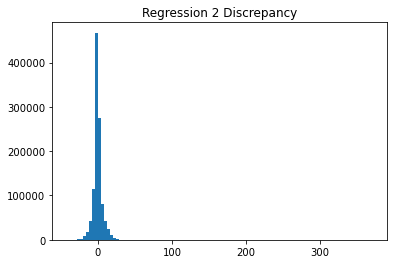

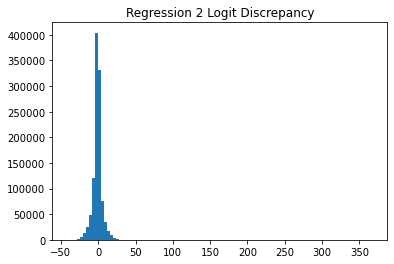

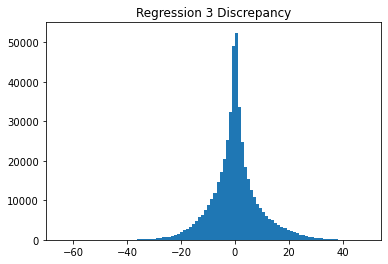

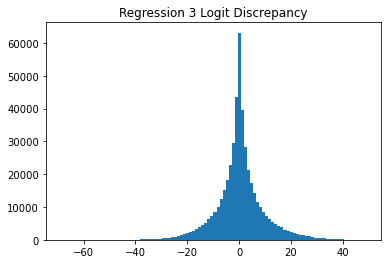

Regression score for band


,min,mean,max
reg2,-44.7851,-0.118109,383.618
reg2_abs,4.11987e-06,4.39912,383.618
reg2_logit,-42.46,-0.948366,386.374
reg2_logit_abs,3.66211e-06,4.55466,386.374
reg3,-55.95,0.0129895,58.8423
reg3_abs,0.000111694,6.94712,58.8423
reg3_logit,-53.3697,0.311456,48.8779
reg3_logit_abs,4.39453e-05,7.03749,53.3697


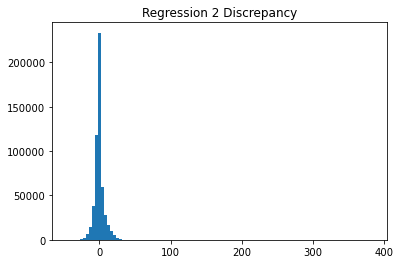

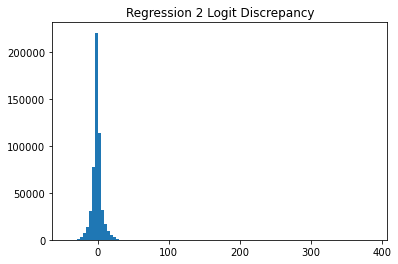

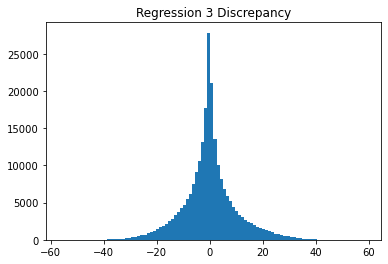

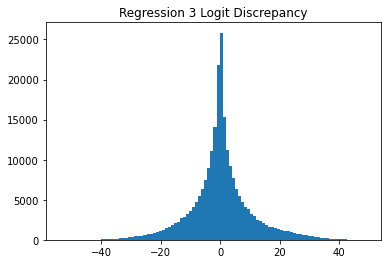

Regression score for promoter


,min,mean,max
reg2,-43.0091,-0.291378,369.549
reg2_abs,4.57764e-07,3.81913,369.549
reg2_logit,-45.5928,-0.957593,374.761
reg2_logit_abs,9.15527e-07,3.97189,374.761
reg3,-72.1772,-0.0208801,51.8564
reg3_abs,1.31226e-05,5.72336,72.1772
reg3_logit,-65.2847,0.294519,49.4159
reg3_logit_abs,1.98364e-06,5.77381,65.2847


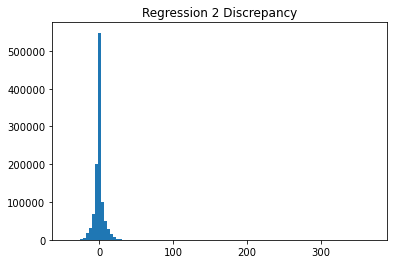

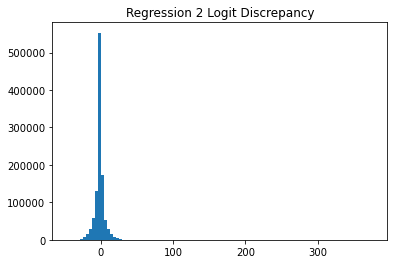

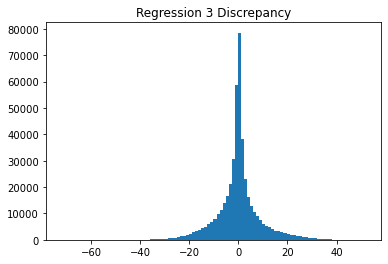

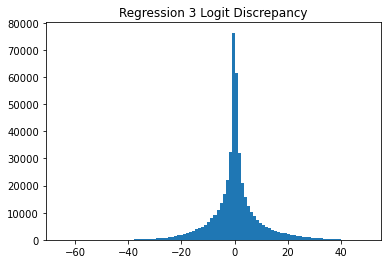

Regression score for location_band


,min,mean,max
reg2,-39.3352,-0.130661,383.015
reg2_abs,4.57764e-07,3.53225,383.015
reg2_logit,-42.6258,-0.770624,385.542
reg2_logit_abs,9.15527e-07,3.72006,385.542
reg3,-62.7074,0.0756319,48.7072
reg3_abs,1.83105e-06,6.00238,62.7074
reg3_logit,-63.0563,0.205558,47.8095
reg3_logit_abs,2.44141e-05,6.08881,63.0563


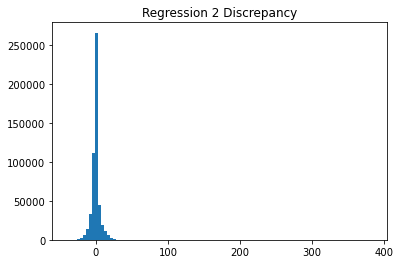

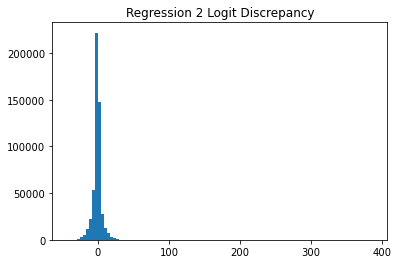

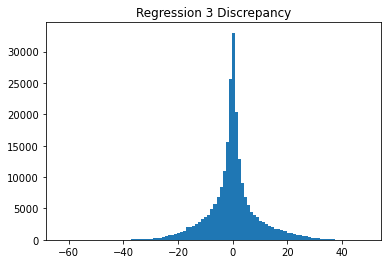

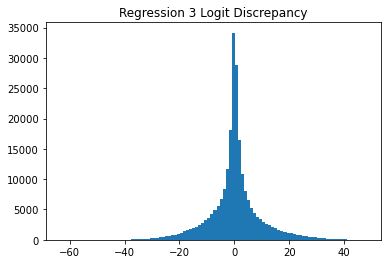

Regression score for location_promoter


,min,mean,max
reg2,-41.5712,-0.255502,378.551
reg2_abs,1.75476e-06,3.39813,378.551
reg2_logit,-36.9524,-0.940448,370.458
reg2_logit_abs,2.44141e-06,3.57993,370.458
reg3,-77.3161,-0.0198766,50.7059
reg3_abs,5.49316e-06,5.21309,77.3161
reg3_logit,-74.9306,0.210705,49.1748
reg3_logit_abs,3.50952e-06,5.2514,74.9306


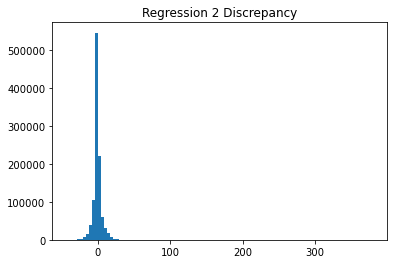

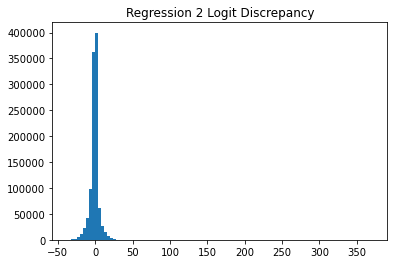

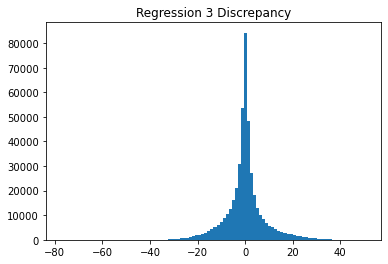

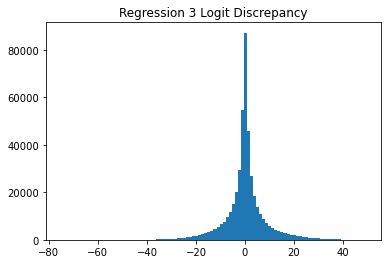

Regression score for band_promoter


,min,mean,max
reg2,-41.518,-0.221798,385.217
reg2_abs,4.95911e-07,3.5029,385.217
reg2_logit,-40.2353,-0.846016,379.855
reg2_logit_abs,1.52588e-06,3.67221,379.855
reg3,-74.6611,-0.0299895,54.6008
reg3_abs,2.04468e-05,5.55022,74.6611
reg3_logit,-73.9157,0.213626,48.6203
reg3_logit_abs,3.05176e-06,5.64156,73.9157


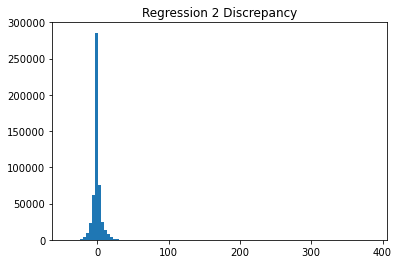

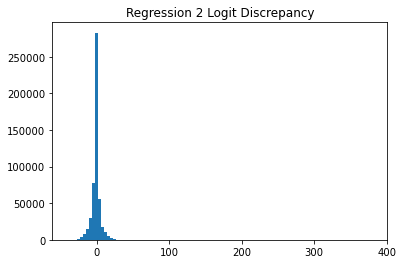

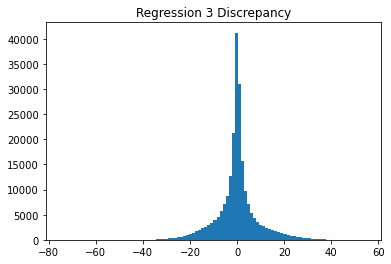

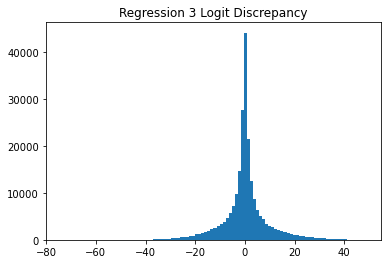

Regression score for location_band_promoter


,min,mean,max
reg2,-41.0206,-0.197848,382.2
reg2_abs,8.35419e-06,3.23287,382.2
reg2_logit,-41.6484,-0.826985,380.215
reg2_logit_abs,6.56128e-06,3.45195,380.215
reg3,-77.4182,-0.0774313,53.0836
reg3_abs,2.74658e-05,5.29223,77.4182
reg3_logit,-67.6973,0.133996,49.1687
reg3_logit_abs,6.10352e-06,5.37747,67.6973


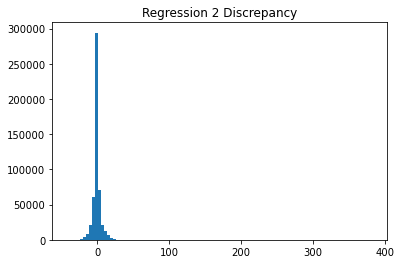

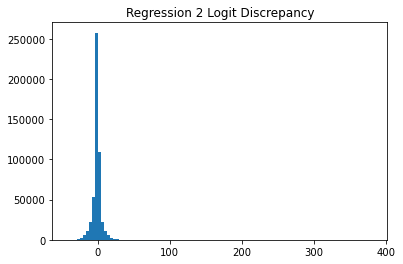

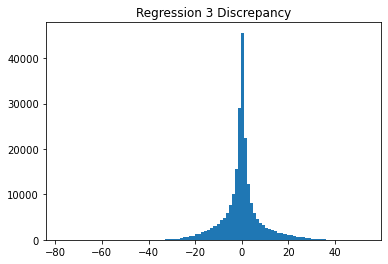

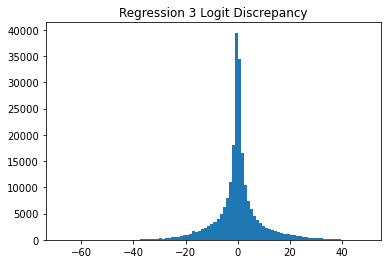

In [28]:
for feature_group_combination in feature_group_combinations:
    model_name="_".join(feature_group_combination)
    print('Regression score for {}'.format(model_name))
    
    df_reg2 = df_dict[model_name][df_dict[model_name].amount_segment==2].copy()
    df_reg2['discr'] = df_reg2.amount-df_reg2.y_pred_reg2
    df_reg2['discr_abs'] = abs(df_reg2.amount-df_reg2.y_pred_reg2)
    df_reg2['discr_logit'] = df_reg2.amount-df_reg2.y_pred_reg2_logit
    df_reg2['discr_logit_abs'] = abs(df_reg2.amount-df_reg2.y_pred_reg2_logit)

    df_reg3 = df_dict[model_name][df_dict[model_name].amount_segment==3].copy()
    df_reg3['discr'] = df_reg3.amount-df_reg3.y_pred_reg3
    df_reg3['discr_abs'] = abs(df_reg3.amount-df_reg3.y_pred_reg3)
    df_reg3['discr_logit'] = df_reg3.amount-df_reg3.y_pred_reg3_logit
    df_reg3['discr_logit_abs'] = abs(df_reg3.amount-df_reg3.y_pred_reg3_logit)

    scores = pd.DataFrame(columns=('min', 'mean', 'max'), 
                          index=('reg2','reg2_abs', 'reg2_logit', 'reg2_logit_abs', 
                                 'reg3','reg3_abs', 'reg3_logit', 'reg3_logit_abs'))
    scores.loc['reg2']=[np.min(df_reg2.discr), np.mean(df_reg2.discr), np.max(df_reg2.discr)]
    scores.loc['reg2_abs']=[np.min(df_reg2.discr_abs), np.mean(df_reg2.discr_abs), np.max(df_reg2.discr_abs)]
    scores.loc['reg2_logit']=[np.min(df_reg2.discr_logit), np.mean(df_reg2.discr_logit), np.max(df_reg2.discr_logit)]
    scores.loc['reg2_logit_abs']=[np.min(df_reg2.discr_logit_abs), np.mean(df_reg2.discr_logit_abs), np.max(df_reg2.discr_logit_abs)]
    scores.loc['reg3']=[np.min(df_reg3.discr), np.mean(df_reg3.discr), np.max(df_reg3.discr)]
    scores.loc['reg3_abs']=[np.min(df_reg3.discr_abs), np.mean(df_reg3.discr_abs), np.max(df_reg3.discr_abs)]
    scores.loc['reg3_logit']=[np.min(df_reg3.discr_logit), np.mean(df_reg3.discr_logit), np.max(df_reg3.discr_logit)]
    scores.loc['reg3_logit_abs']=[np.min(df_reg3.discr_logit_abs), np.mean(df_reg3.discr_logit_abs), np.max(df_reg3.discr_logit_abs)]

    display(scores)
    
    plt.hist(df_reg2.discr, bins=100)
    plt.title('Regression 2 Discrepancy')
    plt.show()
    plt.hist(df_reg2.discr_logit, bins=100)
    plt.title('Regression 2 Logit Discrepancy')
    plt.show()

    plt.hist(df_reg3.discr, bins=100)
    plt.title('Regression 3 Discrepancy')
    plt.show()
    plt.hist(df_reg3.discr_logit, bins=100)
    plt.title('Regression 3 Logit Discrepancy')
    plt.show()

# Regression Segment 2 and 3 (Review combined result)

## Calculate discrepancy

Keep Regression results only for correct classes (reg2 for '2' and '2?', reg3 for '3' and '3?')

Combined regression score for location
Only for classes 2 and 3


,min,mean,max
reg2,-38.7297,28.318,943671
reg2_abs,4.57764e-07,31.8623,943671
reg2_logit,-37.6268,27.5765,943665
reg2_logit_abs,4.57764e-06,31.8891,943665
reg3,-87.1123,99.4196,1.02951e+06
reg3_abs,0,106.763,1.02951e+06
reg3_logit,-84.8434,99.5661,1.02951e+06
reg3_logit_abs,1.37329e-05,106.742,1.02951e+06


For classes 2, 2?,3? and 3


,min,mean,max
reg2,-38.7297,28.318,943671
reg2_abs,4.57764e-07,31.8623,943671
reg2_logit,-37.6268,27.5765,943665
reg2_logit_abs,4.57764e-06,31.8891,943665
reg3,-90.654,86.1662,1.02951e+06
reg3_abs,0,96.1673,1.02951e+06
reg3_logit,-84.8434,86.4059,1.02951e+06
reg3_logit_abs,1.37329e-05,96.0955,1.02951e+06


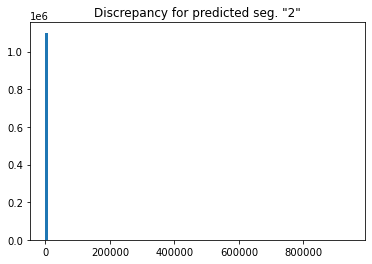

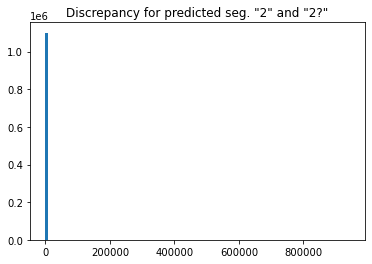

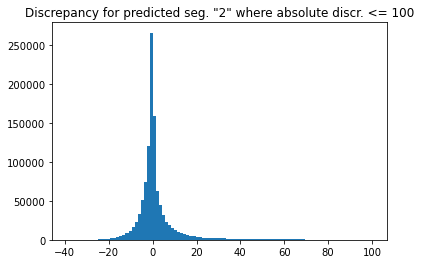

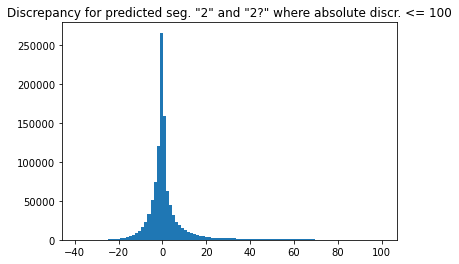

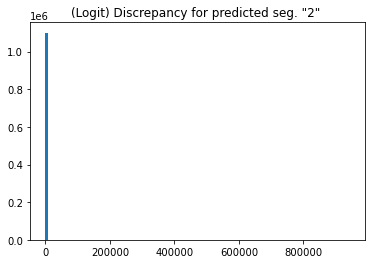

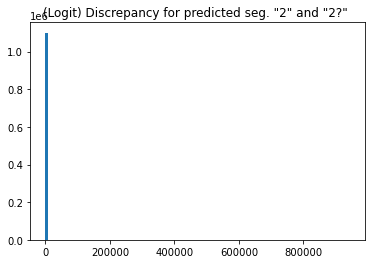

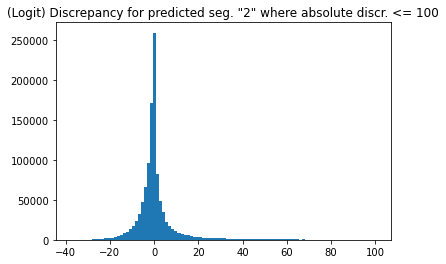

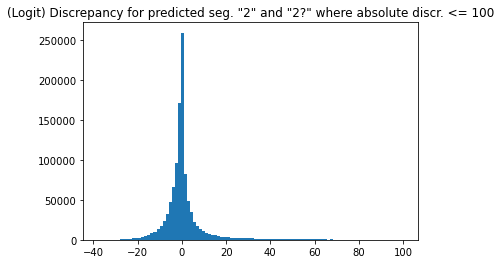

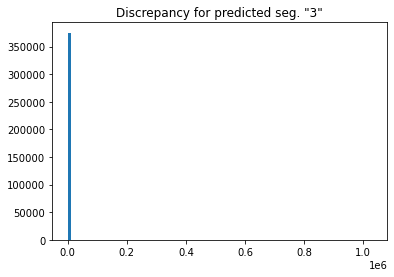

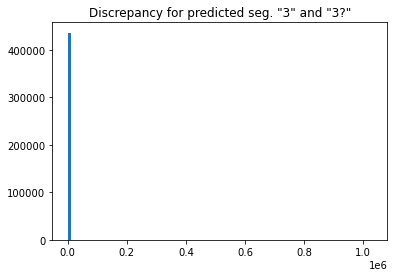

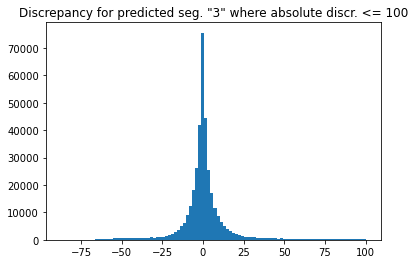

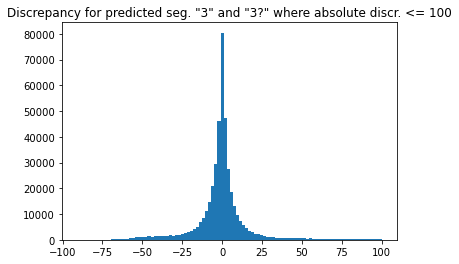

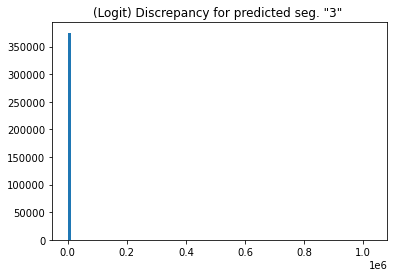

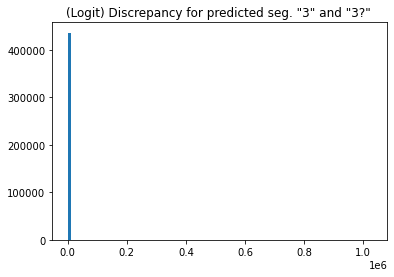

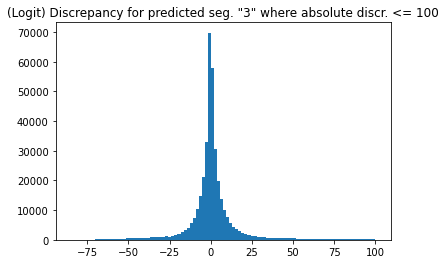

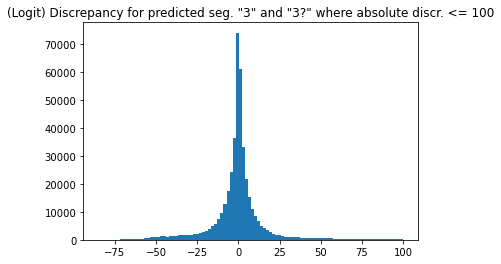

Combined regression score for band
Only for classes 2 and 3


,min,mean,max
reg2,-36.1207,54.9575,792342
reg2_abs,1.8158e-05,58.692,792342
reg2_logit,-35.6655,54.2559,792343
reg2_logit_abs,3.66211e-06,58.78,792343
reg3,-87.0957,24.9649,326109
reg3_abs,0.000128174,31.1571,326109
reg3_logit,-83.8318,25.1691,326109
reg3_logit_abs,4.39453e-05,31.1405,326109


For classes 2, 2?,3? and 3


,min,mean,max
reg2,-36.5042,60.7175,792342
reg2_abs,1.8158e-05,64.4445,792342
reg2_logit,-36.6462,59.9622,792343
reg2_logit_abs,3.66211e-06,64.4833,792343
reg3,-87.0957,46.5186,775126
reg3_abs,0.000128174,56.8886,775126
reg3_logit,-83.8318,46.8544,775133
reg3_logit_abs,4.39453e-05,56.7987,775133


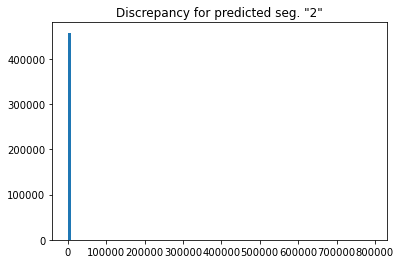

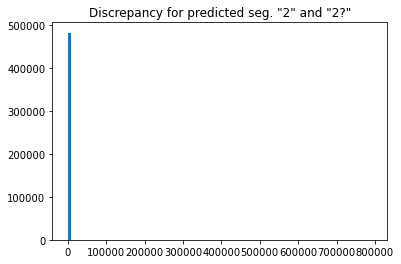

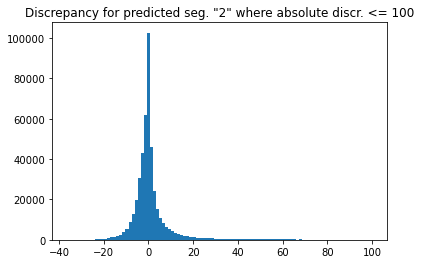

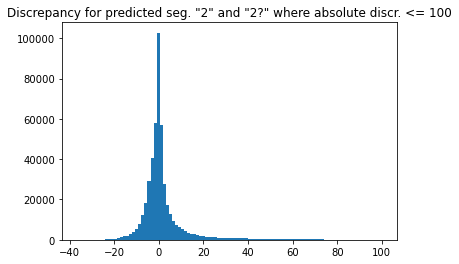

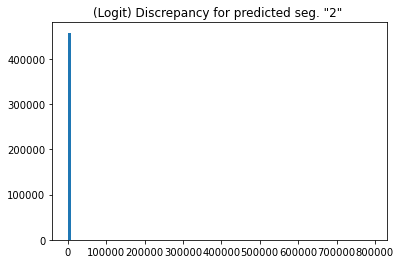

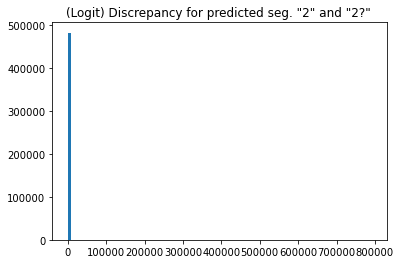

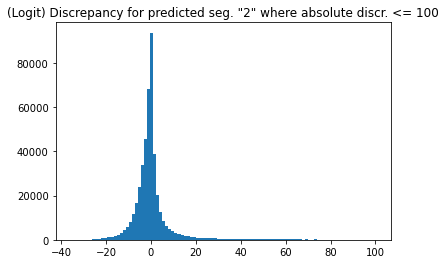

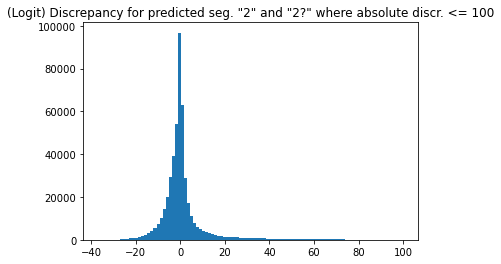

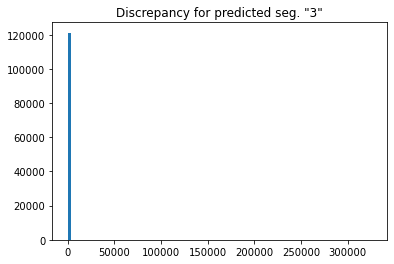

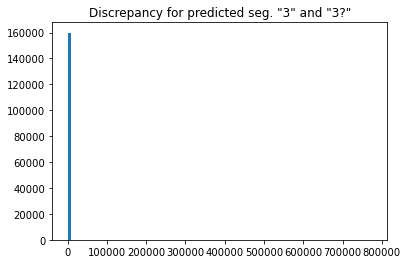

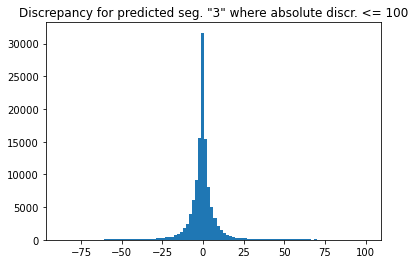

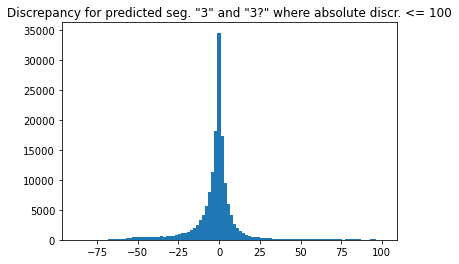

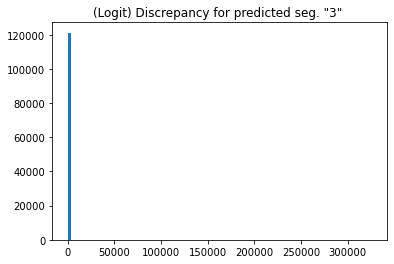

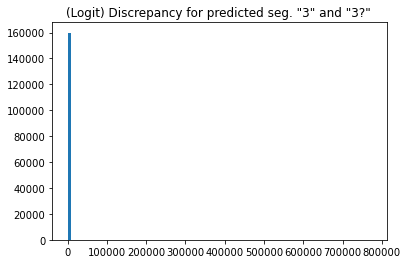

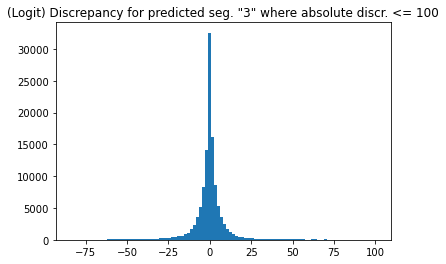

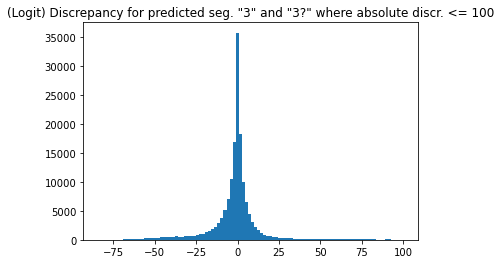

Combined regression score for promoter
Only for classes 2 and 3


,min,mean,max
reg2,-43.0091,10.1934,124398
reg2_abs,4.57764e-07,13.5311,124398
reg2_logit,-45.5928,9.62611,124391
reg2_logit_abs,9.15527e-07,13.5954,124391
reg3,-84.1245,13.349,53543.8
reg3_abs,1.31226e-05,19.1568,53543.8
reg3_logit,-84.0331,13.5133,53540.1
reg3_logit_abs,1.98364e-06,19.1447,53540.1


For classes 2, 2?,3? and 3


,min,mean,max
reg2,-43.0091,11.2724,124398
reg2_abs,4.57764e-07,14.6383,124398
reg2_logit,-45.5928,10.6638,124391
reg2_logit_abs,9.15527e-07,14.6711,124391
reg3,-84.1245,13.0404,53543.8
reg3_abs,1.31226e-05,23.463,53543.8
reg3_logit,-84.0331,13.3351,53540.1
reg3_logit_abs,1.98364e-06,23.3809,53540.1


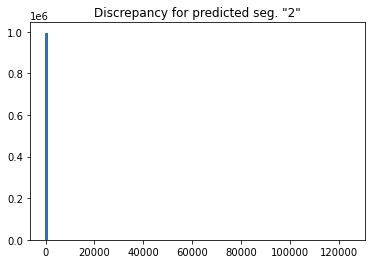

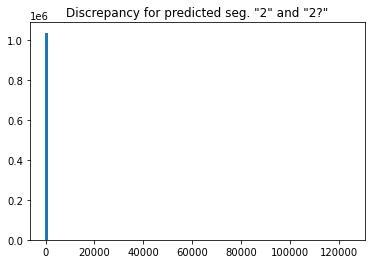

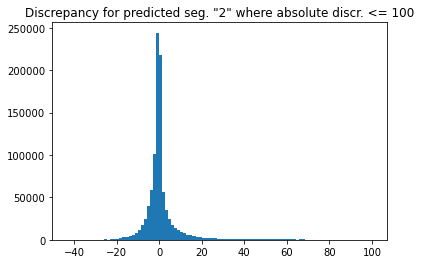

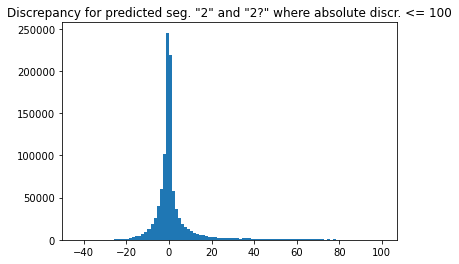

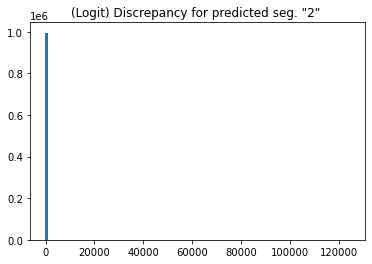

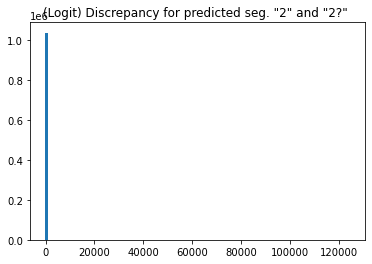

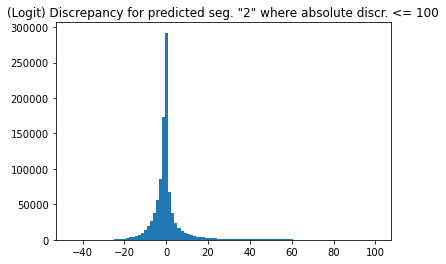

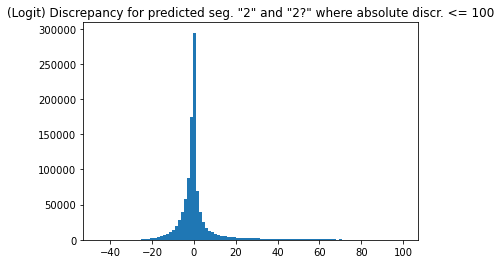

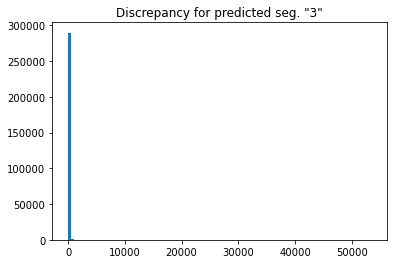

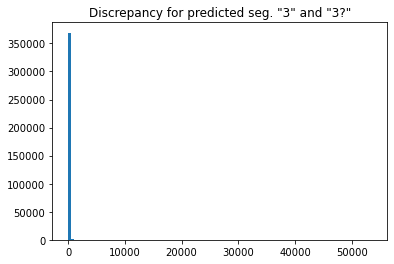

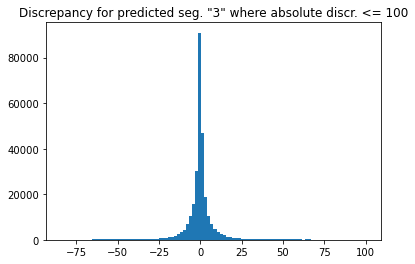

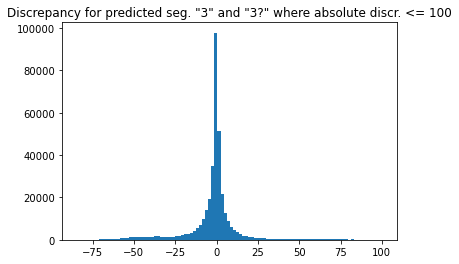

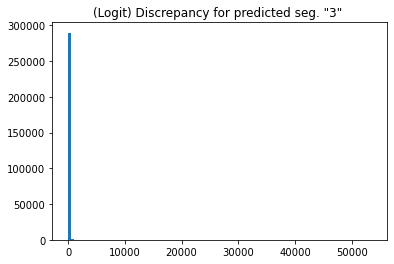

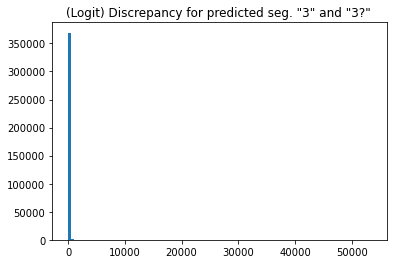

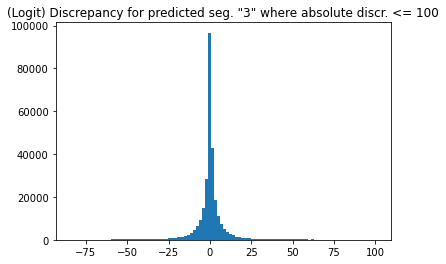

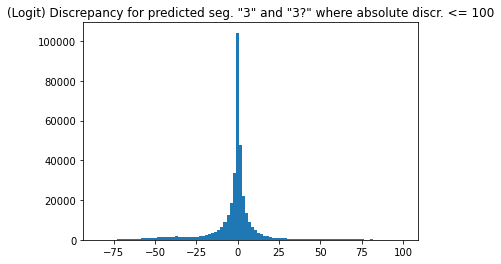

Combined regression score for location_band
Only for classes 2 and 3


,min,mean,max
reg2,-38.2807,10.9198,303284
reg2_abs,4.57764e-07,14.004,303284
reg2_logit,-34.4376,10.3538,303279
reg2_logit_abs,9.15527e-07,14.0977,303279
reg3,-81.843,10.727,565353
reg3_abs,1.83105e-06,16.9776,565353
reg3_logit,-84.7535,10.7944,565361
reg3_logit_abs,2.44141e-05,16.9816,565361


For classes 2, 2?,3? and 3


,min,mean,max
reg2,-38.2807,11.8778,303284
reg2_abs,4.57764e-07,14.9753,303284
reg2_logit,-35.3715,11.2842,303279
reg2_logit_abs,9.15527e-07,15.0486,303279
reg3,-92.2416,11.2421,565353
reg3_abs,1.83105e-06,21.177,565353
reg3_logit,-84.7535,11.4106,565361
reg3_logit_abs,2.44141e-05,21.1489,565361


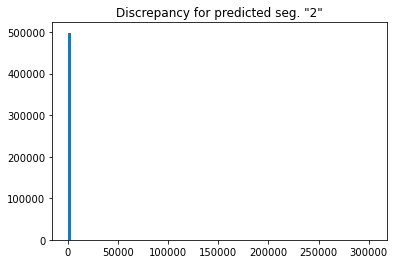

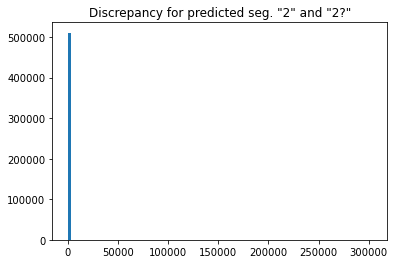

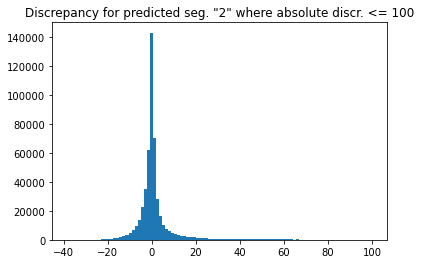

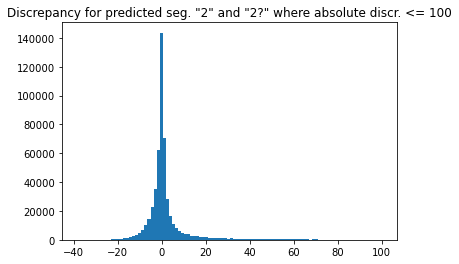

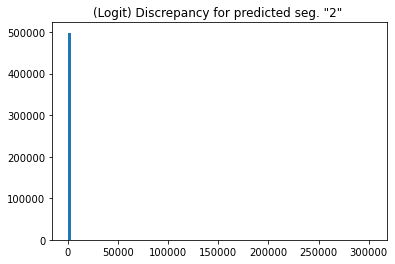

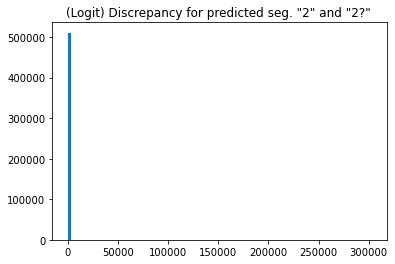

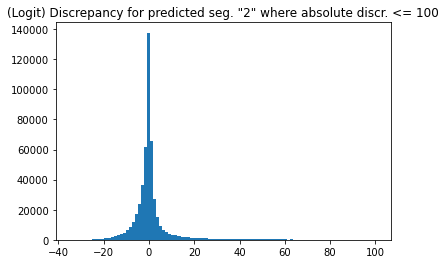

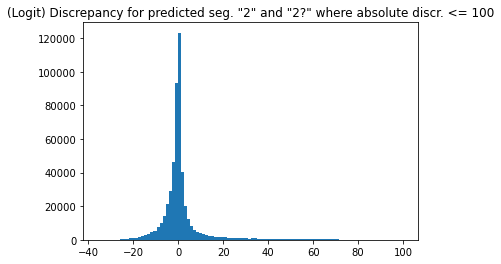

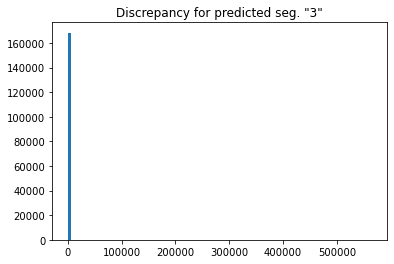

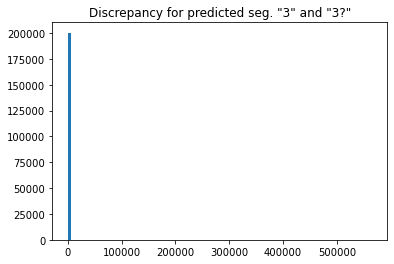

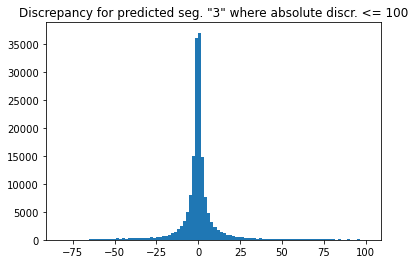

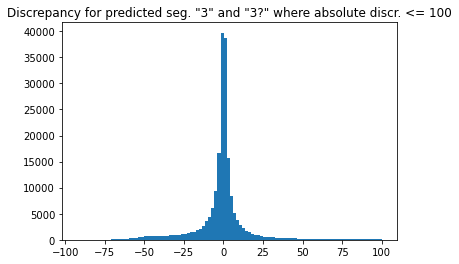

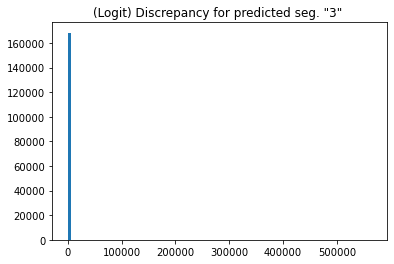

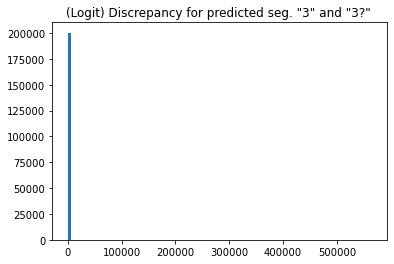

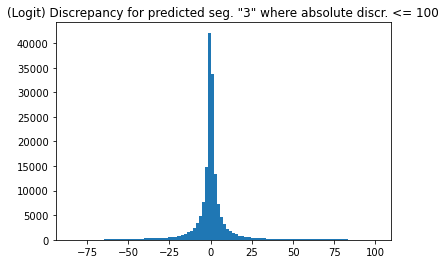

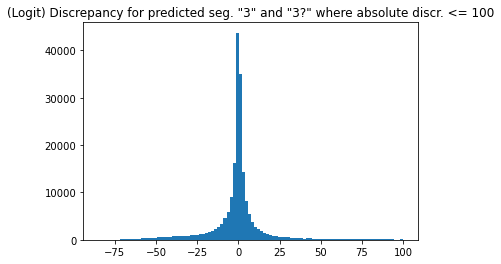

Combined regression score for location_promoter
Only for classes 2 and 3


,min,mean,max
reg2,-41.5712,7.20067,25623
reg2_abs,1.75476e-06,10.4356,25623
reg2_logit,-36.9524,6.51585,25615.5
reg2_logit_abs,2.44141e-06,10.4983,25615.5
reg3,-89.5476,6.50788,13262
reg3_abs,5.49316e-06,13.2308,13262
reg3_logit,-85.6112,6.64329,13255.6
reg3_logit_abs,3.50952e-06,13.2184,13255.6


For classes 2, 2?,3? and 3


,min,mean,max
reg2,-41.5712,7.20067,25623
reg2_abs,1.75476e-06,10.4356,25623
reg2_logit,-36.9524,6.51585,25615.5
reg2_logit_abs,2.44141e-06,10.4983,25615.5
reg3,-89.5476,6.42773,13262
reg3_abs,5.49316e-06,14.9217,13262
reg3_logit,-85.6112,6.61655,13255.6
reg3_logit_abs,3.50952e-06,14.8896,13255.6


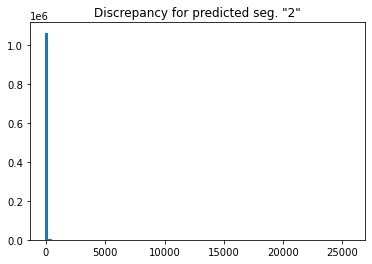

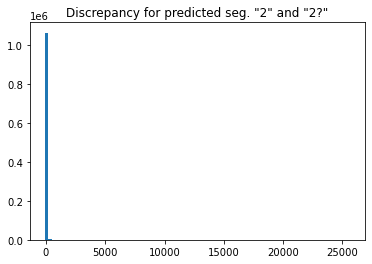

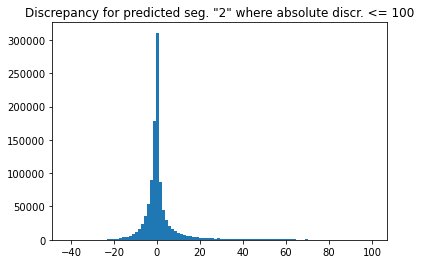

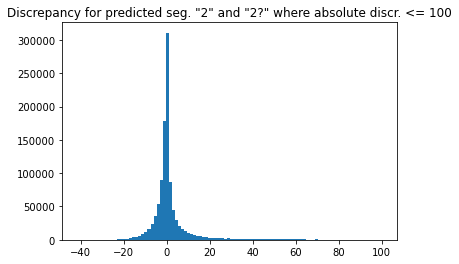

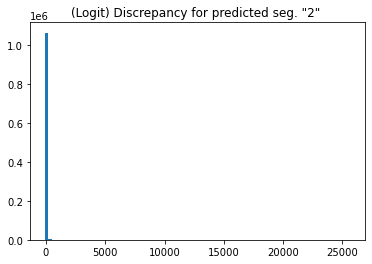

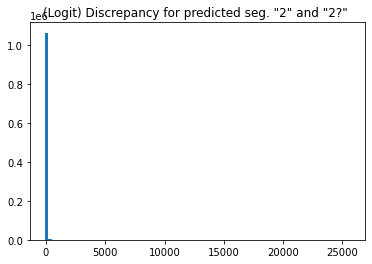

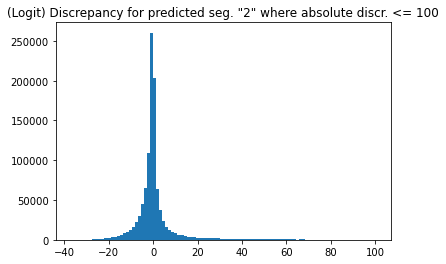

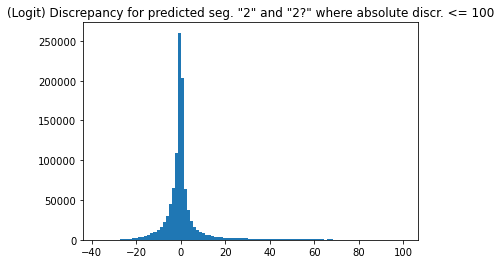

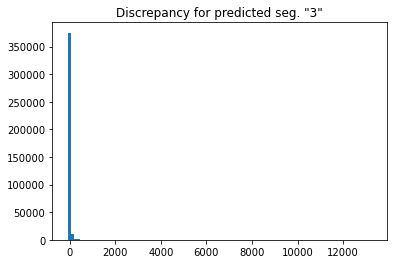

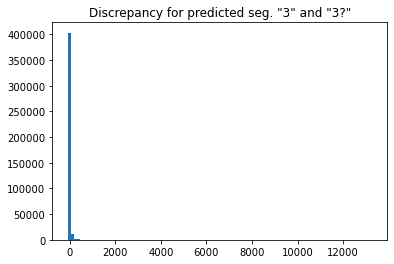

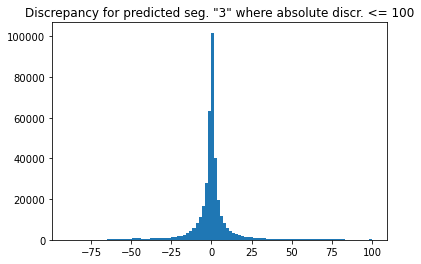

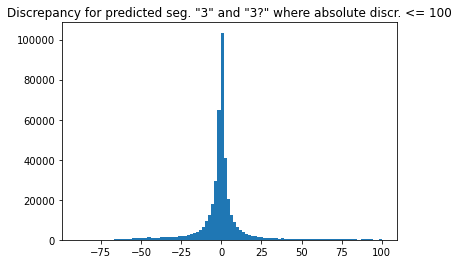

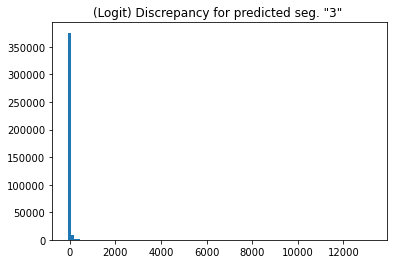

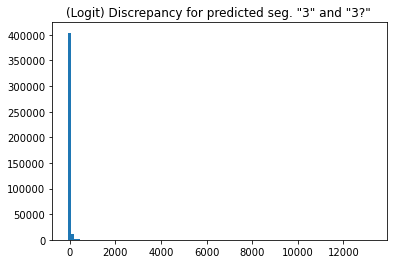

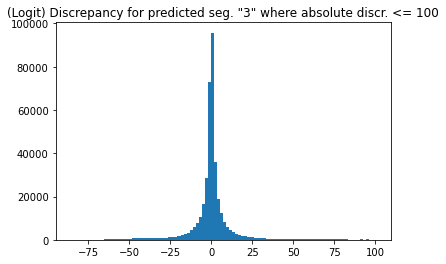

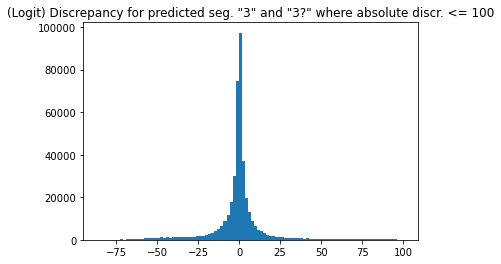

Combined regression score for band_promoter
Only for classes 2 and 3


,min,mean,max
reg2,-37.6389,16.2376,775164
reg2_abs,4.95911e-07,19.3448,775164
reg2_logit,-38.631,15.6889,775161
reg2_logit_abs,1.52588e-06,19.41,775161
reg3,-88.0776,6.52932,72362.2
reg3_abs,2.04468e-05,12.3907,72362.2
reg3_logit,-87.5827,6.62211,72355.3
reg3_logit_abs,3.05176e-06,12.3728,72355.3


For classes 2, 2?,3? and 3


,min,mean,max
reg2,-41.518,17.3496,775164
reg2_abs,4.95911e-07,20.4706,775164
reg2_logit,-38.631,16.7645,775161
reg2_logit_abs,1.52588e-06,20.5107,775161
reg3,-88.0776,16.9728,775131
reg3_abs,2.04468e-05,26.6623,775131
reg3_logit,-87.5827,17.182,775131
reg3_logit_abs,3.05176e-06,26.6281,775131


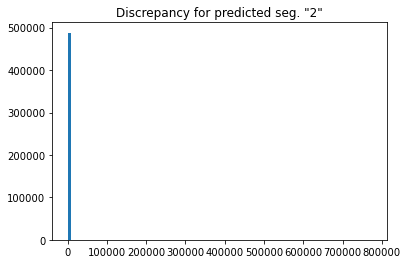

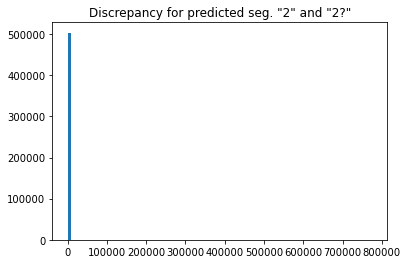

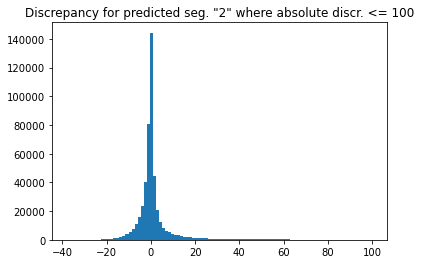

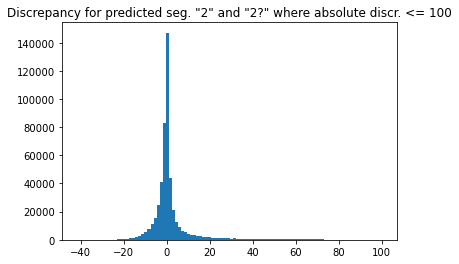

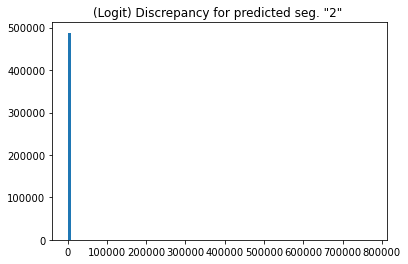

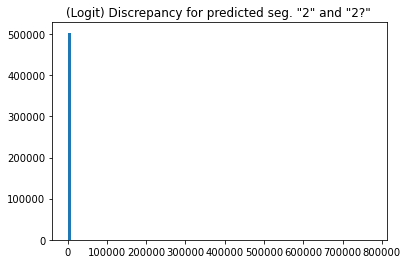

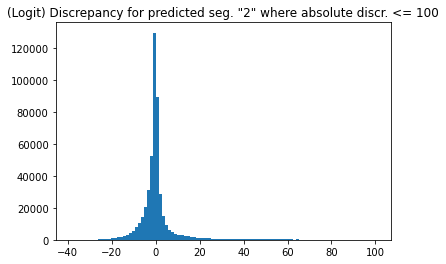

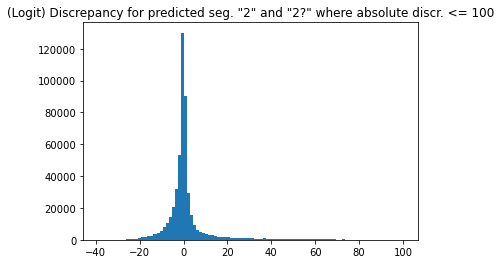

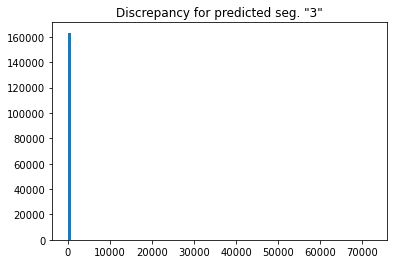

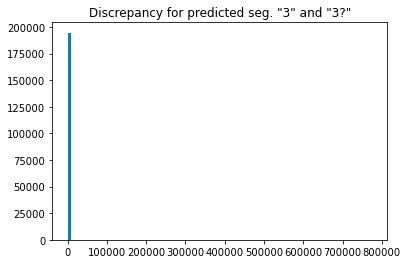

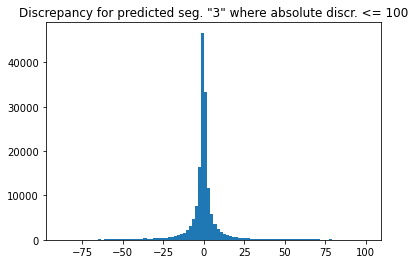

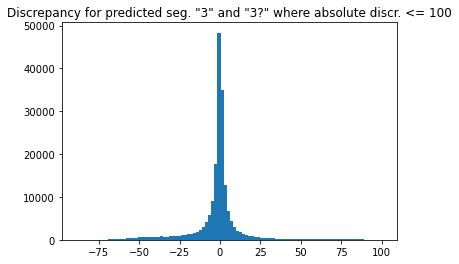

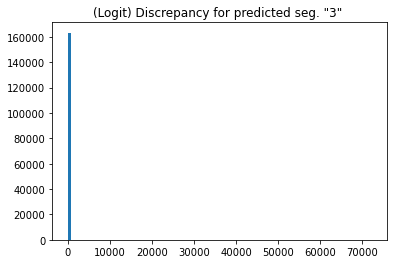

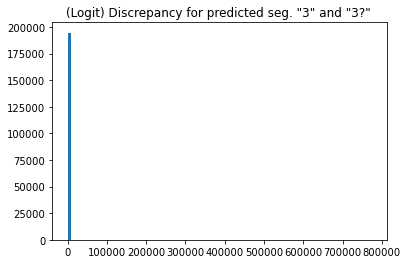

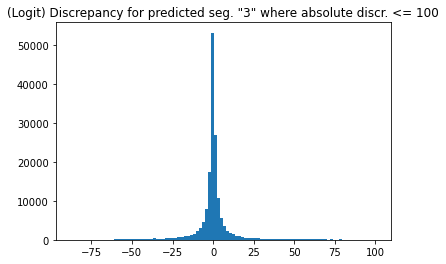

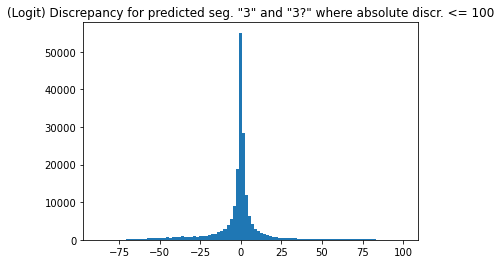

Combined regression score for location_band_promoter
Only for classes 2 and 3


,min,mean,max
reg2,-41.0206,4.99199,16390.3
reg2_abs,8.35419e-06,7.95882,16390.3
reg2_logit,-37.9628,4.38597,16404.8
reg2_logit_abs,6.56128e-06,8.07422,16404.8
reg3,-83.7095,4.78733,12423.8
reg3_abs,2.74658e-05,11.0069,12423.8
reg3_logit,-87.7882,4.88957,12422.9
reg3_logit_abs,6.10352e-06,11.0257,12422.9


For classes 2, 2?,3? and 3


,min,mean,max
reg2,-41.0206,5.10237,16390.3
reg2_abs,8.35419e-06,8.07125,16390.3
reg2_logit,-37.9628,4.49245,16404.8
reg2_logit_abs,6.56128e-06,8.18235,16404.8
reg3,-83.7095,4.64412,12434.5
reg3_abs,2.74658e-05,13.6305,12434.5
reg3_logit,-87.7882,4.82526,12422.9
reg3_logit_abs,6.10352e-06,13.6241,12422.9


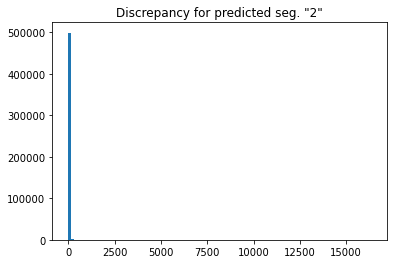

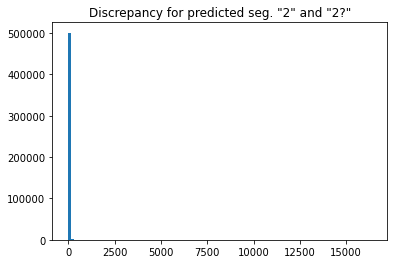

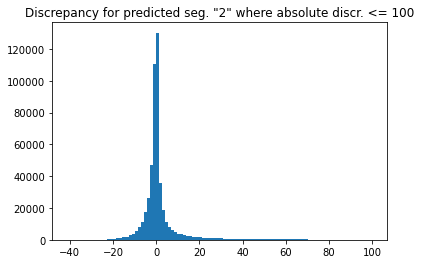

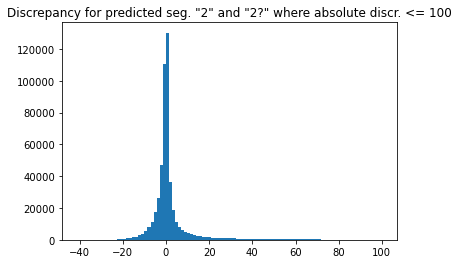

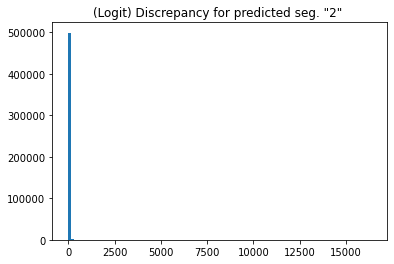

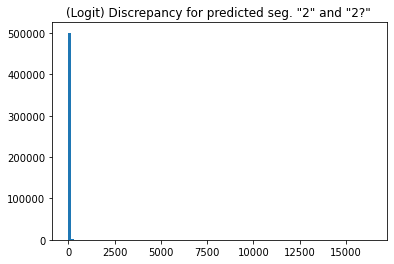

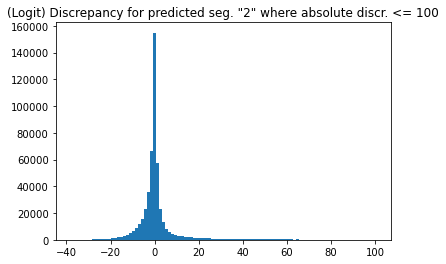

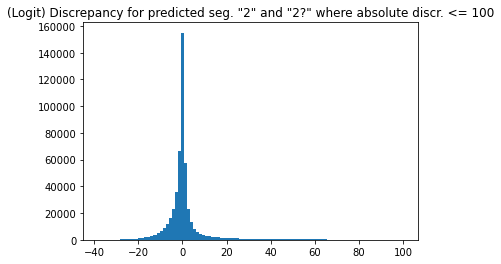

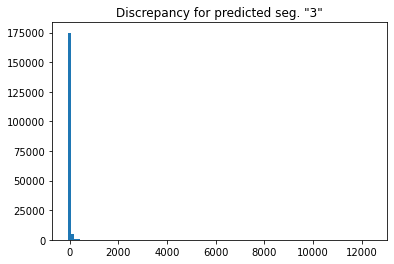

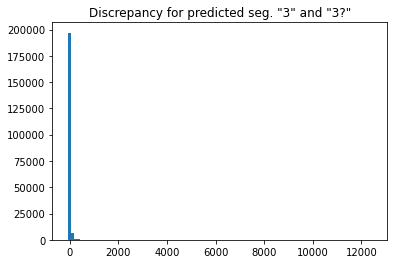

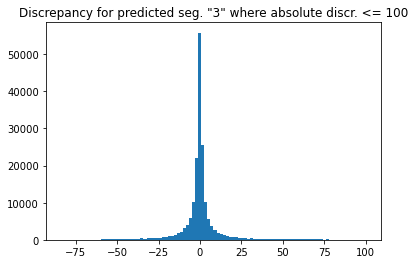

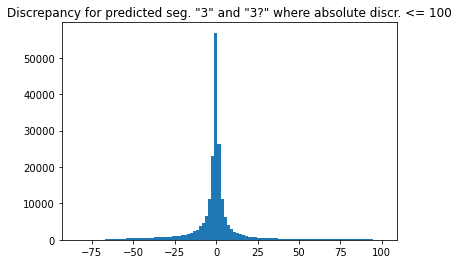

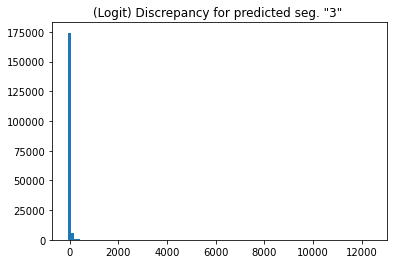

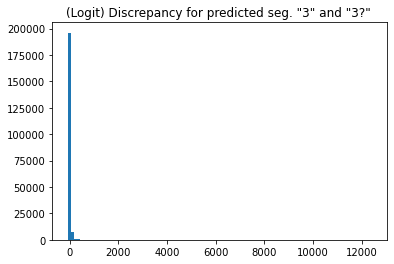

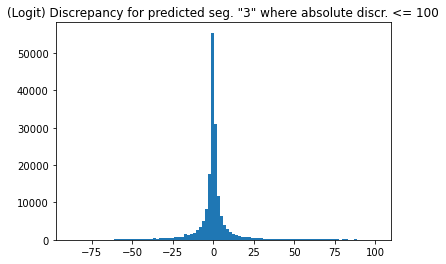

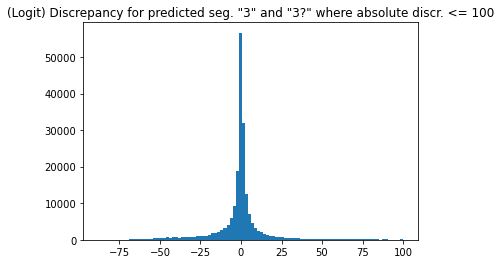

In [29]:
for feature_group_combination in feature_group_combinations:
    model_name="_".join(feature_group_combination)
    print('Combined regression score for {}'.format(model_name))
    
    df_dict[model_name].loc[df_dict[model_name]['y_pred'].isin(['3','3?','4+']),['y_pred_reg2','y_pred_reg2_logit']]=np.nan
    df_dict[model_name].loc[df_dict[model_name]['y_pred'].isin(['2','2?','4+']),['y_pred_reg3','y_pred_reg3_logit']]=np.nan

    df_dict[model_name]['discr_reg2']=df_dict[model_name].amount-df_dict[model_name].y_pred_reg2
    df_dict[model_name]['discr_reg2_abs']=abs(df_dict[model_name].amount-df_dict[model_name].y_pred_reg2)
    df_dict[model_name]['discr_reg2_logit']=df_dict[model_name].amount-df_dict[model_name].y_pred_reg2_logit
    df_dict[model_name]['discr_reg2_logit_abs']=abs(df_dict[model_name].amount-df_dict[model_name].y_pred_reg2_logit)
    df_dict[model_name]['discr_reg3']=df_dict[model_name].amount-df_dict[model_name].y_pred_reg3
    df_dict[model_name]['discr_reg3_abs']=abs(df_dict[model_name].amount-df_dict[model_name].y_pred_reg3)
    df_dict[model_name]['discr_reg3_logit']=df_dict[model_name].amount-df_dict[model_name].y_pred_reg3_logit
    df_dict[model_name]['discr_reg3_logit_abs']=abs(df_dict[model_name].amount-df_dict[model_name].y_pred_reg3_logit)
    
    print("Only for classes 2 and 3")

    scores = pd.DataFrame(columns=('min', 'mean', 'max'), 
                          index=('reg2','reg2_abs', 'reg2_logit', 'reg2_logit_abs', 
                                 'reg3','reg3_abs', 'reg3_logit', 'reg3_logit_abs'))
    
    
    scores.loc['reg2']=[np.min(df_dict[model_name][df_dict[model_name].y_pred.isin(['2'])].discr_reg2), 
                        np.mean(df_dict[model_name][df_dict[model_name].y_pred.isin(['2'])].discr_reg2), 
                        np.max(df_dict[model_name][df_dict[model_name].y_pred.isin(['2'])].discr_reg2)]
    scores.loc['reg2_abs']=[np.min(df_dict[model_name][df_dict[model_name].y_pred.isin(['2'])].discr_reg2_abs), 
                            np.mean(df_dict[model_name][df_dict[model_name].y_pred.isin(['2'])].discr_reg2_abs), 
                            np.max(df_dict[model_name][df_dict[model_name].y_pred.isin(['2'])].discr_reg2_abs)]
    scores.loc['reg2_logit']=[np.min(df_dict[model_name][df_dict[model_name].y_pred.isin(['2'])].discr_reg2_logit), 
                              np.mean(df_dict[model_name][df_dict[model_name].y_pred.isin(['2'])].discr_reg2_logit),
                              np.max(df_dict[model_name][df_dict[model_name].y_pred.isin(['2'])].discr_reg2_logit)]
    scores.loc['reg2_logit_abs']=[np.min(df_dict[model_name][df_dict[model_name].y_pred.isin(['2'])].discr_reg2_logit_abs), 
                                  np.mean(df_dict[model_name][df_dict[model_name].y_pred.isin(['2'])].discr_reg2_logit_abs), 
                                  np.max(df_dict[model_name][df_dict[model_name].y_pred.isin(['2'])].discr_reg2_logit_abs)]
    scores.loc['reg3']=[np.min(df_dict[model_name][df_dict[model_name].y_pred.isin(['3'])].discr_reg3), 
                        np.mean(df_dict[model_name][df_dict[model_name].y_pred.isin(['3'])].discr_reg3), 
                        np.max(df_dict[model_name][df_dict[model_name].y_pred.isin(['3'])].discr_reg3)]
    scores.loc['reg3_abs']=[np.min(df_dict[model_name][df_dict[model_name].y_pred.isin(['3'])].discr_reg3_abs), 
                            np.mean(df_dict[model_name][df_dict[model_name].y_pred.isin(['3'])].discr_reg3_abs), 
                            np.max(df_dict[model_name][df_dict[model_name].y_pred.isin(['3'])].discr_reg3_abs)]
    scores.loc['reg3_logit']=[np.min(df_dict[model_name][df_dict[model_name].y_pred.isin(['3'])].discr_reg3_logit), 
                              np.mean(df_dict[model_name][df_dict[model_name].y_pred.isin(['3'])].discr_reg3_logit),
                              np.max(df_dict[model_name][df_dict[model_name].y_pred.isin(['3'])].discr_reg3_logit)]
    scores.loc['reg3_logit_abs']=[np.min(df_dict[model_name][df_dict[model_name].y_pred.isin(['3'])].discr_reg3_logit_abs), 
                                  np.mean(df_dict[model_name][df_dict[model_name].y_pred.isin(['3'])].discr_reg3_logit_abs), 
                                  np.max(df_dict[model_name][df_dict[model_name].y_pred.isin(['3'])].discr_reg3_logit_abs)]
    
    display(scores)

    
    print("For classes 2, 2?,3? and 3")

    scores = pd.DataFrame(columns=('min', 'mean', 'max'), 
                          index=('reg2','reg2_abs', 'reg2_logit', 'reg2_logit_abs', 
                                 'reg3','reg3_abs', 'reg3_logit', 'reg3_logit_abs'))
    scores.loc['reg2']=[np.min(df_dict[model_name][df_dict[model_name].y_pred.isin(['2','2?'])].discr_reg2), 
                        np.mean(df_dict[model_name][df_dict[model_name].y_pred.isin(['2','2?'])].discr_reg2), 
                        np.max(df_dict[model_name][df_dict[model_name].y_pred.isin(['2','2?'])].discr_reg2)]
    scores.loc['reg2_abs']=[np.min(df_dict[model_name][df_dict[model_name].y_pred.isin(['2','2?'])].discr_reg2_abs), 
                            np.mean(df_dict[model_name][df_dict[model_name].y_pred.isin(['2','2?'])].discr_reg2_abs), 
                            np.max(df_dict[model_name][df_dict[model_name].y_pred.isin(['2','2?'])].discr_reg2_abs)]
    scores.loc['reg2_logit']=[np.min(df_dict[model_name][df_dict[model_name].y_pred.isin(['2','2?'])].discr_reg2_logit), 
                              np.mean(df_dict[model_name][df_dict[model_name].y_pred.isin(['2','2?'])].discr_reg2_logit),
                              np.max(df_dict[model_name][df_dict[model_name].y_pred.isin(['2','2?'])].discr_reg2_logit)]
    scores.loc['reg2_logit_abs']=[np.min(df_dict[model_name][df_dict[model_name].y_pred.isin(['2','2?'])].discr_reg2_logit_abs), 
                                  np.mean(df_dict[model_name][df_dict[model_name].y_pred.isin(['2','2?'])].discr_reg2_logit_abs), 
                                  np.max(df_dict[model_name][df_dict[model_name].y_pred.isin(['2','2?'])].discr_reg2_logit_abs)]
    scores.loc['reg3']=[np.min(df_dict[model_name][df_dict[model_name].y_pred.isin(['3','3?'])].discr_reg3), 
                        np.mean(df_dict[model_name][df_dict[model_name].y_pred.isin(['3','3?'])].discr_reg3), 
                        np.max(df_dict[model_name][df_dict[model_name].y_pred.isin(['3','3?'])].discr_reg3)]
    scores.loc['reg3_abs']=[np.min(df_dict[model_name][df_dict[model_name].y_pred.isin(['3','3?'])].discr_reg3_abs), 
                            np.mean(df_dict[model_name][df_dict[model_name].y_pred.isin(['3','3?'])].discr_reg3_abs), 
                            np.max(df_dict[model_name][df_dict[model_name].y_pred.isin(['3','3?'])].discr_reg3_abs)]
    scores.loc['reg3_logit']=[np.min(df_dict[model_name][df_dict[model_name].y_pred.isin(['3','3?'])].discr_reg3_logit), 
                              np.mean(df_dict[model_name][df_dict[model_name].y_pred.isin(['3','3?'])].discr_reg3_logit),
                              np.max(df_dict[model_name][df_dict[model_name].y_pred.isin(['3','3?'])].discr_reg3_logit)]
    scores.loc['reg3_logit_abs']=[np.min(df_dict[model_name][df_dict[model_name].y_pred.isin(['3','3?'])].discr_reg3_logit_abs), 
                                  np.mean(df_dict[model_name][df_dict[model_name].y_pred.isin(['3','3?'])].discr_reg3_logit_abs), 
                                  np.max(df_dict[model_name][df_dict[model_name].y_pred.isin(['3','3?'])].discr_reg3_logit_abs)]
    
    display(scores)

    plt.hist(df_dict[model_name][(df_dict[model_name].y_pred.isin(['2']))].discr_reg2, bins=100)
    plt.title('Discrepancy for predicted seg. "2"' )
    plt.show()
    plt.hist(df_dict[model_name][(df_dict[model_name].y_pred.isin(['2','2?']))].discr_reg2, bins=100)
    plt.title('Discrepancy for predicted seg. "2" and "2?"' )
    plt.show()

    plt.hist(df_dict[model_name][(df_dict[model_name].y_pred.isin(['2']))&(df_dict[model_name].discr_reg2_abs<=100)].discr_reg2, bins=100)
    plt.title('Discrepancy for predicted seg. "2" where absolute discr. <= 100' )
    plt.show()
    plt.hist(df_dict[model_name][(df_dict[model_name].y_pred.isin(['2','2?']))&(df_dict[model_name].discr_reg2_abs<=100)].discr_reg2, bins=100)
    plt.title('Discrepancy for predicted seg. "2" and "2?" where absolute discr. <= 100' )
    plt.show()
    
    plt.hist(df_dict[model_name][(df_dict[model_name].y_pred.isin(['2']))].discr_reg2_logit, bins=100)
    plt.title('(Logit) Discrepancy for predicted seg. "2" ' )
    plt.show()
    plt.hist(df_dict[model_name][(df_dict[model_name].y_pred.isin(['2','2?']))].discr_reg2_logit, bins=100)
    plt.title('(Logit) Discrepancy for predicted seg. "2" and "2?" ' )
    plt.show()

    plt.hist(df_dict[model_name][(df_dict[model_name].y_pred.isin(['2']))&(df_dict[model_name].discr_reg2_logit_abs<=100)].discr_reg2_logit, bins=100)
    plt.title('(Logit) Discrepancy for predicted seg. "2" where absolute discr. <= 100' )
    plt.show()
    plt.hist(df_dict[model_name][(df_dict[model_name].y_pred.isin(['2','2?']))&(df_dict[model_name].discr_reg2_logit_abs<=100)].discr_reg2_logit, bins=100)
    plt.title('(Logit) Discrepancy for predicted seg. "2" and "2?" where absolute discr. <= 100' )
    plt.show()
    
    plt.hist(df_dict[model_name][(df_dict[model_name].y_pred.isin(['3']))].discr_reg3, bins=100)
    plt.title('Discrepancy for predicted seg. "3"' )
    plt.show()
    plt.hist(df_dict[model_name][(df_dict[model_name].y_pred.isin(['3','3?']))].discr_reg3, bins=100)
    plt.title('Discrepancy for predicted seg. "3" and "3?"' )
    plt.show()

    plt.hist(df_dict[model_name][(df_dict[model_name].y_pred.isin(['3']))&(df_dict[model_name].discr_reg3_abs<=100)].discr_reg3, bins=100)
    plt.title('Discrepancy for predicted seg. "3" where absolute discr. <= 100' )
    plt.show()
    plt.hist(df_dict[model_name][(df_dict[model_name].y_pred.isin(['3','3?']))&(df_dict[model_name].discr_reg3_abs<=100)].discr_reg3, bins=100)
    plt.title('Discrepancy for predicted seg. "3" and "3?" where absolute discr. <= 100' )
    plt.show()
    
    plt.hist(df_dict[model_name][(df_dict[model_name].y_pred.isin(['3']))].discr_reg3_logit, bins=100)
    plt.title('(Logit) Discrepancy for predicted seg. "3" ' )
    plt.show()
    plt.hist(df_dict[model_name][(df_dict[model_name].y_pred.isin(['3','3?']))].discr_reg3_logit, bins=100)
    plt.title('(Logit) Discrepancy for predicted seg. "3" and "3?" ' )
    plt.show()

    plt.hist(df_dict[model_name][(df_dict[model_name].y_pred.isin(['3']))&(df_dict[model_name].discr_reg3_logit_abs<=100)].discr_reg3_logit, bins=100)
    plt.title('(Logit) Discrepancy for predicted seg. "3" where absolute discr. <= 100' )
    plt.show()
    plt.hist(df_dict[model_name][(df_dict[model_name].y_pred.isin(['3','3?']))&(df_dict[model_name].discr_reg3_logit_abs<=100)].discr_reg3_logit, bins=100)
    plt.title('(Logit) Discrepancy for predicted seg. "3" and "3?" where absolute discr. <= 100' )
    plt.show()



# Feature Importance

## Feature importance

### CLF1

Plot feature importance for CLF1 for location


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


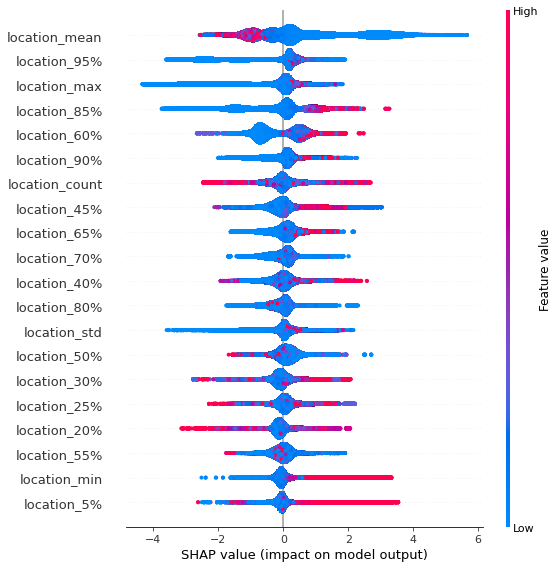

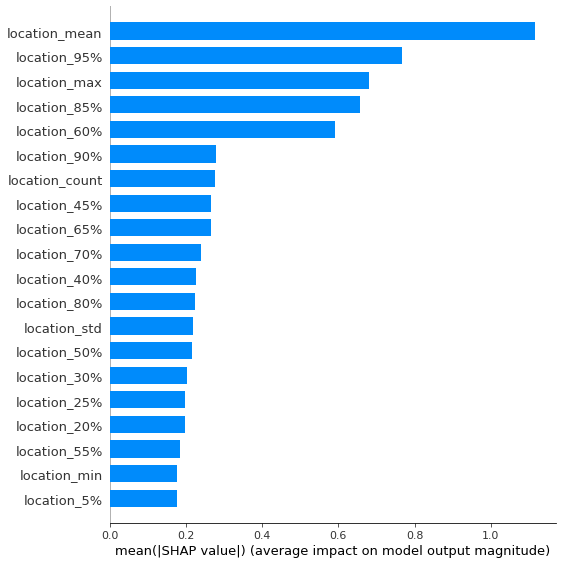

Plot feature importance for CLF1 for band


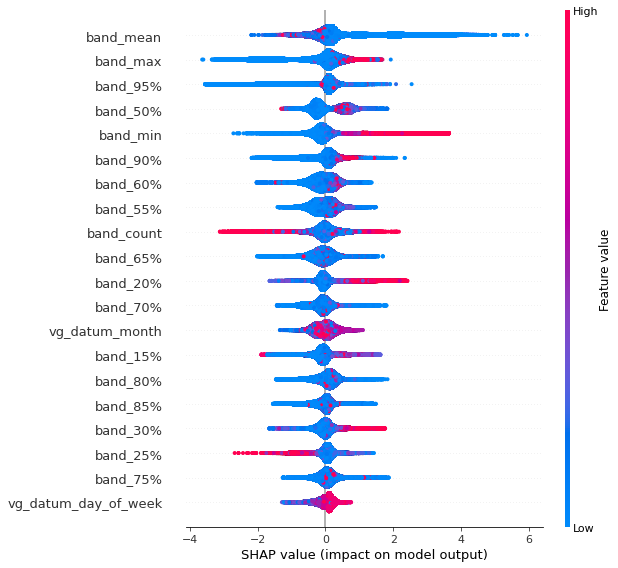

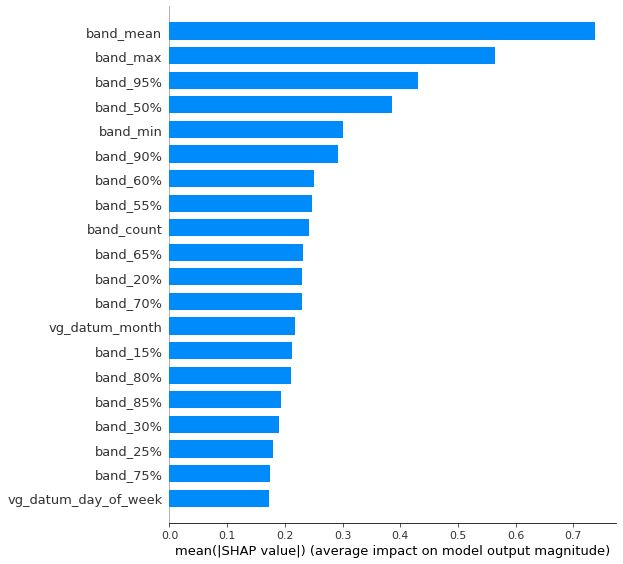

Plot feature importance for CLF1 for promoter


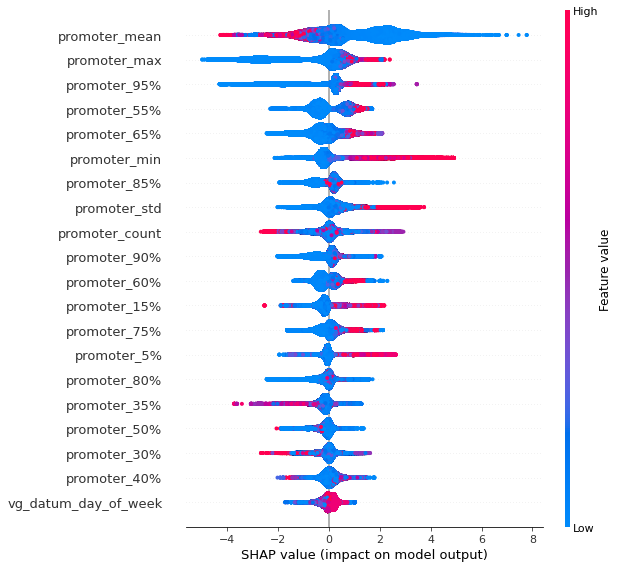

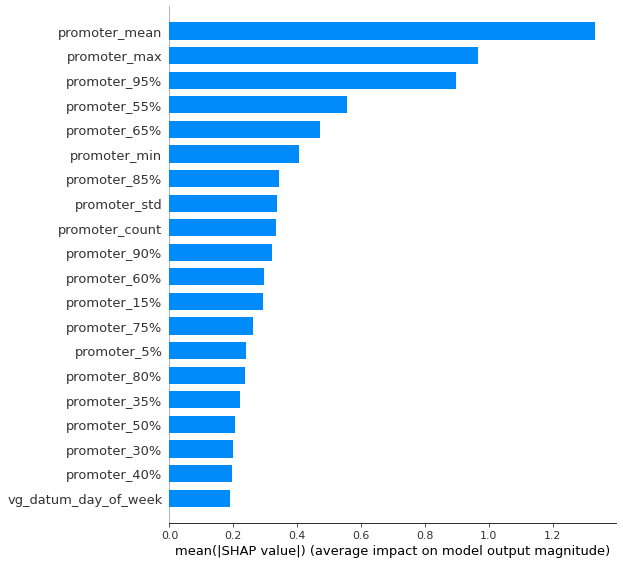

Plot feature importance for CLF1 for location_band


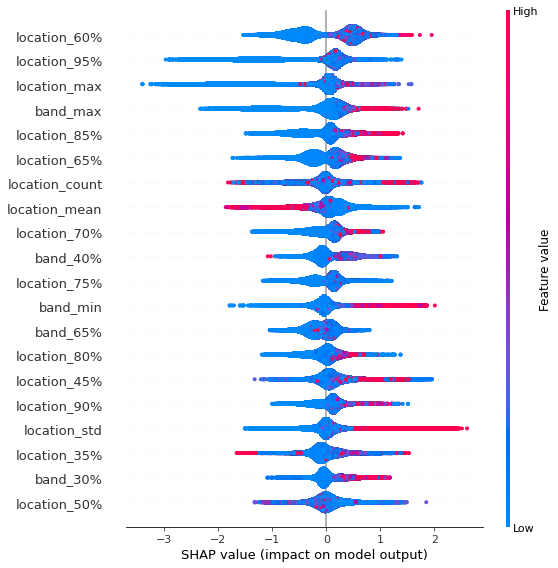

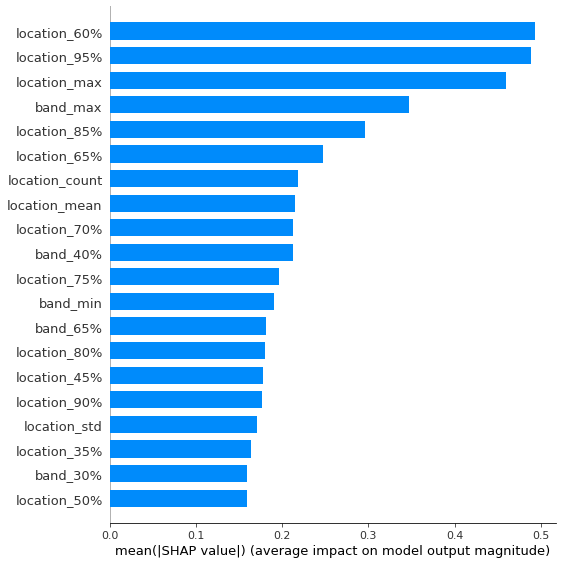

Plot feature importance for CLF1 for location_promoter


MemoryError: Unable to allocate 90.7 MiB for an array with shape (2970981, 4) and data type float64

<Figure size 576x684 with 2 Axes>

MemoryError: Unable to allocate 748. MiB for an array with shape (33, 2970981) and data type int64

In [43]:
for feature_group_combination in feature_group_combinations:
    model_name="_".join(feature_group_combination)
    print('Plot feature importance for CLF1 for {}'.format(model_name))
    
    explainer_clf1 = shap.TreeExplainer(clf1_models[model_name])
    shap_values_clf1 = explainer_clf1.shap_values(df_dict[model_name][model_features[model_name]])
    shap.summary_plot(shap_values_clf1, features=df_dict[model_name][model_features[model_name]], 
                      feature_names=df_dict[model_name][model_features[model_name]].columns)
    
    shap.summary_plot(shap_values_clf1, features=df_dict[model_name][model_features[model_name]], 
                      feature_names=df_dict[model_name][model_features[model_name]].columns, plot_type='bar')

### Feature importance CLF2

In [ ]:
for feature_group_combination in feature_group_combinations:
    model_name="_".join(feature_group_combination)
    print('Plot feature importance for CLF2 for {}'.format(model_name))
    
    explainer_clf2 = shap.TreeExplainer(clf2_models[model_name])
    shap_values_clf2 = explainer_clf2.shap_values(df_dict[model_name][~df_dict[model_name].y_clf2.isnull()][model_features[model_name]])
    shap.summary_plot(shap_values_clf2, 
                      features=df_dict[model_name][~df_dict[model_name].y_clf2.isnull()][model_features[model_name]], 
                      feature_names=df_dict[model_name][model_features[model_name]].columns)
    
    shap.summary_plot(shap_values_clf2, features=df_dict[model_name][~df_dict[model_name].y_clf2.isnull()][model_features[model_name]], 
                      feature_names=df_dict[model_name][model_features[model_name]].columns, plot_type='bar')

### Feature Importance Reg2

In [ ]:
for feature_group_combination in feature_group_combinations:
    model_name="_".join(feature_group_combination)
    print('Plot feature importance for REG2 for {}'.format(model_name))
    
    explainer_reg2 = shap.TreeExplainer(reg2_models[model_name])
    shap_values_reg2 = explainer_reg2.shap_values(df_dict[model_name][df_dict[model_name].amount_segment==2][model_features[model_name]])
    shap.summary_plot(shap_values_reg2, features=df_dict[model_name][df_dict[model_name].amount_segment==2][model_features[model_name]], feature_names=df_dict[model_name][model_features[model_name]].columns)
    shap.summary_plot(shap_values_reg2, features=df_dict[model_name][df_dict[model_name].amount_segment==2][model_features[model_name]], feature_names=df_dict[model_name][model_features[model_name]].columns, plot_type='bar')

In [ ]:
for feature_group_combination in feature_group_combinations:
    model_name="_".join(feature_group_combination)
    print('Plot feature importance for REG2 LOGIT for {}'.format(model_name))
    
    explainer_reg2_logit = shap.TreeExplainer(reg2_logit_models[model_name])
    shap_values_reg2_logit = explainer_reg2_logit.shap_values(df_dict[model_name][df_dict[model_name].amount_segment==2][model_features[model_name]])
    shap.summary_plot(shap_values_reg2_logit, features=df_dict[model_name][df_dict[model_name].amount_segment==2][model_features[model_name]], feature_names=df_dict[model_name][model_features[model_name]].columns)
    
    shap.summary_plot(shap_values_reg2_logit, features=df_dict[model_name][df_dict[model_name].amount_segment==2][model_features[model_name]], feature_names=df_dict[model_name][model_features[model_name]].columns, plot_type='bar')

### Feature Importance reg3

In [ ]:
for feature_group_combination in feature_group_combinations:
    model_name="_".join(feature_group_combination)
    print('Plot feature importance for REG3 for {}'.format(model_name))
    
    explainer_reg3 = shap.TreeExplainer(reg3_models[model_name])
    shap_values_reg3 = explainer_reg3.shap_values(df_dict[model_name][df_dict[model_name].amount_segment==3][model_features[model_name]])
    shap.summary_plot(shap_values_reg3, features=df_dict[model_name][df_dict[model_name].amount_segment==3][model_features[model_name]], feature_names=df_dict[model_name][model_features[model_name]].columns)
    
    shap.summary_plot(shap_values_reg3, features=df_dict[model_name][df_dict[model_name].amount_segment==3][model_features[model_name]], feature_names=df_dict[model_name][model_features[model_name]].columns, plot_type='bar')

In [ ]:
for feature_group_combination in feature_group_combinations:
    model_name="_".join(feature_group_combination)
    print('Plot feature importance for REG3 Logit for {}'.format(model_name))
  
    explainer_reg3_logit = shap.TreeExplainer(reg3_logit_models[model_name])
    shap_values_reg3_logit = explainer_reg3_logit.shap_values(df_dict[model_name][df_dict[model_name].amount_segment==3][model_features[model_name]])
    shap.summary_plot(shap_values_reg3_logit, features=df_dict[model_name][df_dict[model_name].amount_segment==3][model_features[model_name]], feature_names=df_dict[model_name][model_features[model_name]].columns)
    
    shap.summary_plot(shap_values_reg3_logit, features=df_dict[model_name][df_dict[model_name].amount_segment==3][model_features[model_name]], feature_names=df_dict[model_name][model_features[model_name]].columns, plot_type='bar')

# Cross-validation

In [ ]:
cv_model_eval = TimeSeriesSplit(n_splits=5)

df_dict = {}
cv_results_clf1 = {}
cv_results_clf2 = {}
cv_results_reg2 = {}
cv_results_reg2_logit = {}
cv_results_reg3 = {}
cv_results_reg3_logit = {}

for feature_group_combination in tqdm(feature_group_combinations):
    model_name="_".join(feature_group_combination)
    print('Crossvalidate models for {}'.format(model_name))
    
    df_dict[model_name]=df[model_features[model_name]+['amount','amount_segment','y_clf1','y_clf2']].dropna(subset=model_features[model_name]).copy()

    #Test dataset is the same for all models
    X_test = df_dict[model_name][model_features[model_name]]

    X_train_clf1 = df_dict[model_name][model_features[model_name]]
    y_train_clf1 = df_dict[model_name].y_clf1

    # For Classifier2 (clf2) we use data from segments 2 and 3 (so we drop records where y_clf2 is NaN)
    df_train_clf2 = df_dict[model_name].dropna(subset=['y_clf2'])

    X_train_clf2 = df_train_clf2[model_features[model_name]]
    y_train_clf2 = df_train_clf2.y_clf2.astype(int)


    # For Regression seg2 use only Segment 2 and amount 0.00001>=amount>=49.9999 (because of logit)
    df_train_reg2 = df_dict[model_name][(df_dict[model_name]['amount_segment']==2) & 
                             (df_dict[model_name]['amount']>=0.00001) & 
                             (df_dict[model_name]['amount']<=49.9999)]

    X_train_reg2 = df_train_reg2[model_features[model_name]]
    y_train_reg2 = df_train_reg2.amount
    y_train_reg2_logit = (y_train_reg2/50).apply(logit)


    # For Regression seg3 use only Segment 3 and amount 50>amount>=99.9999 (because of logit)
    df_train_reg3 = df_dict[model_name][(df_dict[model_name]['amount_segment']==3) & 
                             (df_dict[model_name]['amount']>50) & 
                             (df_dict[model_name]['amount']<=99.9999)]

    X_train_reg3 = df_train_reg3[model_features[model_name]]
    y_train_reg3 = df_train_reg3.amount
    y_train_reg3_logit = ((y_train_reg3-50)/50).apply(logit)


    cv_results_clf1[model_name] = cross_validate(clf1_models[model_name], X_train_clf1, y_train_clf1, scoring=['accuracy', 'roc_auc'], cv=cv_model_eval, return_train_score=True)   
    cv_results_clf2[model_name] = cross_validate(clf2_models[model_name], X_train_clf2, y_train_clf2, scoring=['accuracy', 'roc_auc'], cv=cv_model_eval, return_train_score=True)
    cv_results_reg2[model_name] = cross_validate(reg2_models[model_name], X_train_reg2, y_train_reg2, scoring=['neg_mean_squared_error', 'r2'], cv=cv_model_eval, return_train_score=True)
    cv_results_reg3[model_name] = cross_validate(reg3_models[model_name], X_train_reg3, y_train_reg3, scoring=['neg_mean_squared_error', 'r2'], cv=cv_model_eval, return_train_score=True)
    cv_results_reg2_logit[model_name] = cross_validate(reg2_logit_models[model_name], X_train_reg2, y_train_reg2_logit, scoring=['neg_mean_squared_error', 'r2'], cv=cv_model_eval, return_train_score=True)
    cv_results_reg3_logit[model_name] = cross_validate(reg3_logit_models[model_name], X_train_reg3, y_train_reg3_logit, scoring=['neg_mean_squared_error', 'r2'], cv=cv_model_eval, return_train_score=True)

  0%|          | 0/7 [00:00<?, ?it/s]

Crossvalidate models for location
Crossvalidate models for band
Crossvalidate models for promoter
Crossvalidate models for location_band
Crossvalidate models for location_promoter
Crossvalidate models for band_promoter


In [14]:

for feature_group_combination in tqdm(feature_group_combinations):
    model_name="_".join(feature_group_combination)
    print('Cross-validation results for {}'.format(model_name))
    print(cv_results_clf1[model_name])
    print(cv_results_clf2[model_name])
    print(cv_results_reg2[model_name])
    print(cv_results_reg2_logit[model_name])
    print(cv_results_reg3[model_name])
    print(cv_results_reg3_logit[model_name])


  0%|          | 0/7 [00:00<?, ?it/s]

Cross-validation results for location
{'fit_time': array([20.53262353, 24.59902406, 28.44806099, 32.23439074, 36.08928323]), 'score_time': array([10.74249029, 10.75016189, 10.78554654, 10.67075896, 10.83937335]), 'test_accuracy': array([0.94021866, 0.96071484, 0.95612722, 0.94690326, 0.96273191]), 'train_accuracy': array([0.99208963, 0.98878629, 0.98735322, 0.98663132, 0.98463754]), 'test_roc_auc': array([0.9776818 , 0.98878966, 0.98766464, 0.98210048, 0.99046667]), 'train_roc_auc': array([0.99967243, 0.99935104, 0.99917821, 0.99903379, 0.99869619])}
{'fit_time': array([17.56250501, 21.49383998, 24.46678305, 27.33562803, 29.65569639]), 'score_time': array([6.61774611, 6.62431645, 6.63415837, 6.64018059, 6.54246974]), 'test_accuracy': array([0.91726587, 0.94364129, 0.94201775, 0.9178387 , 0.93882447]), 'train_accuracy': array([0.99322421, 0.98959101, 0.98809617, 0.98678383, 0.98403678]), 'test_roc_auc': array([0.95908331, 0.97779753, 0.97902773, 0.96241979, 0.97797325]), 'train_roc_auc'

In [15]:
columns_list_clf=['Model', 'Feature_Combination', 
              'Mean_Train_Accuracy', 'Std_Train_Accuracy',
              'Mean_Test_Accuracy', 'Std_Test_Accuracy', 
              'Mean_Train_AUC', 'Std_Train_AUC', 
              'Mean_Test_AUC', 'Std_Test_AUC']
cv_results_clf = pd.DataFrame(columns=columns_list_clf)

columns_list_reg=['Model', 'Feature_Combination', 
              'Mean_Train_NMSE', 'Std_Train_NMSE',
              'Mean_Test_NMSE', 'Std_Test_NMSE', 
              'Mean_Train_R2', 'Std_Train_R2', 
              'Mean_Test_R2', 'Std_Test_R2']
cv_results_reg = pd.DataFrame(columns=columns_list_reg)


for feature_group_combination in tqdm(feature_group_combinations):
    model_name="_".join(feature_group_combination)
    cv_results_clf=cv_results_clf.append(pd.DataFrame([['clf1', model_name,
                                 np.mean(cv_results_clf1[model_name]['train_accuracy']),
                                 np.std(cv_results_clf1[model_name]['train_accuracy']),
                                 np.mean(cv_results_clf1[model_name]['test_accuracy']),
                                 np.std(cv_results_clf1[model_name]['test_accuracy']),
                                 np.mean(cv_results_clf1[model_name]['train_roc_auc']),
                                 np.std(cv_results_clf1[model_name]['train_roc_auc']),
                                 np.mean(cv_results_clf1[model_name]['test_roc_auc']),
                                 np.std(cv_results_clf1[model_name]['test_roc_auc'])]], columns=columns_list_clf),
                                ignore_index=True)

    cv_results_clf=cv_results_clf.append(pd.DataFrame([['clf2', model_name,
                                 np.mean(cv_results_clf2[model_name]['train_accuracy']),
                                 np.std(cv_results_clf2[model_name]['train_accuracy']),
                                 np.mean(cv_results_clf2[model_name]['test_accuracy']),
                                 np.std(cv_results_clf2[model_name]['test_accuracy']),
                                 np.mean(cv_results_clf2[model_name]['train_roc_auc']),
                                 np.std(cv_results_clf2[model_name]['train_roc_auc']),
                                 np.mean(cv_results_clf2[model_name]['test_roc_auc']),
                                 np.std(cv_results_clf2[model_name]['test_roc_auc'])]], columns=columns_list_clf),
                                ignore_index=True)

    cv_results_reg=cv_results_reg.append(pd.DataFrame([['reg2', model_name,
                                 np.mean(cv_results_reg2[model_name]['train_neg_mean_squared_error']),
                                 np.std(cv_results_reg2[model_name]['train_neg_mean_squared_error']),
                                 np.mean(cv_results_reg2[model_name]['test_neg_mean_squared_error']),
                                 np.std(cv_results_reg2[model_name]['test_neg_mean_squared_error']),
                                 np.mean(cv_results_reg2[model_name]['train_r2']),
                                 np.std(cv_results_reg2[model_name]['train_r2']),
                                 np.mean(cv_results_reg2[model_name]['test_r2']),
                                 np.std(cv_results_reg2[model_name]['test_r2'])]], columns=columns_list_reg),
                                ignore_index=True)
    
    cv_results_reg=cv_results_reg.append(pd.DataFrame([['reg2_logit', model_name,
                                 np.mean(cv_results_reg2_logit[model_name]['train_neg_mean_squared_error']),
                                 np.std(cv_results_reg2_logit[model_name]['train_neg_mean_squared_error']),
                                 np.mean(cv_results_reg2_logit[model_name]['test_neg_mean_squared_error']),
                                 np.std(cv_results_reg2_logit[model_name]['test_neg_mean_squared_error']),
                                 np.mean(cv_results_reg2_logit[model_name]['train_r2']),
                                 np.std(cv_results_reg2_logit[model_name]['train_r2']),
                                 np.mean(cv_results_reg2_logit[model_name]['test_r2']),
                                 np.std(cv_results_reg2_logit[model_name]['test_r2'])]], columns=columns_list_reg),
                                ignore_index=True)
    cv_results_reg=cv_results_reg.append(pd.DataFrame([['reg3', model_name,
                                 np.mean(cv_results_reg3[model_name]['train_neg_mean_squared_error']),
                                 np.std(cv_results_reg3[model_name]['train_neg_mean_squared_error']),
                                 np.mean(cv_results_reg3[model_name]['test_neg_mean_squared_error']),
                                 np.std(cv_results_reg3[model_name]['test_neg_mean_squared_error']),
                                 np.mean(cv_results_reg3[model_name]['train_r2']),
                                 np.std(cv_results_reg3[model_name]['train_r2']),
                                 np.mean(cv_results_reg3[model_name]['test_r2']),
                                 np.std(cv_results_reg3[model_name]['test_r2'])]], columns=columns_list_reg),
                                ignore_index=True)
    cv_results_reg=cv_results_reg.append(pd.DataFrame([['reg3_logit', model_name,
                                 np.mean(cv_results_reg3_logit[model_name]['train_neg_mean_squared_error']),
                                 np.std(cv_results_reg3_logit[model_name]['train_neg_mean_squared_error']),
                                 np.mean(cv_results_reg3_logit[model_name]['test_neg_mean_squared_error']),
                                 np.std(cv_results_reg3_logit[model_name]['test_neg_mean_squared_error']),
                                 np.mean(cv_results_reg3_logit[model_name]['train_r2']),
                                 np.std(cv_results_reg3_logit[model_name]['train_r2']),
                                 np.mean(cv_results_reg3_logit[model_name]['test_r2']),
                                 np.std(cv_results_reg3_logit[model_name]['test_r2'])]], columns=columns_list_reg),
                                ignore_index=True)


display(cv_results_clf)
display(cv_results_reg)

  0%|          | 0/7 [00:00<?, ?it/s]

,Model,Feature_Combination,Mean_Train_Accuracy,Std_Train_Accuracy,Mean_Test_Accuracy,Std_Test_Accuracy,Mean_Train_AUC,Std_Train_AUC,Mean_Test_AUC,Std_Test_AUC
0,clf1,location,0.987900,0.002486,0.953339,0.008532,0.999186,3.246492e-04,0.985341,0.004748
1,clf2,location,0.988346,0.003047,0.931918,0.011833,0.999155,4.265381e-04,0.971260,0.008655
2,clf1,band,0.992627,0.003675,0.919039,0.021964,0.999426,4.247502e-04,0.963469,0.017105
3,clf2,band,0.994417,0.002452,0.911540,0.014249,0.999638,2.671029e-04,0.952564,0.011448
4,clf1,promoter,0.989757,0.003365,0.933749,0.014643,0.999292,4.250632e-04,0.977085,0.006929
5,clf2,promoter,0.988845,0.003928,0.917264,0.015686,0.999095,5.387162e-04,0.963756,0.010551
6,clf1,location_band,0.999840,0.000157,0.943478,0.008460,0.999999,8.034618e-07,0.983935,0.003307
7,clf2,location_band,0.999649,0.000107,0.923148,0.010865,0.999999,5.769493e-07,0.970956,0.006340
8,clf1,location_promoter,0.997703,0.000955,0.958311,0.009301,0.999965,2.854218e-05,0.989241,0.003428
9,clf2,location_promoter,0.997590,0.000818,0.939142,0.010787,0.999956,3.138028e-05,0.977796,0.006709


,Model,Feature_Combination,Mean_Train_NMSE,Std_Train_NMSE,Mean_Test_NMSE,Std_Test_NMSE,Mean_Train_R2,Std_Train_R2,Mean_Test_R2,Std_Test_R2
0,reg2,location,-19.591952,2.202815,-35.872210,4.893534,0.827407,0.022163,0.671005,0.047626
1,reg2_logit,location,-0.257458,0.030658,-0.501413,0.077200,0.808298,0.024582,0.629062,0.050848
2,reg3,location,-33.632649,6.571595,-78.568549,12.293177,0.817285,0.035875,0.566325,0.067222
3,reg3_logit,location,-0.486529,0.100973,-1.177685,0.181913,0.805681,0.040411,0.527156,0.069468
4,reg2,band,-17.116578,3.789948,-43.748624,4.174451,0.837089,0.035920,0.585827,0.041212
5,reg2_logit,band,-0.218733,0.052854,-0.618302,0.089705,0.828380,0.039757,0.544261,0.044160
6,reg3,band,-24.532646,8.501937,-98.216356,15.507644,0.867678,0.046141,0.462574,0.083586
7,reg3_logit,band,-0.355632,0.124526,-1.456331,0.218838,0.857589,0.049542,0.421318,0.081594
8,reg2,promoter,-15.870232,2.793974,-38.211183,3.793247,0.859233,0.027010,0.647246,0.037250
9,reg2_logit,promoter,-0.212433,0.039360,-0.522455,0.061123,0.840189,0.031001,0.607873,0.044666


# Grid Search

In [17]:
from pathlib import Path
from sklearn.model_selection import GridSearchCV
import pickle
df_dict={}

def grid_search_model_clf1(feature_group_combination):
    print('Grid Search model for: ', " and ".join(feature_group_combination))
        
    df_dict[model_name]=df[model_features[model_name]+['amount','amount_segment','y_clf1','y_clf2']].dropna(subset=model_features[model_name]).copy()

    #Test dataset is the same for all models
    X = df_dict[model_name][model_features[model_name]]
    y = df_dict[model_name].y_clf1
                
    scoring = {'AUC': 'roc_auc', 'Accuracy': 'accuracy'}

    parameters = {
        'max_depth': [6,7,8,9], # [default=6]
        'n_estimators': [500,700,900,1100], # [default=100]
        'tree_method': ['gpu_hist'],
        'use_label_encoder': [False], 
        'objective': ['binary:logistic'],
        'eval_metric': ['error']
    }

    xgb_model = xgb.XGBClassifier()
    cv = TimeSeriesSplit(n_splits=5)

    grid_search = GridSearchCV(xgb_model, parameters, n_jobs=4, cv=cv, scoring=scoring, refit=False, verbose=2, return_train_score=True) 
    grid_search.fit(X, y)

    print(grid_search.cv_results_)
    
    return grid_search


gs_results={}
for feature_group_combination in feature_group_combinations :
    pkl_filename = Path('./grid_search/'+'_'.join(feature_group_combination)+"_grid_search_clf1.pkl")
    
    if pkl_filename.exists() :
        print('Load Grid Search results for clf1 model '+'_'.join(feature_group_combination))
        
        with open(pkl_filename, 'rb') as file:
            gs_result= pickle.load(file)
    else :
        print('Grid Search for clf1 model '+'_'.join(feature_group_combination))
        gs_result = grid_search_model_clf1(feature_group_combination)
        
        with open(pkl_filename, 'wb') as file:
            pickle.dump(gs_result, file)
    
    df_result = pd.DataFrame(gs_result.cv_results_['params'])
    df_result['mean_test_AUC'] = gs_result.cv_results_['mean_test_AUC']
    df_result['std_test_AUC']=gs_result.cv_results_['std_test_AUC']
    df_result['mean_train_AUC'] = gs_result.cv_results_['mean_train_AUC']
    df_result['std_train_AUC']=gs_result.cv_results_['std_train_AUC']
    df_result['rank_test_AUC']=gs_result.cv_results_['rank_test_AUC']
    df_result['mean_test_Accuracy']=gs_result.cv_results_['mean_test_Accuracy']
    df_result['std_test_Accuracy']=gs_result.cv_results_['std_test_Accuracy']
    df_result['rank_test_Accuracy']=gs_result.cv_results_['rank_test_Accuracy']
    df_result['mean_train_Accuracy']=gs_result.cv_results_['mean_train_Accuracy']
    df_result['std_train_Accuracy']=gs_result.cv_results_['std_train_Accuracy']
    df_result['mean_time']=gs_result.cv_results_['mean_fit_time']+gs_result.cv_results_['mean_score_time']


    gs_results['_'.join(feature_group_combination)]=pd.DataFrame(df_result)


print(gs_results['location'])

Grid Search for clf1 model location
Grid Search model for:  location
Fitting 5 folds for each of 16 candidates, totalling 80 fits


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


{'mean_fit_time': array([ 32.74369111,  36.63814182,  41.42801952,  45.92836704,
        32.62179976,  43.75912724,  59.98263259,  67.70765715,
        45.85160403,  75.16837139,  96.07409868, 106.15935988,
        68.17236295,  98.16293764, 123.56168122, 131.7621738 ]), 'std_fit_time': array([ 3.39059267,  3.09847668,  6.35859082,  7.6750912 ,  5.02694637,
       11.56668642, 10.60596844, 11.86527349, 10.73226532, 10.44960725,
       10.35315957, 21.60825558, 16.40196783, 10.24886008, 17.69695334,
       19.22536436]), 'mean_score_time': array([ 6.05837593,  6.56062832,  6.96678853,  8.73289685,  5.74559188,
        5.94076133,  9.12824864, 10.06892815,  6.34515381,  8.15429292,
       12.1271009 , 11.1981761 ,  7.07815366,  6.76491985,  8.54334369,
       10.32581186]), 'std_score_time': array([1.36670705, 1.62448534, 1.92487503, 2.73243488, 1.15347044,
       1.20410755, 2.83986586, 2.03079137, 1.71116083, 1.98004411,
       3.51508408, 2.88960193, 1.75249409, 1.38611232, 1.10842705

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


{'mean_fit_time': array([ 28.36230364,  34.10982108,  43.01846018,  54.7364819 ,
        35.07923965,  50.25750093,  69.55381999,  73.51186185,
        50.09545989,  71.79305329,  98.89286394, 108.12800641,
        71.93527565, 102.85214152, 123.70237164, 144.3358603 ]), 'std_fit_time': array([ 3.8565337 ,  6.31348896,  8.1045628 ,  7.69090902,  8.91637251,
       12.07460035,  7.63370559, 13.36294939, 11.66774819, 16.0649183 ,
       11.68848862, 23.57788944, 18.7994727 , 14.83904888, 19.7808209 ,
       18.93606298]), 'mean_score_time': array([ 4.54059682,  6.44965949,  7.44900455, 10.36026597,  5.87153382,
        7.63342609, 10.60384126, 10.48149934,  6.64937363,  8.38356085,
       12.17247057, 10.7724647 ,  7.15799317,  7.56209803, 11.24991555,
       12.30165715]), 'std_score_time': array([1.26261089, 1.58759273, 2.12708645, 2.72457773, 1.94589496,
       1.65513032, 3.2831744 , 3.30074059, 2.14856745, 2.74337207,
       3.3881626 , 2.50903838, 1.90793281, 1.70469553, 2.32735146

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


{'mean_fit_time': array([ 28.38833442,  35.65912733,  48.32711129,  53.50602479,
        33.52018709,  48.83736401,  59.65297976,  68.1793509 ,
        47.2886106 ,  68.21664686,  85.35991783,  99.20546479,
        70.07084217,  99.44833794, 122.33583927, 126.83202882]), 'std_fit_time': array([ 3.45659813,  8.33305481,  7.56601237,  9.52859979,  7.06837594,
        7.28590856,  6.99345507, 10.3583685 ,  8.17952119, 10.93186504,
       16.96861383, 16.50532628, 14.35805237, 13.64317089, 19.04397083,
       15.16911953]), 'mean_score_time': array([ 4.45944195,  5.9872005 ,  9.61385727,  9.51810923,  5.62821097,
        7.24341016,  7.79837952, 10.05741367,  6.34676352,  6.08427377,
        9.22157755, 12.30996847,  7.50631776,  6.4842782 ,  8.27005925,
       10.28111429]), 'std_score_time': array([1.17088864, 1.38701732, 3.15238678, 3.5839859 , 1.94687492,
       1.57696173, 2.13936881, 2.67514186, 2.34430489, 1.33600735,
       2.26149196, 2.35253522, 2.32448805, 0.8214354 , 1.40710121

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


{'mean_fit_time': array([ 25.05171776,  29.48489752,  47.99027553,  50.5688426 ,
        35.55843563,  52.34017844,  60.48108349,  72.51447091,
        46.89548774,  73.62514663,  99.40113358, 116.59750323,
        69.20410986,  99.64065375, 122.46871619, 136.70600085]), 'std_fit_time': array([ 6.33196465, 10.95452168,  9.24789319, 10.41075064,  9.6710208 ,
        8.06602252, 15.07874782, 13.35983119, 12.82501006, 14.11198219,
       11.0427761 , 15.93562342, 14.38500107, 19.3101805 , 17.27516274,
       20.18323572]), 'mean_score_time': array([ 4.46405358,  4.87361159,  9.28830266,  8.94889584,  5.95512695,
        7.59636912,  8.90533304, 10.35900936,  6.14319024,  8.63814135,
       11.76298561, 12.67276874,  6.82521653,  8.46129174, 10.61242895,
       11.38842444]), 'std_score_time': array([1.19864069, 0.6925521 , 2.53965824, 2.22398004, 2.0777614 ,
       2.40017624, 2.74062769, 2.40224476, 1.70923049, 1.88913625,
       3.20795586, 4.88586582, 2.3488731 , 2.42868093, 1.73883149

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


{'mean_fit_time': array([ 28.2198297 ,  34.64270754,  42.32249556,  54.38245764,
        35.39658031,  49.35167141,  70.10965996,  77.23586259,
        48.87670441,  70.59719477,  84.23730965,  99.83656249,
        66.72975774, 101.77398553, 132.76798348, 135.61687551]), 'std_fit_time': array([ 4.07961457,  7.00492096,  7.77058265,  8.39139754,  8.14858505,
       12.49225356,  8.24598258, 14.36491021, 11.2682314 , 10.21043362,
       10.2204645 ,  9.87611874,  4.98547914, 23.28574547, 23.00084923,
       13.79056936]), 'mean_score_time': array([ 4.19123306,  6.62104506,  7.46353693, 10.54755807,  6.10065207,
        7.43969617, 10.55159292, 11.97567153,  6.52762871,  6.62374954,
        7.50709124,  8.11070256,  6.73247228,  7.7535706 , 13.31387348,
       10.98496623]), 'std_score_time': array([1.00972922, 1.47467056, 2.14639715, 2.65679828, 2.07632596,
       1.66353357, 3.43444649, 4.80019845, 1.43388258, 1.02136291,
       1.21924209, 0.90195734, 1.14954234, 2.17541051, 3.16230963

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


{'mean_fit_time': array([ 27.99493613,  36.35541277,  48.12102709,  50.61508517,
        36.67206216,  50.0691689 ,  65.53416395,  69.90598722,
        47.50680289,  74.92884951,  93.45354857, 104.48560867,
        68.59006038,  98.51858287, 120.66408558, 134.57766643]), 'std_fit_time': array([ 3.2498647 ,  8.11768135,  7.46583146,  8.79462917, 10.12577162,
        9.71086587,  9.70605069, 14.18743113, 12.94460181, 10.64943865,
        9.20897591, 19.80715988, 16.62509505, 14.8656786 , 15.97054138,
       22.77193594]), 'mean_score_time': array([ 4.60144806,  6.38323531,  9.26440678,  9.00454178,  5.8580008 ,
        7.33973293,  9.75728593, 10.68958583,  5.96791477,  8.69213943,
       10.62926755, 11.57969542,  6.86880708,  6.71696291, 10.14888854,
       11.43012643]), 'std_score_time': array([1.19446139, 1.3731377 , 3.08567981, 2.35619408, 1.53754478,
       2.23187588, 2.67018559, 2.54733607, 1.90880775, 1.70749434,
       3.38656139, 2.68474789, 1.5290306 , 0.74842744, 1.54964916

In [18]:
best_param = pd.DataFrame()

for feature_group_combination in feature_group_combinations:
    result = gs_results['_'.join(feature_group_combination)]
    best_param.loc[
        '_'.join(feature_group_combination),
        ['max_depth_Acc', 'n_estimators_Acc', 'Acc_score', 'max_depth_AUC', 'n_estimators_AUC', 'AUC_score'
         ]] = result.loc[result.rank_test_Accuracy == 1,
                         ['max_depth', 'n_estimators', 'mean_test_Accuracy']].values[0].tolist() + result.loc[
                             result.rank_test_Accuracy == 1,
                             ['max_depth', 'n_estimators', 'mean_test_AUC']].values[0].tolist()

print(best_param)

                        max_depth_Acc  n_estimators_Acc  Acc_score  \
location                          9.0            1100.0   0.953554   
band                              9.0            1100.0   0.953554   
promoter                          9.0            1100.0   0.953554   
location_band                     9.0            1100.0   0.953554   
location_promoter                 9.0            1100.0   0.953554   
band_promoter                     9.0            1100.0   0.953554   
location_band_promoter            9.0            1100.0   0.953554   

                        max_depth_AUC  n_estimators_AUC  AUC_score  
location                          9.0            1100.0   0.988939  
band                              9.0            1100.0   0.988939  
promoter                          9.0            1100.0   0.988939  
location_band                     9.0            1100.0   0.988939  
location_promoter                 9.0            1100.0   0.988939  
band_promoter            

In [ ]:
def grid_search_model_clf2(feature_group_combination):
    print('Grid Search model for: ', " and ".join(feature_group_combination))
        
    df_dict[model_name]=df[model_features[model_name]+['amount','amount_segment','y_clf1','y_clf2']].dropna(subset=model_features[model_name]).copy()
    df_dict[model_name] = df_dict[model_name].dropna(subset=['y_clf2'])

    #Test dataset is the same for all models
    X = df_dict[model_name][model_features[model_name]]
    y = df_dict[model_name].y_clf2
                
    scoring = {'AUC': 'roc_auc', 'Accuracy': 'accuracy'}

    parameters = {
        'max_depth': [6,7,8,9], # [default=6]
        'n_estimators': [500,700,900,1100], # [default=100]
        'tree_method': ['gpu_hist'],
        'use_label_encoder': [False], 
        'objective': ['binary:logistic'],
        'eval_metric': ['error']
    }

    xgb_model = xgb.XGBClassifier()
    cv = TimeSeriesSplit(n_splits=5)

    grid_search = GridSearchCV(xgb_model, parameters, n_jobs=4, cv=cv, scoring=scoring, refit=False, verbose=2, return_train_score=True) 
    grid_search.fit(X, y)

    print(grid_search.cv_results_)
    
    return grid_search


gs_results={}
for feature_group_combination in feature_group_combinations :
    pkl_filename = Path('./grid_search/'+'_'.join(feature_group_combination)+"_grid_search_clf2.pkl")
    
    if pkl_filename.exists() :
        print('Load Grid Search results for clf2 model '+'_'.join(feature_group_combination))
        
        with open(pkl_filename, 'rb') as file:
            gs_result= pickle.load(file)
    else :
        print('Grid Search for clf2 model '+'_'.join(feature_group_combination))
        gs_result = grid_search_model_clf2(feature_group_combination)
        
        with open(pkl_filename, 'wb') as file:
            pickle.dump(gs_result, file)
    
    df_result = pd.DataFrame(gs_result.cv_results_['params'])
    df_result['mean_test_AUC'] = gs_result.cv_results_['mean_test_AUC']
    df_result['std_test_AUC']=gs_result.cv_results_['std_test_AUC']
    df_result['mean_train_AUC'] = gs_result.cv_results_['mean_train_AUC']
    df_result['std_train_AUC']=gs_result.cv_results_['std_train_AUC']
    df_result['rank_test_AUC']=gs_result.cv_results_['rank_test_AUC']
    df_result['mean_test_Accuracy']=gs_result.cv_results_['mean_test_Accuracy']
    df_result['std_test_Accuracy']=gs_result.cv_results_['std_test_Accuracy']
    df_result['rank_test_Accuracy']=gs_result.cv_results_['rank_test_Accuracy']
    df_result['mean_train_Accuracy']=gs_result.cv_results_['mean_train_Accuracy']
    df_result['std_train_Accuracy']=gs_result.cv_results_['std_train_Accuracy']
    df_result['mean_time']=gs_result.cv_results_['mean_fit_time']+gs_result.cv_results_['mean_score_time']


    gs_results['_'.join(feature_group_combination)]=pd.DataFrame(df_result)


print(gs_results['location'])

Grid Search for clf2 model location
Grid Search model for:  location
Fitting 5 folds for each of 16 candidates, totalling 80 fits


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


{'mean_fit_time': array([ 21.46686921,  25.39065752,  32.70462499,  46.35557232,
        28.55522037,  40.77344995,  56.17683759,  67.3570827 ,
        45.39893126,  62.41103587,  82.86748366, 104.12105727,
        62.31880136,  93.70122228, 112.63316488, 111.81815953]), 'std_fit_time': array([ 2.02671187,  4.2117197 ,  7.68518201,  4.40464514,  8.0221836 ,
        8.91373802,  7.10812593, 11.32147266,  7.14497089, 13.1718706 ,
       21.40976501, 14.34415376, 18.22051078, 17.69910034, 27.85053598,
       16.01150749]), 'mean_score_time': array([2.6797864 , 2.92970572, 4.10558033, 6.42889833, 3.20132875,
       4.10967059, 5.75991516, 6.57867889, 3.3359323 , 3.69438052,
       6.28560796, 7.33427286, 3.19446659, 4.35765562, 6.3178699 ,
       5.54082518]), 'std_score_time': array([0.79871733, 0.40927395, 1.02457151, 1.4022225 , 0.91514952,
       1.22034829, 1.44491667, 2.51200924, 1.19340584, 0.60077826,
       2.14844386, 2.76972574, 1.0292567 , 1.00710474, 1.68244822,
       0.97850

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


{'mean_fit_time': array([ 23.24987493,  28.76970582,  37.04667363,  43.23214293,
        27.34282761,  41.79094019,  54.1231935 ,  65.57958336,
        41.21590858,  64.52679725,  81.18745823,  99.3184135 ,
        60.62530136,  92.90616832, 111.9400806 , 112.02044067]), 'std_fit_time': array([ 1.91013432,  4.42493509,  4.2205441 ,  6.91513199,  7.97720981,
        6.30589249, 10.22461518,  6.05467906, 10.14743167, 10.41677009,
       11.01999503, 15.50754045, 16.6186188 , 14.11609129, 21.94480014,
       15.45828924]), 'mean_score_time': array([2.79182377, 3.42348738, 4.36911011, 5.31699314, 3.16035261,
       3.89363136, 4.89365897, 6.17238789, 3.3603188 , 4.44221702,
       5.9982955 , 6.14154806, 3.37555957, 3.76937108, 5.23242769,
       5.87407389]), 'std_score_time': array([0.77019743, 0.63274966, 1.28716183, 1.16450569, 0.99643076,
       0.99675357, 1.31539014, 1.60708311, 0.79506171, 1.19801251,
       1.27225541, 1.39773786, 0.77020597, 0.25215206, 1.06694679,
       1.60588

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


{'mean_fit_time': array([ 23.67203474,  29.39860573,  35.43177938,  43.63125701,
        27.26129875,  41.48003621,  52.6036953 ,  60.90515571,
        42.31855316,  63.49095979,  85.63389883,  98.98655834,
        61.90179348,  92.47784538, 112.34078217, 116.90441222]), 'std_fit_time': array([ 2.68609383,  4.027504  ,  5.6568156 ,  5.29553026,  7.25775477,
        5.77179269,  8.2410698 ,  6.57740254,  8.98034542, 10.6375851 ,
       10.33522771, 13.59154325, 15.02052602, 15.29320672, 24.8517949 ,
       15.89084822]), 'mean_score_time': array([2.82308736, 3.9230175 , 4.53863254, 5.39314923, 3.1088388 ,
       3.89109559, 4.79974179, 6.08245482, 3.3530745 , 4.09364653,
       6.35122252, 6.17510834, 3.86621666, 3.77774701, 4.90254803,
       7.15934029]), 'std_score_time': array([0.83677797, 1.10543771, 1.38965303, 0.99877403, 0.91585342,
       0.88253584, 1.17352284, 1.08314142, 0.88079594, 0.79785283,
       1.37947995, 2.00274518, 0.97636018, 0.32582517, 0.96770364,
       2.16894

In [ ]:
best_param = pd.DataFrame()

for feature_group_combination in feature_group_combinations:
    result = gs_results['_'.join(feature_group_combination)]
    best_param.loc[
        '_'.join(feature_group_combination),
        ['max_depth_Acc', 'n_estimators_Acc', 'Acc_score', 'max_depth_AUC', 'n_estimators_AUC', 'AUC_score'
         ]] = result.loc[result.rank_test_Accuracy == 1,
                         ['max_depth', 'n_estimators', 'mean_test_Accuracy']].values[0].tolist() + result.loc[
                             result.rank_test_Accuracy == 1,
                             ['max_depth', 'n_estimators', 'mean_test_AUC']].values[0].tolist()

print(best_param)

                        max_depth_Acc  n_estimators_Acc  Acc_score  \
location                          9.0            1100.0    0.93363   
band                              9.0            1100.0    0.93363   
promoter                          9.0            1100.0    0.93363   
location_band                     9.0            1100.0    0.93363   
location_promoter                 9.0            1100.0    0.93363   
band_promoter                     9.0            1100.0    0.93363   
location_band_promoter            9.0            1100.0    0.93363   

                        max_depth_AUC  n_estimators_AUC  AUC_score  
location                          9.0            1100.0    0.97748  
band                              9.0            1100.0    0.97748  
promoter                          9.0            1100.0    0.97748  
location_band                     9.0            1100.0    0.97748  
location_promoter                 9.0            1100.0    0.97748  
band_promoter            